In [13]:
import tensorflow as tf
import tensorflow.keras.preprocessing as prep
import keras
# setup the const variables
print('tensorflow version', tf.__version__)
print('keras version', keras.__version__)

# the path of the data
DATA_PATH = (
    "dataset/Image_Classification/dataset_24581896"
)
import glob
maximum_file = [x for x in glob.glob(f"{DATA_PATH}/**/*.jpg")]
print(len(maximum_file))

BATCH_SIZE = 32
STEP_PER_EPOCH = len(maximum_file) // BATCH_SIZE
EPOCH = 50


tensorflow version 2.16.1
keras version 3.0.5
3236


In [14]:
def prepare_data(data_path, batch_size):
    """
    make the data ready for the model
    split the data into training, validation and testing
    train_ds: the training data
    val_ds: the validation data
    test_ds: the testing data
    
    train : 64%
    validation : 16%
    test : 20%
    """
    # !pip install split-folders
    import splitfolders
    import tensorflow as tf
    import tensorflow.keras.preprocessing as prep
    import os

    temp_output = "dataset/Image_Classification__temp"

    if os.path.exists(temp_output) == False:
        splitfolders.ratio(
            DATA_PATH,
            output=temp_output,
            seed=24581896,
            ratio=(0.64, 0.16, 0.2),
            group_prefix=None,
        )

    # # create a image generator
    img_gen = prep.image.ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=30,
        width_shift_range=0.05,
        height_shift_range=0.05,    
        zoom_range=0.5  ,
        horizontal_flip=True,
        vertical_flip=True,
    )
    

    # load the data
    train_ds = img_gen.flow_from_directory(
        temp_output + "/train",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    val_ds = img_gen.flow_from_directory(
        temp_output + "/val",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )
    
    test_ds = img_gen.flow_from_directory(
        temp_output + "/test",
        class_mode="categorical",
        target_size=(256, 256),
        seed=24581896,
        batch_size=batch_size,
    )

    labels = train_ds.class_indices.keys()
    num_classes = len(labels)
    train_ds.save_to_dir = temp_output + "/train"

    return train_ds, val_ds, test_ds, labels, num_classes

In [15]:
train_ds, val_ds, test_ds, class_names, num_classes = prepare_data(DATA_PATH, BATCH_SIZE)

Found 2061 images belonging to 20 classes.
Found 508 images belonging to 20 classes.
Found 667 images belonging to 20 classes.


In [4]:
type(train_ds)
# train_ds.labels
train_ds.class_indices.keys()

dict_keys(['AMETHYST WOODSTAR', 'BLACK THROATED HUET', 'Bedlington_terrier', 'CAMPO FLICKER', 'DOWNY WOODPECKER', 'ELEGANT TROGON', 'EntleBucher', 'FIERY MINIVET', 'GREATER PRAIRIE CHICKEN', 'Great_Dane', 'KING EIDER', 'KING VULTURE', 'ORNATE HAWK EAGLE', 'Saint_Bernard', 'Shetland_sheepdog', 'Walker_hound', 'black-and-tan_coonhound', 'boxer', 'dingo', 'toy_terrier'])

## step 2. Create a Classifiers mdoel 

1. Customize AlexNet/GoogleNet/ResNet etc. and reduce/increase the layers, Train, and Test for image classification.

In [30]:

import tensorflow
import tensorflow.keras
from tensorflow.keras import models, layers, applications as apps, callbacks
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import seaborn

# from models.inception_v4 import inception_v4

# resnet implement


def view_train_chart(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()


def create_model__resnetv2(num_classes):
    """
    # the model creation for resnet-v2 implement
    # since the keras team have not yet anwser the [issue](https://github.com/keras-team/keras/issues/18903)
    # here I manual convert the model from Sequential to Functional based
    model = models.Sequential(
         [
             layers.Input((256, 256, 3)),
             apps.ResNet152V2(
                 include_top=False,
                 weights="imagenet",
                 pooling="avg",
             ),
             layers.Flatten(),
             layers.Dense(4096, activation="relu"),
             layers.Dense(1000, activation="relu"),
             layers.Dense(num_classes, activation="softmax", name="predictions"),
         ]
     )
    """
    # init
    _input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")
    _applicate_layer = apps.ResNet152V2(
        include_top=False, weights="imagenet", pooling="avg"
    )(_input_layer)
    # _flatten_layer = layers.Flatten()(_applicate_layer)
    _dense_layer_1 = layers.Dense(4096, activation="relu", name="dense_layer_1")(
        _applicate_layer
    )
    _dense_layer_2 = layers.Dense(1000, activation="relu", name="dense_layer_2")(_dense_layer_1)
    _dense_layer_3 = layers.Dense(
        num_classes, activation="softmax", name="predictions"
    )(_dense_layer_2)
    
    return models.Model(
        inputs=_input_layer, outputs=_dense_layer_3, name="resnet_v2_impl"
    )

# google net (inception_v4)
def create_model__inception_v3(num_classes):
    """
    # the model creation for resnet-v2 implement
    # since the keras team have not yet anwser the [issue](https://github.com/keras-team/keras/issues/18903)
    # here I manual convert the model from Sequential to Functional based
    model = models.Sequential(
        [
            layers.Input((256, 256, 3)),
            apps.InceptionV3(
                include_top=False,
                weights="imagenet",
                pooling="avg",
            ),
            layers.Flatten(),
            layers.Dense(4096, activation="relu"),
            layers.Dense(1000, activation="relu"),
            layers.Dense(num_classes, activation="softmax", name="predictions"),
        ]
    )
    """
    # init
    _input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")
    _applicate_layer = apps.InceptionV3(
        include_top=False, weights="imagenet", pooling="avg"
    )(_input_layer)
    # _flatten_layer = layers.Flatten()(_applicate_layer)
    _dense_layer_1 = layers.Dense(4096, activation="relu", name="dense_layer_1")(_applicate_layer)
    _dense_layer_2 = layers.Dense(1000, activation="relu", name="dense_layer_2")(_dense_layer_1)
    _dense_layer_3 = layers.Dense(
        num_classes, activation="softmax", name="predictions"
    )(_dense_layer_2)
    
    return models.Model(
        inputs=_input_layer, outputs=_dense_layer_3, name="inception_v3_impl"
    )

def train_model(model,model_name, train_ds, val_ds):
    # init

    now_time = f"{datetime.now():%Y-%m-%d_%H-%M-%S}"

    log_file_name = f"./logs/training__{model_name}__{now_time}.csv"

    open(log_file_name, 'a').close()

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["acc"],
    )

    ckp_weights_dir = f"./ckp_weights/img_clsr/{model_name}__{now_time}/"
    os.makedirs(ckp_weights_dir, exist_ok=True)

    checkpoint = callbacks.ModelCheckpoint(
        ckp_weights_dir + "{epoch:02d}-{val_loss:.2f}.weights.h5",
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

    cv_logging = callbacks.CSVLogger(log_file_name, separator=",", append=True)
    history = model.fit(
        train_ds,
        steps_per_epoch=STEP_PER_EPOCH,  # 2000 images = batch_size * steps
        epochs=EPOCH,
        validation_data=val_ds,
        validation_steps=STEP_PER_EPOCH//4,  # 1000 images = batch_size * steps
        callbacks=[checkpoint, cv_logging],
    )

    return model, history


def plot_roc_curve(y_true, y_pred):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot( 
        fpr, tpr, color="darkorange", lw=2, 
        label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

def summary_model(model):
    import visualkeras
    model.summary()
    visualkeras.layered_view( model, legend=True, ).show()


def plot_confusion_matrix(y_true, y_pred, class_names):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm, annot=True, fmt="d", 
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()


def test_model(model_name, test_ds):
    """
    the general testing model process for the image classification
    reload the model and test the model
        model_name : the name of the model for saving
        test_ds : the testing data
    """
    import warnings
    import numpy

    print("test for " + model_name)
    #

    model = models.load_model(f"./models/img_clsr/{model_name}.keras")
    # Show the model architecture

    model.summary()
    # test the model
    loss, acc = model.evaluate(test_ds)
    print(f"Test loss: {loss}, acc: {acc}")
    y_test = test_ds.labels
    y_pred = model.predict(test_ds.)
    y_pred = [numpy.argmax(x) for x in y_pred]
    
    print(y_pred)
    print(y_test)
    class_names = list(test_ds.class_indices.keys())
    plot_roc_curve(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred.argmax(axis=1), class_names)
    return loss, acc

2024-05-10 16:36:39.839590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 16:36:39.853429: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "resnet_v2_impl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 20)             │        20,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,841,372 (270.24 MB)

 Trainable params: 70,697,628 (269.69 MB)

 Non-trainable params: 143,744 (561.50 KB)

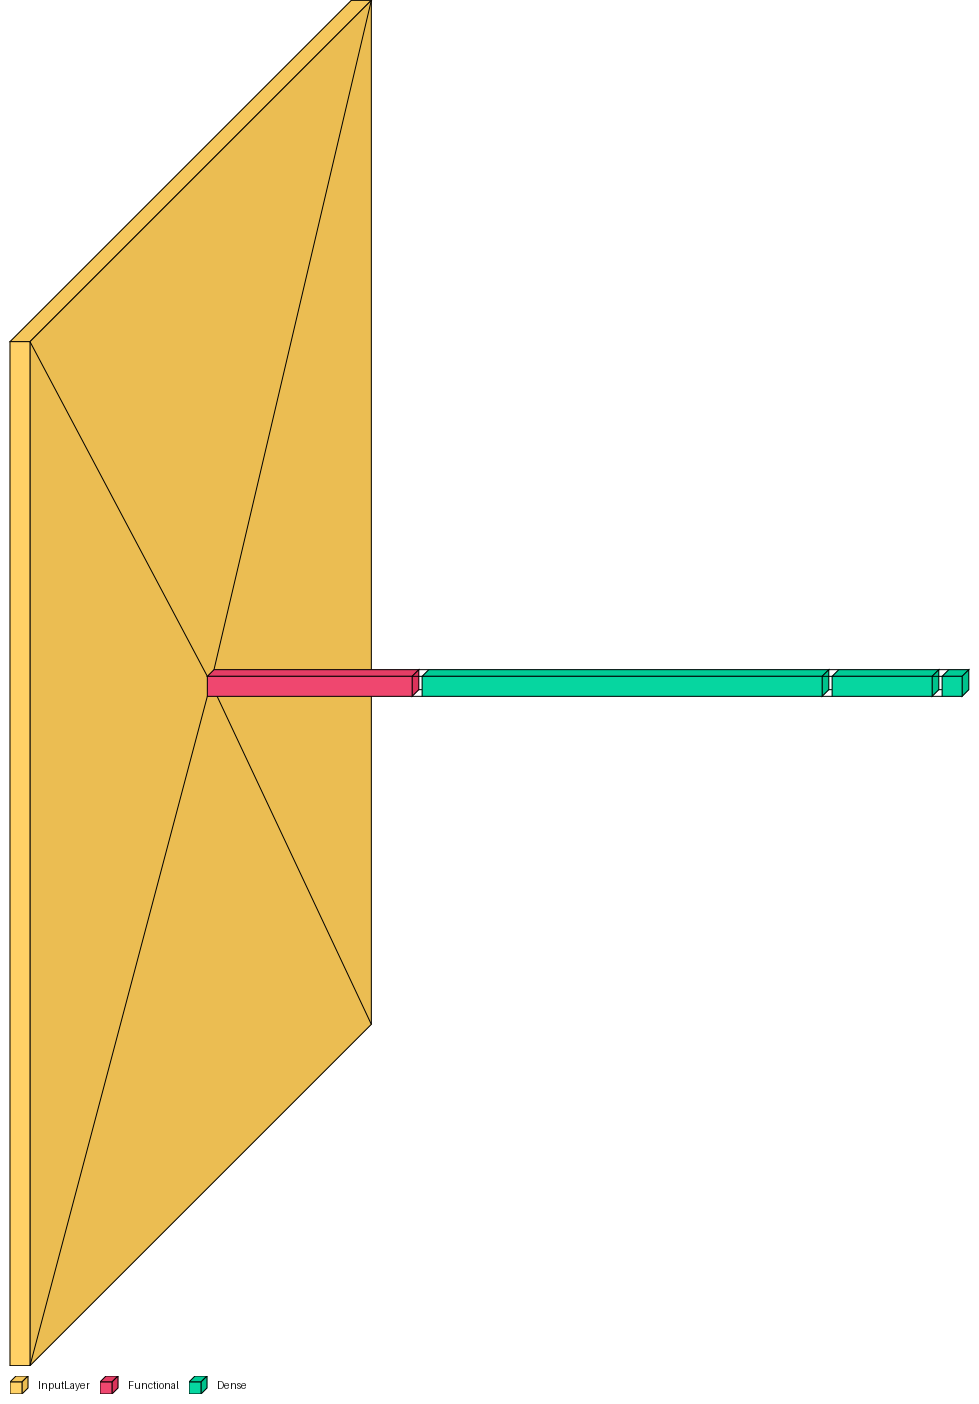

Epoch 1/50


/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:19:44 48s/step - acc: 0.0000e+00 - loss: 2.9843


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.0000e+00 - loss: 4.3848   


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:05 9s/step - acc: 0.0139 - loss: 4.5707    


  4/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.0202 - loss: 4.5396


  5/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.0274 - loss: 4.4627


  6/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.0332 - loss: 4.3771


  7/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.0368 - loss: 4.2943


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.0395 - loss: 4.2181


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.0428 - loss: 4.1507


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.0454 - loss: 4.0885


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.0472 - loss: 4.0339


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.0487 - loss: 3.9874


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.0502 - loss: 3.9454


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.0514 - loss: 3.9071


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - acc: 0.0522 - loss: 3.8719


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.0532 - loss: 3.8396


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.0541 - loss: 3.8096


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.0547 - loss: 3.7817


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.0553 - loss: 3.7553


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.0557 - loss: 3.7304


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.0563 - loss: 3.7070


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.0570 - loss: 3.6850


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 9s/step - acc: 0.0578 - loss: 3.6640


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 9s/step - acc: 0.0585 - loss: 3.6445


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.0595 - loss: 3.6254


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.0604 - loss: 3.6076


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - acc: 0.0613 - loss: 3.5907


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.0622 - loss: 3.5754


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.0630 - loss: 3.5609


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.0639 - loss: 3.5472


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.0648 - loss: 3.5339


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.0657 - loss: 3.5212


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.0666 - loss: 3.5088


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.0674 - loss: 3.4971 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.0682 - loss: 3.4858


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.0690 - loss: 3.4750


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.0698 - loss: 3.4647


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.0705 - loss: 3.4550


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.0712 - loss: 3.4455


 40/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.0719 - loss: 3.4366


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.0725 - loss: 3.4279


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.0731 - loss: 3.4197


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.0737 - loss: 3.4117


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.0743 - loss: 3.4040


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.0748 - loss: 3.3966


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.0753 - loss: 3.3894


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.0758 - loss: 3.3824


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.0763 - loss: 3.3757


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.0768 - loss: 3.3692


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.0772 - loss: 3.3628


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.0777 - loss: 3.3566


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.0781 - loss: 3.3506


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 9s/step - acc: 0.0785 - loss: 3.3448


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - acc: 0.0790 - loss: 3.3390


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.0794 - loss: 3.3335


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.0797 - loss: 3.3280


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.0801 - loss: 3.3227


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.0805 - loss: 3.3175


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.0809 - loss: 3.3124


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.0812 - loss: 3.3074


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.0816 - loss: 3.3026


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.0819 - loss: 3.2979


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.0822 - loss: 3.2932


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:27 9s/step - acc: 0.0825 - loss: 3.2887


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:18 9s/step - acc: 0.0828 - loss: 3.2844

2024-05-10 16:46:55.838940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2024-05-10 16:47:33.479198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 652s 6s/step - acc: 0.0896 - loss: 3.1685 - val_acc: 0.0551 - val_loss: 9037846.0000


Epoch 2/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:19 14s/step - acc: 0.0938 - loss: 2.9705


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:42 9s/step - acc: 0.1094 - loss: 2.8900 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.1076 - loss: 2.8693


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.1061 - loss: 2.8517


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.1049 - loss: 2.8417


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.1039 - loss: 2.8315


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.1044 - loss: 2.8231


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.1055 - loss: 2.8195


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.1088 - loss: 2.8156


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.1114 - loss: 2.8130


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.1134 - loss: 2.8102


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.1143 - loss: 2.8082


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.1148 - loss: 2.8052


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:02 9s/step - acc: 0.1150 - loss: 2.8041


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:53 9s/step - acc: 0.1150 - loss: 2.8035


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.1149 - loss: 2.8029


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.1153 - loss: 2.8021


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 9s/step - acc: 0.1155 - loss: 2.8009


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.1159 - loss: 2.7993


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.1161 - loss: 2.7987


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - acc: 0.1163 - loss: 2.7988


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.1166 - loss: 2.7983


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.1167 - loss: 2.7983


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.1168 - loss: 2.7984


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.1168 - loss: 2.7987


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - acc: 0.1170 - loss: 2.7988


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.1172 - loss: 2.7989


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.1175 - loss: 2.7988


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.1179 - loss: 2.7988


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.1181 - loss: 2.7989


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.1182 - loss: 2.7990


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.1183 - loss: 2.7991


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.1184 - loss: 2.7992


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:52 9s/step - acc: 0.1184 - loss: 2.7991 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - acc: 0.1185 - loss: 2.7990


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:35 9s/step - acc: 0.1186 - loss: 2.7989


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:26 9s/step - acc: 0.1187 - loss: 2.7987


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:18 9s/step - acc: 0.1189 - loss: 2.7986


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:09 9s/step - acc: 0.1189 - loss: 2.7983


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:00 9s/step - acc: 0.1190 - loss: 2.7981


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.1190 - loss: 2.7978


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.1190 - loss: 2.7977


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.1191 - loss: 2.7978


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1191 - loss: 2.7978


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.1192 - loss: 2.7978


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1193 - loss: 2.7979


 47/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.1193 - loss: 2.7980


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.1194 - loss: 2.7982


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.1194 - loss: 2.7983


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.1195 - loss: 2.7985


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.1195 - loss: 2.7986


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.1196 - loss: 2.7986


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.1197 - loss: 2.7987


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.1197 - loss: 2.7987


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.1198 - loss: 2.7986


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.1199 - loss: 2.7985


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 9s/step - acc: 0.1200 - loss: 2.7984


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:23 9s/step - acc: 0.1201 - loss: 2.7983


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:14 9s/step - acc: 0.1202 - loss: 2.7981


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:05 9s/step - acc: 0.1204 - loss: 2.7980


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:56 9s/step - acc: 0.1205 - loss: 2.7978


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:47 9s/step - acc: 0.1206 - loss: 2.7976


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - acc: 0.1208 - loss: 2.7974


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - acc: 0.1209 - loss: 2.7972


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.1211 - loss: 2.7969

2024-05-10 16:57:19.212948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-10 16:57:54.980456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - acc: 0.1246 - loss: 2.7751 - val_acc: 0.0492 - val_loss: 497.9536


Epoch 3/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:38 14s/step - acc: 0.0938 - loss: 2.6219


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.1016 - loss: 2.6801 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.1094 - loss: 2.7109


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.1133 - loss: 2.7253


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.1144 - loss: 2.7304


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.1161 - loss: 2.7323


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.1180 - loss: 2.7300


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1194 - loss: 2.7260


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1196 - loss: 2.7218


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.1202 - loss: 2.7187


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.1216 - loss: 2.7141


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:22 9s/step - acc: 0.1228 - loss: 2.7106


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:13 9s/step - acc: 0.1235 - loss: 2.7076


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.1241 - loss: 2.7051


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.1246 - loss: 2.7034


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.1246 - loss: 2.7014


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - acc: 0.1248 - loss: 2.6992


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.1251 - loss: 2.6965


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.1255 - loss: 2.6938


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 9s/step - acc: 0.1258 - loss: 2.6910


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.1264 - loss: 2.6883


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:52 9s/step - acc: 0.1272 - loss: 2.6856


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:43 9s/step - acc: 0.1280 - loss: 2.6833


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.1288 - loss: 2.6812


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.1294 - loss: 2.6798


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.1299 - loss: 2.6785


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:06 9s/step - acc: 0.1304 - loss: 2.6773


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:57 9s/step - acc: 0.1309 - loss: 2.6764


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - acc: 0.1314 - loss: 2.6757


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.1317 - loss: 2.6750


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.1321 - loss: 2.6745


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.1323 - loss: 2.6743


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.1324 - loss: 2.6741


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.1325 - loss: 2.6742


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.1324 - loss: 2.6745 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.1324 - loss: 2.6748


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.1323 - loss: 2.6751


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.1322 - loss: 2.6754


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.1321 - loss: 2.6758


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - acc: 0.1319 - loss: 2.6762


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.1318 - loss: 2.6765


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:52 9s/step - acc: 0.1317 - loss: 2.6769


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:43 9s/step - acc: 0.1315 - loss: 2.6772


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:34 9s/step - acc: 0.1315 - loss: 2.6773


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:25 9s/step - acc: 0.1314 - loss: 2.6775


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.1314 - loss: 2.6778


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.1313 - loss: 2.6781


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:58 9s/step - acc: 0.1313 - loss: 2.6784


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:49 9s/step - acc: 0.1313 - loss: 2.6787


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:40 9s/step - acc: 0.1312 - loss: 2.6791


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:31 9s/step - acc: 0.1312 - loss: 2.6794


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:22 9s/step - acc: 0.1311 - loss: 2.6797


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:13 9s/step - acc: 0.1311 - loss: 2.6800


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:04 9s/step - acc: 0.1310 - loss: 2.6802


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.1310 - loss: 2.6804


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1309 - loss: 2.6806


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1309 - loss: 2.6808


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.1308 - loss: 2.6810


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.1308 - loss: 2.6812


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.1308 - loss: 2.6813


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1308 - loss: 2.6814


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.1308 - loss: 2.6814


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - acc: 0.1308 - loss: 2.6814


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.1308 - loss: 2.6815


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.1308 - loss: 2.6816

2024-05-10 17:07:41.706433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.1307 - loss: 2.6692 - val_acc: 0.0551 - val_loss: 61726.2500


Epoch 4/50


2024-05-10 17:08:17.323938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 8s/step - acc: 0.0769 - loss: 2.7498


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.1051 - loss: 2.7310


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.1264 - loss: 2.7138


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:31 9s/step - acc: 0.1315 - loss: 2.6909


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.1335 - loss: 2.6779


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.1363 - loss: 2.6697


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.1378 - loss: 2.6654


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.1379 - loss: 2.6624


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.1387 - loss: 2.6586


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.1398 - loss: 2.6533


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.1407 - loss: 2.6496


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.1423 - loss: 2.6446


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.1433 - loss: 2.6409


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.1437 - loss: 2.6399


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.1440 - loss: 2.6407


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.1441 - loss: 2.6422


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.1446 - loss: 2.6431


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.1451 - loss: 2.6437


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.1453 - loss: 2.6439


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.1454 - loss: 2.6442


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.1457 - loss: 2.6442


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.1459 - loss: 2.6439


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.1459 - loss: 2.6440


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1459 - loss: 2.6444


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.1458 - loss: 2.6448


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.1458 - loss: 2.6451


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1457 - loss: 2.6453


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.1458 - loss: 2.6454


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.1459 - loss: 2.6454


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.1459 - loss: 2.6451


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.1460 - loss: 2.6450


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.1460 - loss: 2.6449


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.1461 - loss: 2.6447


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.1462 - loss: 2.6443


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.1463 - loss: 2.6439 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.1465 - loss: 2.6433


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.1468 - loss: 2.6428


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.1472 - loss: 2.6422


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.1476 - loss: 2.6416


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.1480 - loss: 2.6409


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.1484 - loss: 2.6401


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.1487 - loss: 2.6393


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1491 - loss: 2.6384


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.1495 - loss: 2.6376


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1500 - loss: 2.6367


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.1504 - loss: 2.6359


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.1508 - loss: 2.6352


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.1512 - loss: 2.6345


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.1516 - loss: 2.6338


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.1519 - loss: 2.6331


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.1523 - loss: 2.6324


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.1527 - loss: 2.6318


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:13 9s/step - acc: 0.1531 - loss: 2.6311


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:04 9s/step - acc: 0.1534 - loss: 2.6304


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:55 9s/step - acc: 0.1538 - loss: 2.6297


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 9s/step - acc: 0.1541 - loss: 2.6290


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:37 9s/step - acc: 0.1544 - loss: 2.6284


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.1548 - loss: 2.6277


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:19 9s/step - acc: 0.1551 - loss: 2.6269


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - acc: 0.1555 - loss: 2.6262


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - acc: 0.1558 - loss: 2.6254


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - acc: 0.1562 - loss: 2.6246


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - acc: 0.1566 - loss: 2.6238


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:34 9s/step - acc: 0.1569 - loss: 2.6231


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 9s/step - acc: 0.1573 - loss: 2.6225

2024-05-10 17:18:03.781836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-10 17:18:39.441179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.1647 - loss: 2.5930 - val_acc: 0.1398 - val_loss: 7.0157


Epoch 5/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:35 14s/step - acc: 0.1562 - loss: 2.3829


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:57 9s/step - acc: 0.1719 - loss: 2.4123 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.1806 - loss: 2.4509


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.1764 - loss: 2.4763


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.1711 - loss: 2.4948


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.1669 - loss: 2.5079


  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:46 8s/step - acc: 0.1640 - loss: 2.5181


  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - acc: 0.1625 - loss: 2.5241


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - acc: 0.1609 - loss: 2.5263


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 8s/step - acc: 0.1595 - loss: 2.5297


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:45 9s/step - acc: 0.1583 - loss: 2.5330


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.1589 - loss: 2.5333


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 9s/step - acc: 0.1590 - loss: 2.5338


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.1590 - loss: 2.5337


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.1588 - loss: 2.5333


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 9s/step - acc: 0.1588 - loss: 2.5329


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.1583 - loss: 2.5332


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.1579 - loss: 2.5345


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.1578 - loss: 2.5351


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.1577 - loss: 2.5362


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.1580 - loss: 2.5366


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1584 - loss: 2.5368


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.1587 - loss: 2.5369


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.1591 - loss: 2.5367


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.1594 - loss: 2.5362


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.1599 - loss: 2.5354


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.1604 - loss: 2.5345


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.1608 - loss: 2.5336


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.1612 - loss: 2.5325


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.1615 - loss: 2.5315


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.1619 - loss: 2.5307


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.1623 - loss: 2.5299


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.1627 - loss: 2.5290


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.1631 - loss: 2.5285 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.1636 - loss: 2.5278


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.1640 - loss: 2.5271


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.1645 - loss: 2.5264


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.1649 - loss: 2.5258


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.1654 - loss: 2.5253


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.1658 - loss: 2.5248


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.1662 - loss: 2.5244


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.1666 - loss: 2.5238


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.1670 - loss: 2.5233


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.1674 - loss: 2.5227


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.1678 - loss: 2.5222


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.1681 - loss: 2.5217


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.1685 - loss: 2.5212


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.1688 - loss: 2.5207


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.1692 - loss: 2.5202


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.1695 - loss: 2.5197


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.1698 - loss: 2.5193


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.1701 - loss: 2.5189


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.1705 - loss: 2.5185


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.1708 - loss: 2.5180


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.1712 - loss: 2.5176


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.1715 - loss: 2.5172


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.1718 - loss: 2.5168


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.1722 - loss: 2.5163


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.1725 - loss: 2.5160


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.1728 - loss: 2.5156


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.1732 - loss: 2.5152


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.1735 - loss: 2.5147


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.1738 - loss: 2.5142


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.1742 - loss: 2.5138


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.1745 - loss: 2.5134

2024-05-10 17:28:27.275082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.1822 - loss: 2.4903 - val_acc: 0.1122 - val_loss: 16.8553


Epoch 6/50


2024-05-10 17:29:02.850764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:40 14s/step - acc: 0.1562 - loss: 2.3711


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.1797 - loss: 2.3753 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.1927 - loss: 2.3816


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.2012 - loss: 2.4082


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.2047 - loss: 2.4220


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.2053 - loss: 2.4340


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.2059 - loss: 2.4363


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.2075 - loss: 2.4349


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.2072 - loss: 2.4358


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.2068 - loss: 2.4411


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.2056 - loss: 2.4473


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.2054 - loss: 2.4519


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.2051 - loss: 2.4561


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.2049 - loss: 2.4595


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2051 - loss: 2.4626


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.2050 - loss: 2.4667


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.2047 - loss: 2.4706


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.2044 - loss: 2.4742


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.2041 - loss: 2.4772


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.2040 - loss: 2.4794


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.2039 - loss: 2.4811


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.2037 - loss: 2.4827


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.2035 - loss: 2.4845


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.2030 - loss: 2.4865


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.2028 - loss: 2.4877


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.2028 - loss: 2.4889


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.2027 - loss: 2.4896


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2028 - loss: 2.4902


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.2029 - loss: 2.4905


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.2030 - loss: 2.4906


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.2031 - loss: 2.4905


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.2031 - loss: 2.4904


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.2032 - loss: 2.4901


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.2032 - loss: 2.4900 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.2032 - loss: 2.4898


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.2032 - loss: 2.4897


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:27 9s/step - acc: 0.2032 - loss: 2.4898


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.2032 - loss: 2.4898


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - acc: 0.2032 - loss: 2.4897


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.2032 - loss: 2.4894


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2032 - loss: 2.4895


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.2032 - loss: 2.4895


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.2032 - loss: 2.4894


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2032 - loss: 2.4897


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2031 - loss: 2.4899


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.2030 - loss: 2.4902


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2029 - loss: 2.4904


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2028 - loss: 2.4906


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2026 - loss: 2.4907


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.2025 - loss: 2.4907


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2024 - loss: 2.4908


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.2023 - loss: 2.4907


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2022 - loss: 2.4907


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.2022 - loss: 2.4906


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.2021 - loss: 2.4904


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.2020 - loss: 2.4903


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.2020 - loss: 2.4902


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.2019 - loss: 2.4901


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2018 - loss: 2.4901


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2016 - loss: 2.4902


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2015 - loss: 2.4904


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2014 - loss: 2.4905


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.2013 - loss: 2.4905


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.2012 - loss: 2.4906


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.2011 - loss: 2.4907

2024-05-10 17:38:49.269065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-10 17:39:24.935770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.1983 - loss: 2.4797 - val_acc: 0.1555 - val_loss: 2.5454


Epoch 7/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:44 14s/step - acc: 0.1562 - loss: 2.6323


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.1562 - loss: 2.5840 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.1562 - loss: 2.5470


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.1562 - loss: 2.5245


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.1575 - loss: 2.5148


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.1599 - loss: 2.5055


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.1607 - loss: 2.5074


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.1625 - loss: 2.5096


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.1638 - loss: 2.5108


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.1643 - loss: 2.5118


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.1648 - loss: 2.5110


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.1659 - loss: 2.5114


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.1675 - loss: 2.5098


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.1683 - loss: 2.5106


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.1689 - loss: 2.5110


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.1694 - loss: 2.5114


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.1699 - loss: 2.5119


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.1702 - loss: 2.5125


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.1706 - loss: 2.5127


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.1711 - loss: 2.5126


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.1715 - loss: 2.5130


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.1719 - loss: 2.5132


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.1721 - loss: 2.5131


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.1724 - loss: 2.5133


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1726 - loss: 2.5133


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.1729 - loss: 2.5130


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.1732 - loss: 2.5123


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.1736 - loss: 2.5114


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.1741 - loss: 2.5102


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.1746 - loss: 2.5090


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.1749 - loss: 2.5081


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.1752 - loss: 2.5073


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.1755 - loss: 2.5067


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.1759 - loss: 2.5058 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.1764 - loss: 2.5046


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.1769 - loss: 2.5033


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.1773 - loss: 2.5022


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.1776 - loss: 2.5011


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - acc: 0.1781 - loss: 2.4999


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.1786 - loss: 2.4987


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.1790 - loss: 2.4977


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1795 - loss: 2.4965


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.1799 - loss: 2.4954


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.1803 - loss: 2.4945


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.1806 - loss: 2.4936


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.1810 - loss: 2.4926


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.1814 - loss: 2.4916


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.1818 - loss: 2.4907


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.1822 - loss: 2.4897


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.1826 - loss: 2.4887


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.1831 - loss: 2.4877


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.1836 - loss: 2.4867


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.1840 - loss: 2.4857


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.1845 - loss: 2.4846


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.1849 - loss: 2.4836


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.1854 - loss: 2.4825


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.1858 - loss: 2.4816


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.1863 - loss: 2.4806


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.1867 - loss: 2.4796


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.1872 - loss: 2.4785


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.1877 - loss: 2.4776


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.1881 - loss: 2.4767


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.1885 - loss: 2.4758


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.1889 - loss: 2.4749


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.1892 - loss: 2.4742

2024-05-10 17:49:12.105949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.1970 - loss: 2.4451 - val_acc: 0.0630 - val_loss: 265.4087


Epoch 8/50


2024-05-10 17:49:47.814636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:30 14s/step - acc: 0.3125 - loss: 2.0929


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:57 9s/step - acc: 0.2812 - loss: 2.2064 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.2708 - loss: 2.2315


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.2715 - loss: 2.2318


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.2722 - loss: 2.2366


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.2737 - loss: 2.2430


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.2729 - loss: 2.2508


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.2715 - loss: 2.2573


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.2699 - loss: 2.2687


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.2669 - loss: 2.2815


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.2636 - loss: 2.2929


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.2605 - loss: 2.3010


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.2580 - loss: 2.3085


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.2560 - loss: 2.3144


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.2541 - loss: 2.3194


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.2521 - loss: 2.3237


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.2508 - loss: 2.3277


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.2495 - loss: 2.3312


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.2483 - loss: 2.3345


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.2477 - loss: 2.3373


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.2468 - loss: 2.3395


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.2460 - loss: 2.3414


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.2453 - loss: 2.3427


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.2446 - loss: 2.3440


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.2438 - loss: 2.3452


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.2431 - loss: 2.3466


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.2426 - loss: 2.3476


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.2421 - loss: 2.3487


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.2415 - loss: 2.3497


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.2410 - loss: 2.3510


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.2406 - loss: 2.3521


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.2402 - loss: 2.3534


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.2397 - loss: 2.3545


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.2393 - loss: 2.3556


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.2389 - loss: 2.3564 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2384 - loss: 2.3573


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2379 - loss: 2.3585


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2375 - loss: 2.3593


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.2371 - loss: 2.3601


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2367 - loss: 2.3607


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.2363 - loss: 2.3614


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.2361 - loss: 2.3622


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2357 - loss: 2.3631


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2354 - loss: 2.3640


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2351 - loss: 2.3649


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2347 - loss: 2.3657


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 9s/step - acc: 0.2345 - loss: 2.3665


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.2341 - loss: 2.3676


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:50 9s/step - acc: 0.2338 - loss: 2.3686


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.2335 - loss: 2.3697


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.2333 - loss: 2.3708


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.2330 - loss: 2.3719


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 9s/step - acc: 0.2327 - loss: 2.3730


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.2325 - loss: 2.3741


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - acc: 0.2322 - loss: 2.3752


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - acc: 0.2319 - loss: 2.3764


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.2317 - loss: 2.3774


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.2314 - loss: 2.3784


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2312 - loss: 2.3795


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2309 - loss: 2.3806


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2307 - loss: 2.3816


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.2304 - loss: 2.3827


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.2301 - loss: 2.3837


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.2299 - loss: 2.3847


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.2296 - loss: 2.3857

2024-05-10 17:59:34.985450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.2233 - loss: 2.3952 - val_acc: 0.0551 - val_loss: 31.3320


Epoch 9/50


2024-05-10 18:00:10.663486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:40 14s/step - acc: 0.1562 - loss: 2.3971


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:58 9s/step - acc: 0.1328 - loss: 2.4930 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.1267 - loss: 2.5194


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:40 9s/step - acc: 0.1263 - loss: 2.5218


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.1348 - loss: 2.5037


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.1418 - loss: 2.4884


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.1477 - loss: 2.4834


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.1527 - loss: 2.4773


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.1566 - loss: 2.4733


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.1584 - loss: 2.4702


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.1600 - loss: 2.4687


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.1617 - loss: 2.4663


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.1624 - loss: 2.4677


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.1634 - loss: 2.4676


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.1647 - loss: 2.4673


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.1656 - loss: 2.4680


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.1664 - loss: 2.4685


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.1668 - loss: 2.4688


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.1670 - loss: 2.4707


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.1674 - loss: 2.4721


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.1678 - loss: 2.4731


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.1679 - loss: 2.4744


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.1680 - loss: 2.4755


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.1680 - loss: 2.4763


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.1682 - loss: 2.4771


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.1684 - loss: 2.4778


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.1688 - loss: 2.4783


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.1692 - loss: 2.4786


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.1697 - loss: 2.4789


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.1701 - loss: 2.4794


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.1705 - loss: 2.4799


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.1708 - loss: 2.4804


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.1712 - loss: 2.4810


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.1716 - loss: 2.4811


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.1720 - loss: 2.4811 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.1723 - loss: 2.4810


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.1726 - loss: 2.4812


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.1729 - loss: 2.4813


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.1734 - loss: 2.4813


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.1737 - loss: 2.4814


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.1741 - loss: 2.4817


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.1745 - loss: 2.4820


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.1748 - loss: 2.4823


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.1751 - loss: 2.4826


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.1754 - loss: 2.4828


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:16 9s/step - acc: 0.1757 - loss: 2.4829


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 9s/step - acc: 0.1761 - loss: 2.4829


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:59 9s/step - acc: 0.1765 - loss: 2.4829


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:49 9s/step - acc: 0.1769 - loss: 2.4828


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:40 9s/step - acc: 0.1774 - loss: 2.4827


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:31 9s/step - acc: 0.1778 - loss: 2.4825


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:22 9s/step - acc: 0.1783 - loss: 2.4823


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.1787 - loss: 2.4820


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.1791 - loss: 2.4817


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.1795 - loss: 2.4814


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.1800 - loss: 2.4811


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.1804 - loss: 2.4807


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.1809 - loss: 2.4803


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.1813 - loss: 2.4799


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.1817 - loss: 2.4794


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.1821 - loss: 2.4789


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.1825 - loss: 2.4785


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.1828 - loss: 2.4781


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.1832 - loss: 2.4776


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.1835 - loss: 2.4772

2024-05-10 18:09:57.395209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.1913 - loss: 2.4549 - val_acc: 0.0591 - val_loss: 147.7359


Epoch 10/50


2024-05-10 18:10:32.973598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:32 14s/step - acc: 0.3438 - loss: 2.2910


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.3516 - loss: 2.2915 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.3490 - loss: 2.2788


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.3359 - loss: 2.2958


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.3237 - loss: 2.3045


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.3115 - loss: 2.3168


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.3008 - loss: 2.3388


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2949 - loss: 2.3512


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.2903 - loss: 2.3605


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.2866 - loss: 2.3658


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - acc: 0.2830 - loss: 2.3694


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.2813 - loss: 2.3696


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.2797 - loss: 2.3699


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.2780 - loss: 2.3708


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.2764 - loss: 2.3716


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.2745 - loss: 2.3727


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.2730 - loss: 2.3736


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.2716 - loss: 2.3741


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2702 - loss: 2.3749


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.2690 - loss: 2.3754


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.2682 - loss: 2.3749


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.2676 - loss: 2.3748


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.2670 - loss: 2.3747


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.2668 - loss: 2.3739


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.2666 - loss: 2.3732


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.2662 - loss: 2.3728


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.2659 - loss: 2.3727


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.2657 - loss: 2.3722


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.2656 - loss: 2.3715


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.2655 - loss: 2.3711


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.2654 - loss: 2.3706


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.2652 - loss: 2.3704


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.2650 - loss: 2.3700


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.2650 - loss: 2.3694


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.2649 - loss: 2.3688 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2649 - loss: 2.3682


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2647 - loss: 2.3677


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2646 - loss: 2.3671


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.2644 - loss: 2.3667


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.2641 - loss: 2.3666


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.2639 - loss: 2.3664


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2636 - loss: 2.3663


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.2633 - loss: 2.3662


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:35 9s/step - acc: 0.2631 - loss: 2.3662


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.2628 - loss: 2.3662


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 9s/step - acc: 0.2626 - loss: 2.3662


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2624 - loss: 2.3664


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2622 - loss: 2.3665


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2621 - loss: 2.3665


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2619 - loss: 2.3664


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2618 - loss: 2.3663


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.2617 - loss: 2.3662


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2615 - loss: 2.3662


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.2613 - loss: 2.3665


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.2611 - loss: 2.3667


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.2609 - loss: 2.3672


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.2606 - loss: 2.3676


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.2604 - loss: 2.3680


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2602 - loss: 2.3684


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2599 - loss: 2.3688


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2597 - loss: 2.3691


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2595 - loss: 2.3695


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.2593 - loss: 2.3698


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.2591 - loss: 2.3702


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.2589 - loss: 2.3705

2024-05-10 18:20:19.855780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.2538 - loss: 2.3660 - val_acc: 0.0669 - val_loss: 141.0864


Epoch 11/50


2024-05-10 18:20:55.634502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:37 14s/step - acc: 0.2188 - loss: 2.3457


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.2266 - loss: 2.3688 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:48 9s/step - acc: 0.2205 - loss: 2.3946


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.2181 - loss: 2.4243


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.2195 - loss: 2.4296


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.2211 - loss: 2.4299


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2227 - loss: 2.4269


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.2246 - loss: 2.4234


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2255 - loss: 2.4202


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.2261 - loss: 2.4183


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.2254 - loss: 2.4192


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.2255 - loss: 2.4176


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.2254 - loss: 2.4158


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.2252 - loss: 2.4143


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.2246 - loss: 2.4138


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.2240 - loss: 2.4132


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.2237 - loss: 2.4120


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.2234 - loss: 2.4106


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2232 - loss: 2.4089


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.2228 - loss: 2.4077


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.2226 - loss: 2.4062


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.2226 - loss: 2.4043


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.2226 - loss: 2.4024


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:35 9s/step - acc: 0.2225 - loss: 2.4007


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.2226 - loss: 2.3991


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.2225 - loss: 2.3984


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.2226 - loss: 2.3977


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.2226 - loss: 2.3972


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:50 9s/step - acc: 0.2228 - loss: 2.3965


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - acc: 0.2229 - loss: 2.3958


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - acc: 0.2232 - loss: 2.3951


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - acc: 0.2235 - loss: 2.3947


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:14 9s/step - acc: 0.2238 - loss: 2.3943


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.2240 - loss: 2.3938


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.2242 - loss: 2.3934 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.2244 - loss: 2.3931


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.2246 - loss: 2.3928


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.2246 - loss: 2.3926


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.2247 - loss: 2.3923


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.2248 - loss: 2.3921


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 9s/step - acc: 0.2248 - loss: 2.3920


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2248 - loss: 2.3919


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.2248 - loss: 2.3919


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2249 - loss: 2.3919


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2249 - loss: 2.3919


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.2248 - loss: 2.3919


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2248 - loss: 2.3919


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2249 - loss: 2.3918


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2249 - loss: 2.3916


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.2249 - loss: 2.3915


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.2249 - loss: 2.3915


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.2251 - loss: 2.3913


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2251 - loss: 2.3912


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.2252 - loss: 2.3910


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.2253 - loss: 2.3907


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 9s/step - acc: 0.2255 - loss: 2.3905


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:32 9s/step - acc: 0.2256 - loss: 2.3902


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:23 9s/step - acc: 0.2258 - loss: 2.3899


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2259 - loss: 2.3897


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2260 - loss: 2.3896


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2261 - loss: 2.3895


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2262 - loss: 2.3894


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.2264 - loss: 2.3893


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.2265 - loss: 2.3890


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 9s/step - acc: 0.2267 - loss: 2.3888

2024-05-10 18:30:41.609686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.2308 - loss: 2.3705 - val_acc: 0.0591 - val_loss: 164.6665


Epoch 12/50


2024-05-10 18:31:17.330755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:38 14s/step - acc: 0.2812 - loss: 2.1729


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:57 9s/step - acc: 0.2578 - loss: 2.1801 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:43 9s/step - acc: 0.2448 - loss: 2.2127


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.2363 - loss: 2.2405


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:25 9s/step - acc: 0.2341 - loss: 2.2501


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.2341 - loss: 2.2549


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.2351 - loss: 2.2554


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.2375 - loss: 2.2533


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.2389 - loss: 2.2539


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.2390 - loss: 2.2592


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.2390 - loss: 2.2632


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.2395 - loss: 2.2642


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.2394 - loss: 2.2661


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.2392 - loss: 2.2670


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.2397 - loss: 2.2655


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.2401 - loss: 2.2650


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.2413 - loss: 2.2638


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.2423 - loss: 2.2628


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2430 - loss: 2.2626


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.2437 - loss: 2.2617


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.2443 - loss: 2.2607


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:53 9s/step - acc: 0.2450 - loss: 2.2595


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 9s/step - acc: 0.2456 - loss: 2.2584


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.2462 - loss: 2.2576


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.2468 - loss: 2.2568


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.2472 - loss: 2.2564


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2477 - loss: 2.2558


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2483 - loss: 2.2556


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.2489 - loss: 2.2549


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.2496 - loss: 2.2543


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.2501 - loss: 2.2540


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.2506 - loss: 2.2540


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:02 9s/step - acc: 0.2511 - loss: 2.2538


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.2516 - loss: 2.2536 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.2520 - loss: 2.2535


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.2524 - loss: 2.2534


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.2527 - loss: 2.2535


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.2529 - loss: 2.2536


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.2531 - loss: 2.2537


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.2534 - loss: 2.2537


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2536 - loss: 2.2537


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2536 - loss: 2.2538


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2536 - loss: 2.2541


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2536 - loss: 2.2545


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2535 - loss: 2.2549


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2536 - loss: 2.2552


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2535 - loss: 2.2554


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2535 - loss: 2.2556


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2534 - loss: 2.2559


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2534 - loss: 2.2561


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2534 - loss: 2.2563


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.2534 - loss: 2.2565


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2533 - loss: 2.2567


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.2533 - loss: 2.2569


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.2533 - loss: 2.2570


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.2534 - loss: 2.2571


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.2534 - loss: 2.2572


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.2534 - loss: 2.2574


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2535 - loss: 2.2574


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2536 - loss: 2.2575


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2536 - loss: 2.2576


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.2537 - loss: 2.2576


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.2538 - loss: 2.2577


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.2539 - loss: 2.2578


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.2540 - loss: 2.2579

2024-05-10 18:41:04.446623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.2564 - loss: 2.2472 - val_acc: 0.1654 - val_loss: 4.6929


Epoch 13/50


2024-05-10 18:41:40.199818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:34 14s/step - acc: 0.3125 - loss: 2.1440


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.2891 - loss: 2.1346 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.2795 - loss: 2.1338


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - acc: 0.2741 - loss: 2.1350


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.2705 - loss: 2.1381


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2654 - loss: 2.1588


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2600 - loss: 2.1739


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.2573 - loss: 2.1829


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2557 - loss: 2.1876


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.2542 - loss: 2.1953


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.2533 - loss: 2.2001


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.2528 - loss: 2.2041


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.2518 - loss: 2.2090


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.2514 - loss: 2.2126


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.2503 - loss: 2.2164


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.2495 - loss: 2.2184


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.2488 - loss: 2.2202


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.2484 - loss: 2.2215


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2483 - loss: 2.2219


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.2484 - loss: 2.2225


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.2486 - loss: 2.2231


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.2490 - loss: 2.2240


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.2496 - loss: 2.2243


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.2503 - loss: 2.2246


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.2508 - loss: 2.2245


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.2511 - loss: 2.2246


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2514 - loss: 2.2245


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.2518 - loss: 2.2241


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.2523 - loss: 2.2235


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.2529 - loss: 2.2227


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.2535 - loss: 2.2222


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.2540 - loss: 2.2217


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:02 9s/step - acc: 0.2546 - loss: 2.2212


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.2551 - loss: 2.2208 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.2555 - loss: 2.2206


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.2558 - loss: 2.2203


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.2562 - loss: 2.2201


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.2565 - loss: 2.2201


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - acc: 0.2569 - loss: 2.2200


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.2572 - loss: 2.2200


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2575 - loss: 2.2199


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:44 9s/step - acc: 0.2578 - loss: 2.2198


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2582 - loss: 2.2197


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2585 - loss: 2.2197


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2588 - loss: 2.2199


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.2591 - loss: 2.2201


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2593 - loss: 2.2205


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2595 - loss: 2.2210


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.2596 - loss: 2.2214


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.2598 - loss: 2.2220


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2600 - loss: 2.2224


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.2602 - loss: 2.2229


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2603 - loss: 2.2234


 54/101 ━━━━━━━━━━━━━━━━━━━━ 6:59 9s/step - acc: 0.2606 - loss: 2.2237


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:50 9s/step - acc: 0.2608 - loss: 2.2239


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.2611 - loss: 2.2241


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.2613 - loss: 2.2244


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.2615 - loss: 2.2246


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2617 - loss: 2.2249


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.2618 - loss: 2.2252


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:57 9s/step - acc: 0.2620 - loss: 2.2255


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:48 9s/step - acc: 0.2621 - loss: 2.2258


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.2622 - loss: 2.2261


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:30 9s/step - acc: 0.2624 - loss: 2.2264


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.2626 - loss: 2.2266

2024-05-10 18:51:26.837964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - acc: 0.2663 - loss: 2.2195 - val_acc: 0.1004 - val_loss: 35.2535


Epoch 14/50


2024-05-10 18:52:02.510600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:30 14s/step - acc: 0.2812 - loss: 2.1007


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.2500 - loss: 2.2030 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:42 9s/step - acc: 0.2465 - loss: 2.2191


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.2513 - loss: 2.2149


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.2573 - loss: 2.2096


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.2595 - loss: 2.2082


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2639 - loss: 2.2041


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2676 - loss: 2.2021


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2714 - loss: 2.2004


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.2752 - loss: 2.1991


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.2783 - loss: 2.1964


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.2805 - loss: 2.1954


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.2822 - loss: 2.1932


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.2838 - loss: 2.1910


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.2854 - loss: 2.1890


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:47 9s/step - acc: 0.2870 - loss: 2.1872


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.2882 - loss: 2.1863


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.2896 - loss: 2.1849


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2906 - loss: 2.1838


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.2916 - loss: 2.1826


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.2924 - loss: 2.1813


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.2929 - loss: 2.1833


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:23 9s/step - acc: 0.2932 - loss: 2.1856


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:15 9s/step - acc: 0.2936 - loss: 2.1873


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - acc: 0.2941 - loss: 2.1888


 26/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.2943 - loss: 2.1903


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.2943 - loss: 2.1917


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2943 - loss: 2.1930


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.2943 - loss: 2.1939


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.2941 - loss: 2.1949


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.2937 - loss: 2.1965


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.2934 - loss: 2.1978


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 9s/step - acc: 0.2932 - loss: 2.1990


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.2929 - loss: 2.2001 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:44 9s/step - acc: 0.2927 - loss: 2.2011


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.2924 - loss: 2.2023


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:27 9s/step - acc: 0.2921 - loss: 2.2033


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.2918 - loss: 2.2045


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 9s/step - acc: 0.2915 - loss: 2.2055


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.2913 - loss: 2.2063


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.2912 - loss: 2.2070


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2910 - loss: 2.2075


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2909 - loss: 2.2080


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2909 - loss: 2.2085


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2908 - loss: 2.2090


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.2907 - loss: 2.2095


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.2907 - loss: 2.2099


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.2907 - loss: 2.2102


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.2908 - loss: 2.2102


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.2909 - loss: 2.2102


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.2910 - loss: 2.2103


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.2911 - loss: 2.2104


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.2911 - loss: 2.2105


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.2913 - loss: 2.2105


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.2914 - loss: 2.2103


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.2915 - loss: 2.2102


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.2917 - loss: 2.2100


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.2918 - loss: 2.2099


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.2919 - loss: 2.2098


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.2920 - loss: 2.2098


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.2921 - loss: 2.2098


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.2922 - loss: 2.2098


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.2923 - loss: 2.2098


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.2924 - loss: 2.2099


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.2924 - loss: 2.2100

2024-05-10 19:01:49.702076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-10 19:02:25.517019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.2937 - loss: 2.1995 - val_acc: 0.3091 - val_loss: 2.0732


Epoch 15/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:46 14s/step - acc: 0.2188 - loss: 2.2934


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:56 9s/step - acc: 0.2188 - loss: 2.3093 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.2431 - loss: 2.3107


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - acc: 0.2565 - loss: 2.2860


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.2677 - loss: 2.2655


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.2717 - loss: 2.2603


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.2743 - loss: 2.2593


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.2762 - loss: 2.2534


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2783 - loss: 2.2454


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.2805 - loss: 2.2367


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.2823 - loss: 2.2289


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.2846 - loss: 2.2207


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.2864 - loss: 2.2148


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.2883 - loss: 2.2090


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.2895 - loss: 2.2038


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.2904 - loss: 2.2003


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.2911 - loss: 2.1964


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.2915 - loss: 2.1937


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.2915 - loss: 2.1914


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.2918 - loss: 2.1894


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.2924 - loss: 2.1875


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.2930 - loss: 2.1854


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.2937 - loss: 2.1830


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.2944 - loss: 2.1808


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.2951 - loss: 2.1785


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.2956 - loss: 2.1767


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.2960 - loss: 2.1751


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.2963 - loss: 2.1735


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.2966 - loss: 2.1719


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.2968 - loss: 2.1706


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.2971 - loss: 2.1692


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.2973 - loss: 2.1681


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.2974 - loss: 2.1671


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.2975 - loss: 2.1661


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.2976 - loss: 2.1650 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2977 - loss: 2.1642


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2977 - loss: 2.1633


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2978 - loss: 2.1624


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.2980 - loss: 2.1613


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2982 - loss: 2.1599


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.2984 - loss: 2.1584


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2987 - loss: 2.1568


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.2990 - loss: 2.1552


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.2994 - loss: 2.1536


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.2997 - loss: 2.1520


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3001 - loss: 2.1506


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3005 - loss: 2.1493


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3009 - loss: 2.1480


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3011 - loss: 2.1470


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3013 - loss: 2.1460


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3016 - loss: 2.1449


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3017 - loss: 2.1440


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3018 - loss: 2.1431


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3020 - loss: 2.1422


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3021 - loss: 2.1413


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.3022 - loss: 2.1405


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.3023 - loss: 2.1398


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3024 - loss: 2.1390


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3025 - loss: 2.1383


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3026 - loss: 2.1375


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3027 - loss: 2.1370


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3028 - loss: 2.1365


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3028 - loss: 2.1360


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3029 - loss: 2.1357


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3030 - loss: 2.1353

2024-05-10 19:12:13.937110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.3044 - loss: 2.1159 - val_acc: 0.1437 - val_loss: 5.0221


Epoch 16/50


2024-05-10 19:12:49.749102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:34 14s/step - acc: 0.3438 - loss: 1.8677


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - acc: 0.2969 - loss: 2.0090 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:43 9s/step - acc: 0.2778 - loss: 2.0625


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.2767 - loss: 2.0812


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:25 9s/step - acc: 0.2789 - loss: 2.0856


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2819 - loss: 2.0848


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.2850 - loss: 2.0800


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2864 - loss: 2.0767


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.2870 - loss: 2.0768


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.2871 - loss: 2.0811


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.2863 - loss: 2.0868


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.2854 - loss: 2.0913


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.2849 - loss: 2.0951


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.2843 - loss: 2.0984


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.2839 - loss: 2.1019


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.2844 - loss: 2.1028


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.2853 - loss: 2.1027


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.2862 - loss: 2.1025


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 9s/step - acc: 0.2872 - loss: 2.1020


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.2883 - loss: 2.1021


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.2892 - loss: 2.1023


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.2900 - loss: 2.1026


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.2907 - loss: 2.1030


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.2914 - loss: 2.1035


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.2920 - loss: 2.1042


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.2925 - loss: 2.1048


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.2930 - loss: 2.1053


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.2936 - loss: 2.1060


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.2940 - loss: 2.1065


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.2944 - loss: 2.1072


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.2946 - loss: 2.1078


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.2948 - loss: 2.1087


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.2950 - loss: 2.1092


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.2952 - loss: 2.1097


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.2954 - loss: 2.1100 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.2956 - loss: 2.1104


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.2957 - loss: 2.1105


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.2958 - loss: 2.1106


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.2959 - loss: 2.1108


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.2961 - loss: 2.1109


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.2963 - loss: 2.1108


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.2966 - loss: 2.1107


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.2969 - loss: 2.1105


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.2972 - loss: 2.1101


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.2975 - loss: 2.1097


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.2979 - loss: 2.1093


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.2982 - loss: 2.1091


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.2984 - loss: 2.1091


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.2986 - loss: 2.1092


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.2988 - loss: 2.1093


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.2990 - loss: 2.1094


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.2993 - loss: 2.1095


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 9s/step - acc: 0.2996 - loss: 2.1096


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.2998 - loss: 2.1096


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - acc: 0.3001 - loss: 2.1095


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - acc: 0.3004 - loss: 2.1095


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.3007 - loss: 2.1094


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:29 9s/step - acc: 0.3009 - loss: 2.1093


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:20 9s/step - acc: 0.3012 - loss: 2.1092


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3015 - loss: 2.1094


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3018 - loss: 2.1095


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3020 - loss: 2.1096


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3022 - loss: 2.1098


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3024 - loss: 2.1099


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3026 - loss: 2.1100

2024-05-10 19:22:37.566049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.3070 - loss: 2.1011 - val_acc: 0.2264 - val_loss: 3.3720


Epoch 17/50


2024-05-10 19:23:13.473900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:23 14s/step - acc: 0.0625 - loss: 2.6489


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:55 9s/step - acc: 0.1562 - loss: 2.4315 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.2014 - loss: 2.3213


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.2135 - loss: 2.2838


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.2296 - loss: 2.2527


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.2425 - loss: 2.2296


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.2519 - loss: 2.2117


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.2595 - loss: 2.1977


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 8s/step - acc: 0.2653 - loss: 2.1830


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - acc: 0.2707 - loss: 2.1705


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 8s/step - acc: 0.2761 - loss: 2.1587


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 8s/step - acc: 0.2796 - loss: 2.1482


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.2821 - loss: 2.1391


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - acc: 0.2843 - loss: 2.1327


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.2860 - loss: 2.1287


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.2875 - loss: 2.1252


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.2892 - loss: 2.1224


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:01 9s/step - acc: 0.2910 - loss: 2.1197


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.2924 - loss: 2.1188


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.2939 - loss: 2.1168


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.2953 - loss: 2.1147


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.2964 - loss: 2.1130


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.2976 - loss: 2.1107


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.2987 - loss: 2.1087


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.2997 - loss: 2.1067


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3006 - loss: 2.1048


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.3013 - loss: 2.1035


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.3019 - loss: 2.1021


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.3027 - loss: 2.1006


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.3033 - loss: 2.0992


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.3039 - loss: 2.0980


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:10 9s/step - acc: 0.3045 - loss: 2.0969


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:02 9s/step - acc: 0.3051 - loss: 2.0958


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:53 9s/step - acc: 0.3056 - loss: 2.0946 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 9s/step - acc: 0.3060 - loss: 2.0940


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:36 9s/step - acc: 0.3065 - loss: 2.0935


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.3068 - loss: 2.0931


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:19 9s/step - acc: 0.3072 - loss: 2.0925


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.3076 - loss: 2.0919


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.3081 - loss: 2.0911


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:53 9s/step - acc: 0.3086 - loss: 2.0903


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3092 - loss: 2.0894


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3098 - loss: 2.0886


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.3103 - loss: 2.0881


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.3107 - loss: 2.0875


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3112 - loss: 2.0869


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3116 - loss: 2.0865


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.3119 - loss: 2.0860


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3123 - loss: 2.0855


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3126 - loss: 2.0850


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3130 - loss: 2.0845


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.3134 - loss: 2.0839


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3137 - loss: 2.0834


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3140 - loss: 2.0830


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3143 - loss: 2.0826


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.3146 - loss: 2.0821


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.3149 - loss: 2.0815


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.3151 - loss: 2.0810


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.3154 - loss: 2.0805


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 9s/step - acc: 0.3157 - loss: 2.0799


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3159 - loss: 2.0794


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3162 - loss: 2.0789


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3165 - loss: 2.0783


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3167 - loss: 2.0778


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3170 - loss: 2.0775

2024-05-10 19:33:00.606287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.3225 - loss: 2.0589 - val_acc: 0.1634 - val_loss: 3.2634


Epoch 18/50


2024-05-10 19:33:36.326321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:40 14s/step - acc: 0.5000 - loss: 1.7160


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.4766 - loss: 1.7683 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.4462 - loss: 1.8373


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.4245 - loss: 1.8710


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4096 - loss: 1.9164


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.3977 - loss: 1.9456


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.3913 - loss: 1.9655


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.3858 - loss: 1.9814


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.3835 - loss: 1.9882


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.3808 - loss: 1.9933


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.3784 - loss: 1.9984


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.3773 - loss: 2.0016


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.3760 - loss: 2.0081


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.3748 - loss: 2.0130


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.3738 - loss: 2.0165


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.3727 - loss: 2.0205


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.3713 - loss: 2.0253


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.3705 - loss: 2.0296


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.3698 - loss: 2.0320


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.3695 - loss: 2.0337


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.3690 - loss: 2.0354


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.3685 - loss: 2.0370


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.3682 - loss: 2.0380


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.3681 - loss: 2.0382


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3679 - loss: 2.0383


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.3677 - loss: 2.0388


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.3674 - loss: 2.0395


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3670 - loss: 2.0400


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.3668 - loss: 2.0400


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.3666 - loss: 2.0400


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.3664 - loss: 2.0399


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.3662 - loss: 2.0398


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.3659 - loss: 2.0396


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.3658 - loss: 2.0397


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.3657 - loss: 2.0395 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3656 - loss: 2.0392


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3655 - loss: 2.0387


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3655 - loss: 2.0384


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3655 - loss: 2.0382


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3655 - loss: 2.0379


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3654 - loss: 2.0376


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3655 - loss: 2.0371


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3655 - loss: 2.0366


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3655 - loss: 2.0361


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.3655 - loss: 2.0356


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.3656 - loss: 2.0349


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.3656 - loss: 2.0342


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.3657 - loss: 2.0335


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.3657 - loss: 2.0329


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.3657 - loss: 2.0322


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.3657 - loss: 2.0314


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.3658 - loss: 2.0306


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 9s/step - acc: 0.3659 - loss: 2.0297


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - acc: 0.3659 - loss: 2.0290


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - acc: 0.3659 - loss: 2.0284


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - acc: 0.3659 - loss: 2.0278


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.3659 - loss: 2.0273


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.3660 - loss: 2.0267


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3660 - loss: 2.0262


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3660 - loss: 2.0258


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3660 - loss: 2.0254


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3660 - loss: 2.0251


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3659 - loss: 2.0249


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3658 - loss: 2.0248


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3656 - loss: 2.0248

2024-05-10 19:43:23.819002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.3624 - loss: 2.0140 - val_acc: 0.1378 - val_loss: 4.4728


Epoch 19/50


2024-05-10 19:43:59.667276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:33 14s/step - acc: 0.3438 - loss: 2.0099


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.3438 - loss: 2.1241 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.3333 - loss: 2.1640


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.3281 - loss: 2.1705


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.3313 - loss: 2.1623


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.3325 - loss: 2.1544


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3347 - loss: 2.1446


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3368 - loss: 2.1362


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.3372 - loss: 2.1304


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.3385 - loss: 2.1320


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.3387 - loss: 2.1323


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.3385 - loss: 2.1330


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.3376 - loss: 2.1340


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.3364 - loss: 2.1352


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.3355 - loss: 2.1359


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.3346 - loss: 2.1358


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.3338 - loss: 2.1362


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.3333 - loss: 2.1363


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3332 - loss: 2.1366


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.3333 - loss: 2.1360


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.3336 - loss: 2.1350


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.3339 - loss: 2.1336


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.3344 - loss: 2.1317


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.3345 - loss: 2.1304


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.3348 - loss: 2.1288


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.3350 - loss: 2.1275


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.3352 - loss: 2.1265


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.3353 - loss: 2.1258


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.3353 - loss: 2.1249


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.3353 - loss: 2.1238


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.3354 - loss: 2.1227


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.3354 - loss: 2.1218


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.3354 - loss: 2.1208


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.3355 - loss: 2.1197 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.3355 - loss: 2.1187


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3356 - loss: 2.1174


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3357 - loss: 2.1160


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3359 - loss: 2.1146


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.3361 - loss: 2.1133


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.3363 - loss: 2.1122


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.3364 - loss: 2.1112


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.3365 - loss: 2.1102


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.3367 - loss: 2.1090


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.3369 - loss: 2.1077


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.3370 - loss: 2.1066


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.3372 - loss: 2.1056


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.3373 - loss: 2.1046


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.3374 - loss: 2.1038


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.3374 - loss: 2.1031


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.3375 - loss: 2.1024


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.3375 - loss: 2.1019


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.3375 - loss: 2.1014


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.3375 - loss: 2.1008


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.3375 - loss: 2.1003


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.3375 - loss: 2.0999


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3376 - loss: 2.0994


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3376 - loss: 2.0989


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3376 - loss: 2.0984


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3376 - loss: 2.0979


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.3376 - loss: 2.0974


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.3376 - loss: 2.0968


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.3377 - loss: 2.0962


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.3377 - loss: 2.0956


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.3377 - loss: 2.0950


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.3378 - loss: 2.0944

2024-05-10 19:53:48.485943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.3395 - loss: 2.0692 - val_acc: 0.1496 - val_loss: 5.6228


Epoch 20/50


2024-05-10 19:54:24.229676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 22:55 14s/step - acc: 0.3438 - loss: 2.2680


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.3281 - loss: 2.2511 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.3264 - loss: 2.2023


  4/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 7s/step - acc: 0.3297 - loss: 2.1459


  5/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 8s/step - acc: 0.3290 - loss: 2.1183


  6/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - acc: 0.3329 - loss: 2.0903


  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 8s/step - acc: 0.3362 - loss: 2.0684


  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - acc: 0.3396 - loss: 2.0532


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - acc: 0.3431 - loss: 2.0376


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 8s/step - acc: 0.3454 - loss: 2.0258


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 8s/step - acc: 0.3481 - loss: 2.0148


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.3508 - loss: 2.0040


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.3517 - loss: 1.9959


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.3518 - loss: 1.9907


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.3513 - loss: 1.9880


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.3506 - loss: 1.9864


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.3507 - loss: 1.9840


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.3511 - loss: 1.9808


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.3515 - loss: 1.9775


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.3516 - loss: 1.9750


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:41 9s/step - acc: 0.3519 - loss: 1.9726


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.3521 - loss: 1.9704


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.3520 - loss: 1.9686


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3517 - loss: 1.9677


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.3517 - loss: 1.9663


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.3516 - loss: 1.9650


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.3514 - loss: 1.9640


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.3513 - loss: 1.9629


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.3513 - loss: 1.9619


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.3514 - loss: 1.9610


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.3514 - loss: 1.9602


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.3517 - loss: 1.9593


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.3520 - loss: 1.9582


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.3524 - loss: 1.9572 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.3528 - loss: 1.9561


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.3532 - loss: 1.9549


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.3536 - loss: 1.9536


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.3539 - loss: 1.9524


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3542 - loss: 1.9513


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3545 - loss: 1.9502


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3547 - loss: 1.9494


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3550 - loss: 1.9486


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.3552 - loss: 1.9479


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3555 - loss: 1.9469


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3559 - loss: 1.9459


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.3562 - loss: 1.9449


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3564 - loss: 1.9442


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3567 - loss: 1.9434


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3569 - loss: 1.9427


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3572 - loss: 1.9419


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.3575 - loss: 1.9411


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.3578 - loss: 1.9404


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3581 - loss: 1.9395


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3584 - loss: 1.9390


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3586 - loss: 1.9385


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.3588 - loss: 1.9380


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.3590 - loss: 1.9375


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3592 - loss: 1.9371


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3594 - loss: 1.9368


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3595 - loss: 1.9366


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3596 - loss: 1.9364


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3597 - loss: 1.9362


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3598 - loss: 1.9360


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3599 - loss: 1.9359


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3600 - loss: 1.9357

2024-05-10 20:04:11.724756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.3633 - loss: 1.9199 - val_acc: 0.2402 - val_loss: 3.4212


Epoch 21/50


2024-05-10 20:04:47.501060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:30 14s/step - acc: 0.4062 - loss: 1.7241


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.3828 - loss: 1.7408 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.3837 - loss: 1.7253


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:31 9s/step - acc: 0.3776 - loss: 1.7540


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.3771 - loss: 1.7642


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.3767 - loss: 1.7728


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.3752 - loss: 1.7804


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.3742 - loss: 1.7922


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.3743 - loss: 1.7974


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.3750 - loss: 1.8022


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.3758 - loss: 1.8060


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.3770 - loss: 1.8068


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.3780 - loss: 1.8074


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.3781 - loss: 1.8089


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:56 9s/step - acc: 0.3791 - loss: 1.8092


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.3800 - loss: 1.8095


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.3807 - loss: 1.8105


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 9s/step - acc: 0.3816 - loss: 1.8115


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 9s/step - acc: 0.3821 - loss: 1.8127


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 9s/step - acc: 0.3826 - loss: 1.8131


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.3833 - loss: 1.8134


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.3842 - loss: 1.8138


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.3848 - loss: 1.8145


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.3859 - loss: 1.8141


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.3866 - loss: 1.8142


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3874 - loss: 1.8144


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.3880 - loss: 1.8149


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3885 - loss: 1.8153


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.3889 - loss: 1.8158


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.3894 - loss: 1.8160


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.3897 - loss: 1.8162


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.3900 - loss: 1.8166


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.3902 - loss: 1.8171


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.3903 - loss: 1.8182


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.3904 - loss: 1.8195 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3904 - loss: 1.8206


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.3903 - loss: 1.8219


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.3903 - loss: 1.8230


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.3902 - loss: 1.8241


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:02 9s/step - acc: 0.3902 - loss: 1.8253


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3902 - loss: 1.8264


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3900 - loss: 1.8277


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3899 - loss: 1.8290


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.3897 - loss: 1.8303


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.3896 - loss: 1.8315


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3895 - loss: 1.8327


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.3893 - loss: 1.8338


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3893 - loss: 1.8348


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3892 - loss: 1.8358


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3891 - loss: 1.8368


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3890 - loss: 1.8378


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.3889 - loss: 1.8386


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.3889 - loss: 1.8395


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3888 - loss: 1.8403


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3888 - loss: 1.8410


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.3887 - loss: 1.8418


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.3886 - loss: 1.8425


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.3884 - loss: 1.8433


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.3883 - loss: 1.8439


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3882 - loss: 1.8446


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3882 - loss: 1.8452


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3881 - loss: 1.8457


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3879 - loss: 1.8464


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3878 - loss: 1.8470


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3877 - loss: 1.8475

2024-05-10 20:14:34.871562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.3846 - loss: 1.8497 - val_acc: 0.1909 - val_loss: 2.6971


Epoch 22/50


2024-05-10 20:15:10.782543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:42 14s/step - acc: 0.4062 - loss: 1.7739


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.3906 - loss: 1.8123 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:43 9s/step - acc: 0.3889 - loss: 1.8032


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.3815 - loss: 1.8071


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.3815 - loss: 1.7983


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.3769 - loss: 1.8057


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.3728 - loss: 1.8156


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.3721 - loss: 1.8156


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:50 9s/step - acc: 0.3709 - loss: 1.8162


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.3710 - loss: 1.8152


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.3701 - loss: 1.8151


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.3696 - loss: 1.8151


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.3689 - loss: 1.8159


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.3687 - loss: 1.8158


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.3695 - loss: 1.8147


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.3699 - loss: 1.8152


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.3696 - loss: 1.8169


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.3697 - loss: 1.8178


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.3697 - loss: 1.8202


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.3695 - loss: 1.8225


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.3695 - loss: 1.8247


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.3695 - loss: 1.8268


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.3695 - loss: 1.8284


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.3694 - loss: 1.8298


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.3693 - loss: 1.8317


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.3690 - loss: 1.8338


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.3687 - loss: 1.8359


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.3682 - loss: 1.8382


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.3679 - loss: 1.8401


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.3675 - loss: 1.8419


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.3674 - loss: 1.8432


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.3673 - loss: 1.8443


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.3673 - loss: 1.8450


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.3673 - loss: 1.8457


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.3673 - loss: 1.8463 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.3675 - loss: 1.8470


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.3677 - loss: 1.8473


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.3679 - loss: 1.8480


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.3681 - loss: 1.8485


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.3682 - loss: 1.8491


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.3684 - loss: 1.8497


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.3687 - loss: 1.8503


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.3689 - loss: 1.8507


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.3692 - loss: 1.8510


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:26 9s/step - acc: 0.3694 - loss: 1.8515


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.3696 - loss: 1.8518


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.3698 - loss: 1.8522


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.3699 - loss: 1.8526


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.3701 - loss: 1.8530


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.3703 - loss: 1.8533


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.3705 - loss: 1.8536


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 9s/step - acc: 0.3708 - loss: 1.8539


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:08 9s/step - acc: 0.3710 - loss: 1.8542


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.3713 - loss: 1.8544


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.3716 - loss: 1.8545


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.3718 - loss: 1.8547


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.3720 - loss: 1.8549


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.3722 - loss: 1.8551


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.3724 - loss: 1.8552


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3726 - loss: 1.8554


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3728 - loss: 1.8555


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3730 - loss: 1.8556


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3731 - loss: 1.8558


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3733 - loss: 1.8559


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3735 - loss: 1.8559

2024-05-10 20:24:58.091522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.3779 - loss: 1.8470 - val_acc: 0.1654 - val_loss: 148.0942


Epoch 23/50


2024-05-10 20:25:33.859344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:29 14s/step - acc: 0.4375 - loss: 1.6985


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.4609 - loss: 1.6937 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.4670 - loss: 1.6969


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - acc: 0.4596 - loss: 1.6977


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.4577 - loss: 1.6898


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4543 - loss: 1.6826


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4500 - loss: 1.6821


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4445 - loss: 1.6835


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4395 - loss: 1.6886


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4356 - loss: 1.6936


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.4324 - loss: 1.6980


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4304 - loss: 1.7010


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.4280 - loss: 1.7058


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.4266 - loss: 1.7091


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.4246 - loss: 1.7135


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4225 - loss: 1.7193


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - acc: 0.4207 - loss: 1.7248


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.4195 - loss: 1.7292


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4180 - loss: 1.7335


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4168 - loss: 1.7374


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.4159 - loss: 1.7405


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.4153 - loss: 1.7434


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:25 9s/step - acc: 0.4144 - loss: 1.7468


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:17 9s/step - acc: 0.4137 - loss: 1.7498


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.4130 - loss: 1.7530


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.4122 - loss: 1.7561


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.4116 - loss: 1.7585


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.4110 - loss: 1.7612


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.4104 - loss: 1.7641


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.4098 - loss: 1.7669


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 9s/step - acc: 0.4092 - loss: 1.7696


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 9s/step - acc: 0.4087 - loss: 1.7721


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.4080 - loss: 1.7744


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:54 9s/step - acc: 0.4075 - loss: 1.7767 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4069 - loss: 1.7789


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.4063 - loss: 1.7811


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:28 9s/step - acc: 0.4058 - loss: 1.7833


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.4054 - loss: 1.7852


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.4050 - loss: 1.7870


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4046 - loss: 1.7888


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.4041 - loss: 1.7906


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.4036 - loss: 1.7924


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4031 - loss: 1.7942


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4028 - loss: 1.7957


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4024 - loss: 1.7973


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4021 - loss: 1.7987


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4018 - loss: 1.8001


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4016 - loss: 1.8011


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4014 - loss: 1.8021


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4012 - loss: 1.8031


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4011 - loss: 1.8039


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4008 - loss: 1.8047


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.4007 - loss: 1.8054


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.4005 - loss: 1.8060


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.4003 - loss: 1.8066


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.4002 - loss: 1.8071


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4001 - loss: 1.8075


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.3999 - loss: 1.8080


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.3998 - loss: 1.8084


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.3996 - loss: 1.8089


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.3994 - loss: 1.8093


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.3993 - loss: 1.8097


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.3992 - loss: 1.8101


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.3991 - loss: 1.8105


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.3990 - loss: 1.8109

2024-05-10 20:35:21.559988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.3969 - loss: 1.8096 - val_acc: 0.1476 - val_loss: 12.6015


Epoch 24/50


2024-05-10 20:35:57.393038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:48 14s/step - acc: 0.3438 - loss: 1.5448


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.3672 - loss: 1.6527 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.3698 - loss: 1.6920


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.3750 - loss: 1.7114


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.3812 - loss: 1.7192


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - acc: 0.3863 - loss: 1.7249


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.3904 - loss: 1.7340


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.3939 - loss: 1.7444


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.3968 - loss: 1.7484


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - acc: 0.3993 - loss: 1.7494


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.4012 - loss: 1.7487


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4032 - loss: 1.7472


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.4039 - loss: 1.7473


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.4041 - loss: 1.7489


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.4038 - loss: 1.7512


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.4046 - loss: 1.7515


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:09 9s/step - acc: 0.4051 - loss: 1.7520


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:02 9s/step - acc: 0.4058 - loss: 1.7514


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4062 - loss: 1.7513


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.4066 - loss: 1.7507


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.4073 - loss: 1.7497


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 9s/step - acc: 0.4082 - loss: 1.7484


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - acc: 0.4090 - loss: 1.7473


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - acc: 0.4095 - loss: 1.7468


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:08 9s/step - acc: 0.4099 - loss: 1.7461


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.4100 - loss: 1.7455


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.4101 - loss: 1.7449


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.4102 - loss: 1.7443


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.4102 - loss: 1.7442


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:28 9s/step - acc: 0.4102 - loss: 1.7438


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4101 - loss: 1.7436


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:11 9s/step - acc: 0.4100 - loss: 1.7435


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.4099 - loss: 1.7433


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:54 9s/step - acc: 0.4099 - loss: 1.7429 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4099 - loss: 1.7424


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:37 9s/step - acc: 0.4101 - loss: 1.7417


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.4102 - loss: 1.7411


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:20 9s/step - acc: 0.4103 - loss: 1.7404


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 9s/step - acc: 0.4104 - loss: 1.7399


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4106 - loss: 1.7392


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.4108 - loss: 1.7386


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.4109 - loss: 1.7382


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4110 - loss: 1.7380


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4111 - loss: 1.7379


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4111 - loss: 1.7381


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4112 - loss: 1.7382


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4112 - loss: 1.7384


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4113 - loss: 1.7386


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4113 - loss: 1.7388


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:35 9s/step - acc: 0.4114 - loss: 1.7391


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 9s/step - acc: 0.4114 - loss: 1.7395


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4115 - loss: 1.7399


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.4116 - loss: 1.7402


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.4116 - loss: 1.7405


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.4116 - loss: 1.7408


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.4117 - loss: 1.7412


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:33 9s/step - acc: 0.4117 - loss: 1.7416


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 9s/step - acc: 0.4117 - loss: 1.7419


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:15 9s/step - acc: 0.4118 - loss: 1.7421


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4119 - loss: 1.7423


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4119 - loss: 1.7426


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4119 - loss: 1.7429


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4119 - loss: 1.7433


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.4119 - loss: 1.7437


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.4118 - loss: 1.7441

2024-05-10 20:45:44.828101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 623s 6s/step - acc: 0.4115 - loss: 1.7432 - val_acc: 0.2402 - val_loss: 5.7018


Epoch 25/50


2024-05-10 20:46:20.537396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:27 14s/step - acc: 0.5312 - loss: 1.6553


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.5547 - loss: 1.5558 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.5434 - loss: 1.5475


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - acc: 0.5247 - loss: 1.5692


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.5160 - loss: 1.5795


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.5047 - loss: 1.5945


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.4964 - loss: 1.6081


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4900 - loss: 1.6216


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4838 - loss: 1.6341


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4776 - loss: 1.6439


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4726 - loss: 1.6522


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4688 - loss: 1.6584


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4657 - loss: 1.6640


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4635 - loss: 1.6668


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4616 - loss: 1.6686


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4604 - loss: 1.6692


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4594 - loss: 1.6695


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4581 - loss: 1.6718


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4575 - loss: 1.6723


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4570 - loss: 1.6720


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4563 - loss: 1.6727


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.4557 - loss: 1.6727


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4552 - loss: 1.6726


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4549 - loss: 1.6723


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4546 - loss: 1.6720


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.4542 - loss: 1.6725


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.4535 - loss: 1.6738


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4529 - loss: 1.6748


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4521 - loss: 1.6758


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.4514 - loss: 1.6765


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.4509 - loss: 1.6769


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4504 - loss: 1.6775


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4499 - loss: 1.6779


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4493 - loss: 1.6784 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4487 - loss: 1.6788


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4483 - loss: 1.6791


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4477 - loss: 1.6794


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4472 - loss: 1.6796


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4469 - loss: 1.6797


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4465 - loss: 1.6797


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4462 - loss: 1.6797


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4458 - loss: 1.6798


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4455 - loss: 1.6798


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4452 - loss: 1.6799


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4449 - loss: 1.6800


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4446 - loss: 1.6802


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4444 - loss: 1.6804


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4441 - loss: 1.6808


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4438 - loss: 1.6811


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4435 - loss: 1.6814


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4433 - loss: 1.6817


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4431 - loss: 1.6822


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4429 - loss: 1.6824


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4427 - loss: 1.6828


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4425 - loss: 1.6831


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4424 - loss: 1.6835


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4421 - loss: 1.6839


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4419 - loss: 1.6842


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4417 - loss: 1.6846


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4415 - loss: 1.6848


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4413 - loss: 1.6850


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4412 - loss: 1.6852


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4410 - loss: 1.6854


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4409 - loss: 1.6856


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4407 - loss: 1.6858

2024-05-10 20:56:09.196465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4372 - loss: 1.6808 - val_acc: 0.3287 - val_loss: 2.4859


Epoch 26/50


2024-05-10 20:56:45.061797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:37 14s/step - acc: 0.4375 - loss: 1.6094


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:51 9s/step - acc: 0.4766 - loss: 1.5557 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.4774 - loss: 1.5562


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - acc: 0.4753 - loss: 1.5641


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4690 - loss: 1.5812


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4628 - loss: 1.5929


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4592 - loss: 1.5991


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4550 - loss: 1.6056


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.4500 - loss: 1.6132


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.4472 - loss: 1.6176


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.4453 - loss: 1.6225


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.4438 - loss: 1.6252


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:15 9s/step - acc: 0.4424 - loss: 1.6275


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.4417 - loss: 1.6286


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4410 - loss: 1.6300


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.4399 - loss: 1.6323


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4391 - loss: 1.6346


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.4387 - loss: 1.6367


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4380 - loss: 1.6401


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.4376 - loss: 1.6423


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.4370 - loss: 1.6442


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4362 - loss: 1.6464


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.4354 - loss: 1.6483


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 9s/step - acc: 0.4349 - loss: 1.6503


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:27 9s/step - acc: 0.4345 - loss: 1.6518


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.4343 - loss: 1.6527


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.4342 - loss: 1.6534


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:00 9s/step - acc: 0.4342 - loss: 1.6538


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:51 9s/step - acc: 0.4343 - loss: 1.6543


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:42 9s/step - acc: 0.4345 - loss: 1.6546


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.4348 - loss: 1.6549


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.4348 - loss: 1.6553


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - acc: 0.4348 - loss: 1.6558


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - acc: 0.4349 - loss: 1.6560


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:57 9s/step - acc: 0.4350 - loss: 1.6560 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4350 - loss: 1.6562


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4351 - loss: 1.6564


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4351 - loss: 1.6571


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4353 - loss: 1.6576


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4354 - loss: 1.6579


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4356 - loss: 1.6582


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.4358 - loss: 1.6585


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.4359 - loss: 1.6588


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4360 - loss: 1.6593


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4360 - loss: 1.6599


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4360 - loss: 1.6605


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4360 - loss: 1.6611


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:53 9s/step - acc: 0.4360 - loss: 1.6618


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - acc: 0.4359 - loss: 1.6625


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4359 - loss: 1.6631


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4359 - loss: 1.6635


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4359 - loss: 1.6640


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.4358 - loss: 1.6645


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.4359 - loss: 1.6649


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4358 - loss: 1.6654


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4358 - loss: 1.6659


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4358 - loss: 1.6664


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4358 - loss: 1.6670


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4359 - loss: 1.6675


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4359 - loss: 1.6679


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4360 - loss: 1.6684


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4360 - loss: 1.6688


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4361 - loss: 1.6692


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.4362 - loss: 1.6695


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.4363 - loss: 1.6697

2024-05-10 21:06:33.119833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.4383 - loss: 1.6660 - val_acc: 0.3740 - val_loss: 2.4378


Epoch 27/50


2024-05-10 21:07:08.958092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:26 14s/step - acc: 0.4375 - loss: 1.8319


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:58 9s/step - acc: 0.3984 - loss: 1.8349 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:48 9s/step - acc: 0.3906 - loss: 1.8358


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.3887 - loss: 1.8269


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.3884 - loss: 1.8204


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.3905 - loss: 1.8074


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.3947 - loss: 1.7954


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.3986 - loss: 1.7833


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4010 - loss: 1.7724


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4018 - loss: 1.7654


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4020 - loss: 1.7612


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4019 - loss: 1.7572


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4019 - loss: 1.7545


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4023 - loss: 1.7511


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4026 - loss: 1.7483


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4035 - loss: 1.7442


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4046 - loss: 1.7395


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.4054 - loss: 1.7363


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4066 - loss: 1.7328


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.4081 - loss: 1.7285


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.4097 - loss: 1.7243


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4112 - loss: 1.7203


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.4128 - loss: 1.7163


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4145 - loss: 1.7126


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4160 - loss: 1.7094


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4176 - loss: 1.7061


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4192 - loss: 1.7031


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.4208 - loss: 1.7005


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.4220 - loss: 1.6981


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.4231 - loss: 1.6960


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.4240 - loss: 1.6941


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.4247 - loss: 1.6926


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.4255 - loss: 1.6913


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.4264 - loss: 1.6898


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.4272 - loss: 1.6882 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4279 - loss: 1.6866


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4287 - loss: 1.6851


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4293 - loss: 1.6838


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4299 - loss: 1.6827


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4305 - loss: 1.6817


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4311 - loss: 1.6804


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:54 9s/step - acc: 0.4316 - loss: 1.6794


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:45 9s/step - acc: 0.4322 - loss: 1.6784


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:36 9s/step - acc: 0.4326 - loss: 1.6775


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 9s/step - acc: 0.4330 - loss: 1.6767


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 9s/step - acc: 0.4334 - loss: 1.6760


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.4338 - loss: 1.6754


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.4342 - loss: 1.6747


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.4346 - loss: 1.6742


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:41 9s/step - acc: 0.4350 - loss: 1.6736


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:32 9s/step - acc: 0.4353 - loss: 1.6730


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 9s/step - acc: 0.4357 - loss: 1.6724


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:14 9s/step - acc: 0.4360 - loss: 1.6720


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.4362 - loss: 1.6718


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 9s/step - acc: 0.4365 - loss: 1.6715


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:42 9s/step - acc: 0.4368 - loss: 1.6713


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4370 - loss: 1.6710


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4373 - loss: 1.6707


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4376 - loss: 1.6704


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4378 - loss: 1.6700


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4381 - loss: 1.6696


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4383 - loss: 1.6692


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4385 - loss: 1.6689


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.4387 - loss: 1.6685


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 9s/step - acc: 0.4389 - loss: 1.6682

2024-05-10 21:16:56.807744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.4428 - loss: 1.6517 - val_acc: 0.2106 - val_loss: 6.2000


Epoch 28/50


2024-05-10 21:17:32.623619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:37 14s/step - acc: 0.5000 - loss: 1.4059


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.4688 - loss: 1.5209 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.4583 - loss: 1.5480


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.4512 - loss: 1.5716


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.4459 - loss: 1.5973


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4385 - loss: 1.6184


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4364 - loss: 1.6248


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4336 - loss: 1.6338


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.4313 - loss: 1.6410


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4304 - loss: 1.6457


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.4303 - loss: 1.6484


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.4296 - loss: 1.6510


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4289 - loss: 1.6541


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4284 - loss: 1.6555


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4282 - loss: 1.6556


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4283 - loss: 1.6555


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4283 - loss: 1.6564


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4282 - loss: 1.6573


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4283 - loss: 1.6574


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.4282 - loss: 1.6578


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4283 - loss: 1.6579


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - acc: 0.4283 - loss: 1.6585


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.4285 - loss: 1.6589


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.4287 - loss: 1.6590


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4289 - loss: 1.6591


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4292 - loss: 1.6587


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4294 - loss: 1.6583


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4296 - loss: 1.6579


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4298 - loss: 1.6576


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.4300 - loss: 1.6574


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.4303 - loss: 1.6569


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4308 - loss: 1.6563


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4312 - loss: 1.6556


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4316 - loss: 1.6550 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4319 - loss: 1.6546


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4320 - loss: 1.6545


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4322 - loss: 1.6543


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4325 - loss: 1.6542


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4327 - loss: 1.6541


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4327 - loss: 1.6542


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4328 - loss: 1.6542


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4329 - loss: 1.6540


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4331 - loss: 1.6538


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4333 - loss: 1.6535


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4334 - loss: 1.6536


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4335 - loss: 1.6537


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4336 - loss: 1.6538


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4338 - loss: 1.6537


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4340 - loss: 1.6536


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4341 - loss: 1.6534


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4343 - loss: 1.6532


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4345 - loss: 1.6531


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4347 - loss: 1.6529


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4348 - loss: 1.6528


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4351 - loss: 1.6526


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4353 - loss: 1.6524


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4355 - loss: 1.6522


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4357 - loss: 1.6520


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4359 - loss: 1.6518


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4361 - loss: 1.6515


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4363 - loss: 1.6513


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4365 - loss: 1.6510


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4367 - loss: 1.6506


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4369 - loss: 1.6503


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4371 - loss: 1.6499

2024-05-10 21:27:21.597345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-10 21:27:57.445327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4420 - loss: 1.6313 - val_acc: 0.3937 - val_loss: 1.8487


Epoch 29/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:29 14s/step - acc: 0.6562 - loss: 1.3290


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.5938 - loss: 1.4752 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.5694 - loss: 1.4863


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.5579 - loss: 1.4766


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.5464 - loss: 1.4751


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:21 9s/step - acc: 0.5369 - loss: 1.4749


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.5278 - loss: 1.4845


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5209 - loss: 1.4952


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.5167 - loss: 1.5006


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5125 - loss: 1.5074


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5088 - loss: 1.5128


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5061 - loss: 1.5162


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5030 - loss: 1.5211


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5007 - loss: 1.5242


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.4994 - loss: 1.5252


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4989 - loss: 1.5248


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4983 - loss: 1.5252


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4980 - loss: 1.5255


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4978 - loss: 1.5249


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4979 - loss: 1.5241


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.4979 - loss: 1.5235


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4977 - loss: 1.5232


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4976 - loss: 1.5230


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4976 - loss: 1.5228


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4975 - loss: 1.5230


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4975 - loss: 1.5229


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4975 - loss: 1.5228


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4973 - loss: 1.5228


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4971 - loss: 1.5230


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.4968 - loss: 1.5232


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.4965 - loss: 1.5236


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4961 - loss: 1.5242


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4957 - loss: 1.5249


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4952 - loss: 1.5258 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4946 - loss: 1.5270


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4941 - loss: 1.5283


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4935 - loss: 1.5294


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4929 - loss: 1.5304


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4924 - loss: 1.5316


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4919 - loss: 1.5325


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4914 - loss: 1.5332


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4909 - loss: 1.5342


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4903 - loss: 1.5352


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4897 - loss: 1.5361


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4891 - loss: 1.5372


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4886 - loss: 1.5380


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4882 - loss: 1.5388


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4877 - loss: 1.5395


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4874 - loss: 1.5401


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4870 - loss: 1.5408


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4866 - loss: 1.5413


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4862 - loss: 1.5420


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4859 - loss: 1.5426


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4855 - loss: 1.5433


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4851 - loss: 1.5441


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4847 - loss: 1.5448


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4843 - loss: 1.5456


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4840 - loss: 1.5462


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4836 - loss: 1.5468


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4833 - loss: 1.5475


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4830 - loss: 1.5481


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4827 - loss: 1.5486


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4824 - loss: 1.5491


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4822 - loss: 1.5495


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4820 - loss: 1.5500

2024-05-10 21:37:46.754175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.4771 - loss: 1.5508 - val_acc: 0.3543 - val_loss: 2.0275


Epoch 30/50


2024-05-10 21:38:22.519267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:41 14s/step - acc: 0.5000 - loss: 1.4224


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - acc: 0.4922 - loss: 1.4671 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.4913 - loss: 1.4911


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.4954 - loss: 1.4860


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.5001 - loss: 1.4816


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.5010 - loss: 1.4844


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.5008 - loss: 1.4850


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4997 - loss: 1.4854


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4978 - loss: 1.4866


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4977 - loss: 1.4837


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4969 - loss: 1.4842


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4961 - loss: 1.4862


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4949 - loss: 1.4884


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4940 - loss: 1.4910


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4933 - loss: 1.4926


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4929 - loss: 1.4947


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4927 - loss: 1.4960


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4923 - loss: 1.4980


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.4916 - loss: 1.5009


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4912 - loss: 1.5034


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4905 - loss: 1.5065


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4896 - loss: 1.5111


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.4891 - loss: 1.5144


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.4886 - loss: 1.5172


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4882 - loss: 1.5199


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4876 - loss: 1.5224


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4872 - loss: 1.5247


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4867 - loss: 1.5269


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.4865 - loss: 1.5286


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.4863 - loss: 1.5301


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.4861 - loss: 1.5315


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4859 - loss: 1.5329


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4857 - loss: 1.5343


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4855 - loss: 1.5354 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.4854 - loss: 1.5366


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4851 - loss: 1.5378


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.4849 - loss: 1.5390


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4846 - loss: 1.5400


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4845 - loss: 1.5407


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4845 - loss: 1.5411


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4846 - loss: 1.5414


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4846 - loss: 1.5417


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4846 - loss: 1.5420


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4846 - loss: 1.5425


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4846 - loss: 1.5431


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4845 - loss: 1.5437


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4845 - loss: 1.5443


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4845 - loss: 1.5447


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4846 - loss: 1.5449


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4847 - loss: 1.5451


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4847 - loss: 1.5453


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4848 - loss: 1.5456


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4848 - loss: 1.5459


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4847 - loss: 1.5463


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4847 - loss: 1.5466


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4847 - loss: 1.5469


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4847 - loss: 1.5471


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4847 - loss: 1.5473


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4847 - loss: 1.5475


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4847 - loss: 1.5477


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4847 - loss: 1.5479


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4848 - loss: 1.5481


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4848 - loss: 1.5482


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4848 - loss: 1.5484


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4848 - loss: 1.5487

2024-05-10 21:48:11.126706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4839 - loss: 1.5471 - val_acc: 0.3661 - val_loss: 1.9551


Epoch 31/50


2024-05-10 21:48:47.157590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:36 14s/step - acc: 0.3438 - loss: 2.0257


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:58 9s/step - acc: 0.3984 - loss: 1.9322 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.4219 - loss: 1.8592


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.4395 - loss: 1.8161


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4478 - loss: 1.7772


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4530 - loss: 1.7567


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4578 - loss: 1.7412


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4607 - loss: 1.7321


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4631 - loss: 1.7220


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4659 - loss: 1.7104


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4679 - loss: 1.7015


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4684 - loss: 1.6957


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4686 - loss: 1.6893


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4691 - loss: 1.6830


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4690 - loss: 1.6779


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4692 - loss: 1.6720


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4698 - loss: 1.6655


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4700 - loss: 1.6601


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.4701 - loss: 1.6557


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4702 - loss: 1.6513


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.4700 - loss: 1.6478


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.4701 - loss: 1.6440


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4704 - loss: 1.6400


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4707 - loss: 1.6366


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4709 - loss: 1.6343


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4713 - loss: 1.6318


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.4718 - loss: 1.6290


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4724 - loss: 1.6260


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.4729 - loss: 1.6232


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.4733 - loss: 1.6209


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.4736 - loss: 1.6192


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.4739 - loss: 1.6175


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.4743 - loss: 1.6157


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.4746 - loss: 1.6139


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.4749 - loss: 1.6123 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4752 - loss: 1.6108


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4754 - loss: 1.6095


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4755 - loss: 1.6082


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4757 - loss: 1.6069


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4759 - loss: 1.6054


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4760 - loss: 1.6039


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4762 - loss: 1.6024


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4763 - loss: 1.6011


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4764 - loss: 1.5998


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4764 - loss: 1.5988


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4765 - loss: 1.5978


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4765 - loss: 1.5968


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4765 - loss: 1.5958


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4765 - loss: 1.5949


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.4766 - loss: 1.5939


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.4766 - loss: 1.5930


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4766 - loss: 1.5925


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4765 - loss: 1.5921


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4765 - loss: 1.5917


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4765 - loss: 1.5913


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4765 - loss: 1.5909


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4765 - loss: 1.5906


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4765 - loss: 1.5903


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4765 - loss: 1.5900


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4765 - loss: 1.5897


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4765 - loss: 1.5895


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4765 - loss: 1.5892


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4765 - loss: 1.5890


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4765 - loss: 1.5887


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4766 - loss: 1.5884

2024-05-10 21:58:35.780667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4771 - loss: 1.5734 - val_acc: 0.3740 - val_loss: 1.9764


Epoch 32/50


2024-05-10 21:59:11.794218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:42 14s/step - acc: 0.5000 - loss: 1.3791


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:55 9s/step - acc: 0.5078 - loss: 1.3551 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:44 9s/step - acc: 0.5017 - loss: 1.3693


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.4876 - loss: 1.4084


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.4726 - loss: 1.4402


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.4650 - loss: 1.4566


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.4592 - loss: 1.4688


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4570 - loss: 1.4740


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4563 - loss: 1.4780


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4554 - loss: 1.4831


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.4545 - loss: 1.4891


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.4549 - loss: 1.4925


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.4559 - loss: 1.4935


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.4567 - loss: 1.4955


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.4571 - loss: 1.4980


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.4573 - loss: 1.5019


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.4570 - loss: 1.5077


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4572 - loss: 1.5111


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4576 - loss: 1.5141


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4582 - loss: 1.5161


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.4587 - loss: 1.5178


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4594 - loss: 1.5191


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.4600 - loss: 1.5204


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.4606 - loss: 1.5213


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4613 - loss: 1.5223


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4619 - loss: 1.5231


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.4625 - loss: 1.5237


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4632 - loss: 1.5241


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.4641 - loss: 1.5245


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.4649 - loss: 1.5247


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.4658 - loss: 1.5248


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.4667 - loss: 1.5248


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.4674 - loss: 1.5248


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.4681 - loss: 1.5250


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.4687 - loss: 1.5251 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.4692 - loss: 1.5253


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.4698 - loss: 1.5254


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4702 - loss: 1.5254


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.4707 - loss: 1.5255


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.4711 - loss: 1.5255


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.4715 - loss: 1.5255


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4719 - loss: 1.5254


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4723 - loss: 1.5252


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4727 - loss: 1.5249


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4731 - loss: 1.5247


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4735 - loss: 1.5246


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4738 - loss: 1.5247


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4741 - loss: 1.5248


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4742 - loss: 1.5249


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.4744 - loss: 1.5249


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.4745 - loss: 1.5250


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.4747 - loss: 1.5252


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.4748 - loss: 1.5254


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.4749 - loss: 1.5256


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.4750 - loss: 1.5258


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:48 9s/step - acc: 0.4751 - loss: 1.5261


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:39 9s/step - acc: 0.4752 - loss: 1.5264


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:30 9s/step - acc: 0.4753 - loss: 1.5267


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.4753 - loss: 1.5272


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4753 - loss: 1.5278


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4754 - loss: 1.5286


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4754 - loss: 1.5294


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4754 - loss: 1.5303


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4754 - loss: 1.5311


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4753 - loss: 1.5319

2024-05-10 22:09:01.155173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4747 - loss: 1.5424 - val_acc: 0.1457 - val_loss: 4.1610


Epoch 33/50


2024-05-10 22:09:37.055106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:27 14s/step - acc: 0.2500 - loss: 2.1564


  2/101 ━━━━━━━━━━━━━━━━━━━━ 15:00 9s/step - acc: 0.3047 - loss: 1.9917 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.3455 - loss: 1.8815


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.3743 - loss: 1.8013


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.3907 - loss: 1.7477


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.4029 - loss: 1.7183


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:13 9s/step - acc: 0.4097 - loss: 1.7051


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:04 9s/step - acc: 0.4137 - loss: 1.6967


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:55 9s/step - acc: 0.4167 - loss: 1.6910


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.4188 - loss: 1.6889


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.4205 - loss: 1.6866


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.4228 - loss: 1.6842


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.4247 - loss: 1.6825


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.4257 - loss: 1.6818


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.4261 - loss: 1.6826


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.4268 - loss: 1.6823


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4274 - loss: 1.6817


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4278 - loss: 1.6820


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.4280 - loss: 1.6831


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - acc: 0.4282 - loss: 1.6841


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.4286 - loss: 1.6846


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 9s/step - acc: 0.4291 - loss: 1.6851


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:49 9s/step - acc: 0.4299 - loss: 1.6846


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:40 9s/step - acc: 0.4307 - loss: 1.6838


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - acc: 0.4316 - loss: 1.6829


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - acc: 0.4322 - loss: 1.6824


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:13 9s/step - acc: 0.4327 - loss: 1.6829


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:04 9s/step - acc: 0.4331 - loss: 1.6832


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.4333 - loss: 1.6839


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4336 - loss: 1.6844


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.4339 - loss: 1.6846


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.4341 - loss: 1.6849


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.4343 - loss: 1.6847


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.4347 - loss: 1.6844


 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.4351 - loss: 1.6839


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.4354 - loss: 1.6833 


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.4359 - loss: 1.6827


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.4363 - loss: 1.6820


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.4367 - loss: 1.6812


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.4372 - loss: 1.6806


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.4377 - loss: 1.6798


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4383 - loss: 1.6788


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4389 - loss: 1.6776


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.4396 - loss: 1.6763


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4401 - loss: 1.6751


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4406 - loss: 1.6739


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4412 - loss: 1.6726


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4417 - loss: 1.6713


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.4424 - loss: 1.6700


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.4429 - loss: 1.6687


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.4434 - loss: 1.6676


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4438 - loss: 1.6667


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4442 - loss: 1.6660


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.4446 - loss: 1.6654


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.4449 - loss: 1.6649


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4452 - loss: 1.6644


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.4455 - loss: 1.6639


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.4458 - loss: 1.6635


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4460 - loss: 1.6631


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4463 - loss: 1.6626


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4466 - loss: 1.6621


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4468 - loss: 1.6616


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4471 - loss: 1.6612


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4473 - loss: 1.6608


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4476 - loss: 1.6604

2024-05-10 22:19:26.565700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4529 - loss: 1.6421 - val_acc: 0.2657 - val_loss: 2.8841


Epoch 34/50


2024-05-10 22:20:02.431393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:31 14s/step - acc: 0.3750 - loss: 1.7532


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:59 9s/step - acc: 0.3672 - loss: 1.7238 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.3733 - loss: 1.6806


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.3698 - loss: 1.6935


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.3746 - loss: 1.6893


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.3781 - loss: 1.6815


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.3847 - loss: 1.6717


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.3923 - loss: 1.6628


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.3996 - loss: 1.6513


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4062 - loss: 1.6419


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.4119 - loss: 1.6338


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4162 - loss: 1.6299


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4208 - loss: 1.6246


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.4249 - loss: 1.6190


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4285 - loss: 1.6132


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4319 - loss: 1.6080


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4351 - loss: 1.6042


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4377 - loss: 1.6008


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.4402 - loss: 1.5982


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4423 - loss: 1.5962


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4438 - loss: 1.5941


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.4453 - loss: 1.5919


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4465 - loss: 1.5895


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4477 - loss: 1.5879


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4486 - loss: 1.5865


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4496 - loss: 1.5851


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.4508 - loss: 1.5833


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4519 - loss: 1.5817


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.4530 - loss: 1.5797


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.4537 - loss: 1.5783


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.4544 - loss: 1.5770


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.4550 - loss: 1.5758


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.4557 - loss: 1.5744


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.4564 - loss: 1.5728 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - acc: 0.4571 - loss: 1.5711


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.4579 - loss: 1.5692


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4587 - loss: 1.5670


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4595 - loss: 1.5650


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4604 - loss: 1.5629


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.4612 - loss: 1.5607


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.4619 - loss: 1.5589


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.4626 - loss: 1.5573


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:39 9s/step - acc: 0.4632 - loss: 1.5558


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - acc: 0.4639 - loss: 1.5545


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.4646 - loss: 1.5531


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.4652 - loss: 1.5519


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.4658 - loss: 1.5507


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:55 9s/step - acc: 0.4664 - loss: 1.5496


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.4670 - loss: 1.5485


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.4675 - loss: 1.5475


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.4680 - loss: 1.5466


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.4685 - loss: 1.5457


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4690 - loss: 1.5448


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4695 - loss: 1.5439


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4700 - loss: 1.5431


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.4704 - loss: 1.5423


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.4708 - loss: 1.5416


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.4712 - loss: 1.5409


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4717 - loss: 1.5401


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4720 - loss: 1.5394


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4724 - loss: 1.5387


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4728 - loss: 1.5380


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4732 - loss: 1.5373


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4735 - loss: 1.5367


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4738 - loss: 1.5361

2024-05-10 22:29:52.222964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - acc: 0.4814 - loss: 1.5150 - val_acc: 0.3091 - val_loss: 2.7978


Epoch 35/50


2024-05-10 22:30:28.204462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:22 14s/step - acc: 0.4375 - loss: 1.7479


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:56 9s/step - acc: 0.4219 - loss: 1.7058 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:48 9s/step - acc: 0.4340 - loss: 1.6709


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:40 9s/step - acc: 0.4505 - loss: 1.6369


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.4667 - loss: 1.5963


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.4783 - loss: 1.5681


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.4852 - loss: 1.5468


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.4905 - loss: 1.5306


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.4939 - loss: 1.5194


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.4976 - loss: 1.5068


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5009 - loss: 1.4967


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5037 - loss: 1.4881


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5054 - loss: 1.4819


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.5068 - loss: 1.4776


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.5074 - loss: 1.4741


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.5087 - loss: 1.4693


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.5093 - loss: 1.4663


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.5095 - loss: 1.4639


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.5096 - loss: 1.4626


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.5096 - loss: 1.4621


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.5093 - loss: 1.4621


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.5091 - loss: 1.4618


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.5089 - loss: 1.4617


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.5088 - loss: 1.4614


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5085 - loss: 1.4617


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.5081 - loss: 1.4621


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.5078 - loss: 1.4624


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5074 - loss: 1.4625


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.5069 - loss: 1.4629


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5065 - loss: 1.4631


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5063 - loss: 1.4631


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5061 - loss: 1.4629


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5060 - loss: 1.4629


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5057 - loss: 1.4638 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5055 - loss: 1.4645


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.5053 - loss: 1.4649


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5053 - loss: 1.4649


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5054 - loss: 1.4648


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5054 - loss: 1.4648


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5055 - loss: 1.4648


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5056 - loss: 1.4648


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5057 - loss: 1.4646


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5057 - loss: 1.4645


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5058 - loss: 1.4642


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5059 - loss: 1.4639


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.5059 - loss: 1.4638


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5058 - loss: 1.4637


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5059 - loss: 1.4636


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5060 - loss: 1.4634


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5061 - loss: 1.4631


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5061 - loss: 1.4629


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5062 - loss: 1.4629


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5062 - loss: 1.4627


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5063 - loss: 1.4625


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5063 - loss: 1.4623


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5064 - loss: 1.4620


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5065 - loss: 1.4618


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5065 - loss: 1.4617


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.5065 - loss: 1.4616


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5065 - loss: 1.4615


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5065 - loss: 1.4615


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.5066 - loss: 1.4614


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5066 - loss: 1.4614


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5066 - loss: 1.4614


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5067 - loss: 1.4613

2024-05-10 22:40:17.275213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5080 - loss: 1.4513 - val_acc: 0.3583 - val_loss: 2.0415


Epoch 36/50


2024-05-10 22:40:53.262189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:37 14s/step - acc: 0.4688 - loss: 1.4783


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - acc: 0.4844 - loss: 1.5253 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.5000 - loss: 1.5053


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:40 9s/step - acc: 0.5156 - loss: 1.4807


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.5200 - loss: 1.4655


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5253 - loss: 1.4486


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5319 - loss: 1.4328


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.5387 - loss: 1.4191


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.5421 - loss: 1.4114


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.5460 - loss: 1.4023


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.5498 - loss: 1.3933


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.5528 - loss: 1.3850


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.5549 - loss: 1.3790


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.5564 - loss: 1.3737


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.5578 - loss: 1.3689


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.5593 - loss: 1.3638


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.5608 - loss: 1.3597


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.5617 - loss: 1.3590


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.5624 - loss: 1.3598


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.5628 - loss: 1.3605


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.5628 - loss: 1.3613


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.5631 - loss: 1.3612


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.5630 - loss: 1.3625


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.5628 - loss: 1.3641


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5624 - loss: 1.3656


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5620 - loss: 1.3671


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.5615 - loss: 1.3687


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.5609 - loss: 1.3703


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.5602 - loss: 1.3719


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.5593 - loss: 1.3739


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.5584 - loss: 1.3759


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.5574 - loss: 1.3782


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.5564 - loss: 1.3806


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.5554 - loss: 1.3826 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5544 - loss: 1.3847


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.5534 - loss: 1.3868


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.5526 - loss: 1.3887


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5518 - loss: 1.3908


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.5510 - loss: 1.3928


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.5502 - loss: 1.3949


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5494 - loss: 1.3970


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.5487 - loss: 1.3990


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5481 - loss: 1.4009


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5474 - loss: 1.4029


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5467 - loss: 1.4048


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5460 - loss: 1.4068


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5452 - loss: 1.4088


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5445 - loss: 1.4107


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5438 - loss: 1.4126


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5431 - loss: 1.4146


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5424 - loss: 1.4165


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.5417 - loss: 1.4183


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.5411 - loss: 1.4200


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.5405 - loss: 1.4217


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5399 - loss: 1.4232


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5393 - loss: 1.4247


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.5388 - loss: 1.4263


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.5382 - loss: 1.4278


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.5377 - loss: 1.4291


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.5373 - loss: 1.4304


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.5368 - loss: 1.4318


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.5363 - loss: 1.4331


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.5358 - loss: 1.4345


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 9s/step - acc: 0.5353 - loss: 1.4359


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5349 - loss: 1.4372

2024-05-10 22:50:41.711911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.5250 - loss: 1.4597 - val_acc: 0.1339 - val_loss: 20.3500


Epoch 37/50


2024-05-10 22:51:17.640797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:40 14s/step - acc: 0.4062 - loss: 1.7785


  2/101 ━━━━━━━━━━━━━━━━━━━━ 15:01 9s/step - acc: 0.4141 - loss: 1.7645 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:48 9s/step - acc: 0.4219 - loss: 1.7539


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.4277 - loss: 1.7308


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.4347 - loss: 1.7064


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4395 - loss: 1.6879


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.4418 - loss: 1.6735


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.4437 - loss: 1.6603


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.4484 - loss: 1.6447


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.4539 - loss: 1.6263


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.4591 - loss: 1.6124


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.4636 - loss: 1.6001


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - acc: 0.4662 - loss: 1.5939


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.4680 - loss: 1.5893


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.4694 - loss: 1.5842


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.4705 - loss: 1.5795


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.4719 - loss: 1.5748


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.4731 - loss: 1.5706


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4742 - loss: 1.5662


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.4755 - loss: 1.5621


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.4767 - loss: 1.5588


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4778 - loss: 1.5562


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.4786 - loss: 1.5542


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4790 - loss: 1.5530


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.4791 - loss: 1.5525


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.4791 - loss: 1.5528


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.4792 - loss: 1.5529


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4794 - loss: 1.5529


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.4794 - loss: 1.5530


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.4794 - loss: 1.5533


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.4791 - loss: 1.5537


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.4788 - loss: 1.5544


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.4784 - loss: 1.5551


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.4781 - loss: 1.5557


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.4778 - loss: 1.5562 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.4775 - loss: 1.5565


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.4773 - loss: 1.5570


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.4771 - loss: 1.5573


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.4770 - loss: 1.5577


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.4769 - loss: 1.5578


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4768 - loss: 1.5579


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4766 - loss: 1.5581


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4764 - loss: 1.5584


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4763 - loss: 1.5585


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.4761 - loss: 1.5588


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.4760 - loss: 1.5589


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.4759 - loss: 1.5589


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.4758 - loss: 1.5591


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.4757 - loss: 1.5593


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.4756 - loss: 1.5594


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.4755 - loss: 1.5596


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.4754 - loss: 1.5597


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.4754 - loss: 1.5597


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.4754 - loss: 1.5598


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4755 - loss: 1.5597


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4755 - loss: 1.5597


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4755 - loss: 1.5598


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4755 - loss: 1.5599


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.4755 - loss: 1.5601


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.4755 - loss: 1.5603


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.4755 - loss: 1.5606


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4754 - loss: 1.5609


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4754 - loss: 1.5612


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4753 - loss: 1.5616


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4753 - loss: 1.5621

2024-05-10 23:01:06.783200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4738 - loss: 1.5636 - val_acc: 0.0335 - val_loss: 2019.4200


Epoch 38/50


2024-05-10 23:01:42.666463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:36 14s/step - acc: 0.4062 - loss: 1.5898


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.4062 - loss: 1.5529 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:42 9s/step - acc: 0.4236 - loss: 1.5054


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - acc: 0.4251 - loss: 1.5072


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:24 9s/step - acc: 0.4314 - loss: 1.4954


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.4341 - loss: 1.4977


  7/101 ━━━━━━━━━━━━━━━━━━━━ 12:36 8s/step - acc: 0.4376 - loss: 1.4962


  8/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - acc: 0.4388 - loss: 1.4984


  9/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - acc: 0.4409 - loss: 1.4987


 10/101 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - acc: 0.4423 - loss: 1.5000


 11/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - acc: 0.4438 - loss: 1.5010


 12/101 ━━━━━━━━━━━━━━━━━━━━ 12:38 9s/step - acc: 0.4448 - loss: 1.5023


 13/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.4460 - loss: 1.5025


 14/101 ━━━━━━━━━━━━━━━━━━━━ 12:29 9s/step - acc: 0.4479 - loss: 1.5013


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.4493 - loss: 1.5009


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:18 9s/step - acc: 0.4504 - loss: 1.5005


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 9s/step - acc: 0.4506 - loss: 1.5011


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.4507 - loss: 1.5022


 19/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.4506 - loss: 1.5035


 20/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 9s/step - acc: 0.4507 - loss: 1.5048


 21/101 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - acc: 0.4506 - loss: 1.5065


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:34 9s/step - acc: 0.4502 - loss: 1.5082


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 9s/step - acc: 0.4498 - loss: 1.5099


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:18 9s/step - acc: 0.4494 - loss: 1.5116


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4492 - loss: 1.5134


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.4490 - loss: 1.5155


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.4489 - loss: 1.5173


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.4490 - loss: 1.5187


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.4492 - loss: 1.5198


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.4494 - loss: 1.5208


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.4497 - loss: 1.5218


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.4501 - loss: 1.5222


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4504 - loss: 1.5231


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4508 - loss: 1.5237 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4511 - loss: 1.5244


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4514 - loss: 1.5253


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.4517 - loss: 1.5263


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4519 - loss: 1.5272


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4521 - loss: 1.5281


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.4524 - loss: 1.5287


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4527 - loss: 1.5294


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4530 - loss: 1.5298


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4533 - loss: 1.5304


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4536 - loss: 1.5309


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4539 - loss: 1.5314


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4542 - loss: 1.5318


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4545 - loss: 1.5322


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4548 - loss: 1.5325


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4550 - loss: 1.5330


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4552 - loss: 1.5335


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4555 - loss: 1.5339


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4558 - loss: 1.5343


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.4560 - loss: 1.5346


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.4563 - loss: 1.5348


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4565 - loss: 1.5351


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4567 - loss: 1.5355


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4569 - loss: 1.5358


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4570 - loss: 1.5362


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4572 - loss: 1.5365


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4573 - loss: 1.5369


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4574 - loss: 1.5373


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.4576 - loss: 1.5375


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.4577 - loss: 1.5376


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4579 - loss: 1.5378


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4581 - loss: 1.5379

2024-05-10 23:11:31.460162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.4619 - loss: 1.5328 - val_acc: 0.0591 - val_loss: 94.0620


Epoch 39/50


2024-05-10 23:12:07.282527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:33 14s/step - acc: 0.5312 - loss: 1.7242


  2/101 ━━━━━━━━━━━━━━━━━━━━ 15:02 9s/step - acc: 0.5391 - loss: 1.6562 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.5434 - loss: 1.6141


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:38 9s/step - acc: 0.5423 - loss: 1.5773


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.5451 - loss: 1.5551


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.5454 - loss: 1.5471


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:12 9s/step - acc: 0.5472 - loss: 1.5400


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5472 - loss: 1.5382


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5466 - loss: 1.5397


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.5472 - loss: 1.5382


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5463 - loss: 1.5396


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5452 - loss: 1.5381


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5443 - loss: 1.5358


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.5434 - loss: 1.5348


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5429 - loss: 1.5325


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5424 - loss: 1.5306


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.5417 - loss: 1.5282


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.5414 - loss: 1.5250


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.5413 - loss: 1.5218


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.5409 - loss: 1.5196


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.5409 - loss: 1.5171


 22/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 11s/step - acc: 0.5410 - loss: 1.5150


 23/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 10s/step - acc: 0.5408 - loss: 1.5135


 24/101 ━━━━━━━━━━━━━━━━━━━━ 13:21 10s/step - acc: 0.5408 - loss: 1.5119


 25/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 10s/step - acc: 0.5408 - loss: 1.5100


 26/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 10s/step - acc: 0.5409 - loss: 1.5081


 27/101 ━━━━━━━━━━━━━━━━━━━━ 12:37 10s/step - acc: 0.5408 - loss: 1.5064


 28/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 10s/step - acc: 0.5407 - loss: 1.5050


 29/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 10s/step - acc: 0.5407 - loss: 1.5033


 30/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 10s/step - acc: 0.5407 - loss: 1.5021


 31/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 10s/step - acc: 0.5409 - loss: 1.5005


 32/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 10s/step - acc: 0.5410 - loss: 1.4987


 33/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 10s/step - acc: 0.5412 - loss: 1.4970


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:56 10s/step - acc: 0.5413 - loss: 1.4960


 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 10s/step - acc: 0.5413 - loss: 1.4952


 36/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 10s/step - acc: 0.5414 - loss: 1.4944


 37/101 ━━━━━━━━━━━━━━━━━━━━ 10:23 10s/step - acc: 0.5413 - loss: 1.4939


 38/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 10s/step - acc: 0.5413 - loss: 1.4934


 39/101 ━━━━━━━━━━━━━━━━━━━━ 10:01 10s/step - acc: 0.5411 - loss: 1.4931


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 10s/step - acc: 0.5410 - loss: 1.4928 


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 10s/step - acc: 0.5408 - loss: 1.4925


 42/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 10s/step - acc: 0.5407 - loss: 1.4923


 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:18 10s/step - acc: 0.5406 - loss: 1.4920


 44/101 ━━━━━━━━━━━━━━━━━━━━ 9:08 10s/step - acc: 0.5404 - loss: 1.4919


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:58 10s/step - acc: 0.5401 - loss: 1.4920


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 10s/step - acc: 0.5399 - loss: 1.4923


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 10s/step - acc: 0.5397 - loss: 1.4924


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:27 10s/step - acc: 0.5394 - loss: 1.4926


 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:17 10s/step - acc: 0.5392 - loss: 1.4931


 50/101 ━━━━━━━━━━━━━━━━━━━━ 8:07 10s/step - acc: 0.5389 - loss: 1.4936


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:57 10s/step - acc: 0.5386 - loss: 1.4939


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 10s/step - acc: 0.5382 - loss: 1.4944


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 10s/step - acc: 0.5379 - loss: 1.4949


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 10s/step - acc: 0.5376 - loss: 1.4953


 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:17 10s/step - acc: 0.5372 - loss: 1.4959


 56/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 10s/step - acc: 0.5369 - loss: 1.4965


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.5365 - loss: 1.4971 


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - acc: 0.5362 - loss: 1.4976


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - acc: 0.5358 - loss: 1.4982


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 9s/step - acc: 0.5355 - loss: 1.4988


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5352 - loss: 1.4993


 62/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5348 - loss: 1.4999


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5344 - loss: 1.5005


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.5341 - loss: 1.5010


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:39 9s/step - acc: 0.5337 - loss: 1.5016

2024-05-10 23:22:25.539328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 654s 6s/step - acc: 0.5250 - loss: 1.5064 - val_acc: 0.1280 - val_loss: 27.5411


Epoch 40/50


2024-05-10 23:23:01.433579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:38 14s/step - acc: 0.5312 - loss: 1.5631


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.5078 - loss: 1.5706 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.4844 - loss: 1.5873


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.4746 - loss: 1.5977


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.4697 - loss: 1.5978


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:17 9s/step - acc: 0.4669 - loss: 1.5925


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4672 - loss: 1.5865


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:59 9s/step - acc: 0.4664 - loss: 1.5827


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.4644 - loss: 1.5813


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.4635 - loss: 1.5779


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.4643 - loss: 1.5738


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.4653 - loss: 1.5695


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.4659 - loss: 1.5651


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4673 - loss: 1.5603


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.4682 - loss: 1.5575


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.4687 - loss: 1.5555


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.4697 - loss: 1.5528


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.4707 - loss: 1.5507


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.4719 - loss: 1.5480


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.4729 - loss: 1.5460


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.4739 - loss: 1.5444


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.4749 - loss: 1.5427


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.4757 - loss: 1.5412


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.4765 - loss: 1.5391


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.4772 - loss: 1.5369


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.4778 - loss: 1.5349


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4784 - loss: 1.5334


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.4790 - loss: 1.5316


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.4797 - loss: 1.5295


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.4804 - loss: 1.5277


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.4811 - loss: 1.5258


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.4816 - loss: 1.5241


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.4821 - loss: 1.5233


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.4824 - loss: 1.5227 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.4826 - loss: 1.5221


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.4830 - loss: 1.5212


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.4834 - loss: 1.5203


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.4836 - loss: 1.5196


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.4839 - loss: 1.5192


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:03 9s/step - acc: 0.4841 - loss: 1.5187


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.4843 - loss: 1.5183


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.4846 - loss: 1.5178


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.4849 - loss: 1.5173


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.4851 - loss: 1.5168


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.4853 - loss: 1.5164


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.4854 - loss: 1.5161


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:02 9s/step - acc: 0.4856 - loss: 1.5156


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.4858 - loss: 1.5150


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.4860 - loss: 1.5146


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.4861 - loss: 1.5140


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.4863 - loss: 1.5135


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.4865 - loss: 1.5129


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:09 9s/step - acc: 0.4866 - loss: 1.5123


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:00 9s/step - acc: 0.4868 - loss: 1.5117


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.4871 - loss: 1.5110


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.4872 - loss: 1.5103


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.4874 - loss: 1.5096


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.4876 - loss: 1.5090


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.4878 - loss: 1.5084


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.4880 - loss: 1.5078


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.4881 - loss: 1.5073


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.4884 - loss: 1.5066


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.4885 - loss: 1.5059


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.4888 - loss: 1.5052


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.4890 - loss: 1.5044

2024-05-10 23:32:49.993875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 624s 6s/step - acc: 0.4940 - loss: 1.4797 - val_acc: 0.4213 - val_loss: 2.8124


Epoch 41/50


2024-05-10 23:33:25.707567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:35 14s/step - acc: 0.5625 - loss: 1.2387


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - acc: 0.5312 - loss: 1.2821 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.5312 - loss: 1.3173


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.5332 - loss: 1.3222


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.5378 - loss: 1.3166


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5376 - loss: 1.3205


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - acc: 0.5380 - loss: 1.3214


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:01 9s/step - acc: 0.5391 - loss: 1.3208


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.5390 - loss: 1.3239


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.5373 - loss: 1.3309


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.5357 - loss: 1.3374


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.5349 - loss: 1.3426


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.5344 - loss: 1.3462


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:06 9s/step - acc: 0.5345 - loss: 1.3482


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.5348 - loss: 1.3489


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.5350 - loss: 1.3504


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.5353 - loss: 1.3523


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.5355 - loss: 1.3537


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.5357 - loss: 1.3545


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.5362 - loss: 1.3546


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.5362 - loss: 1.3548


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.5363 - loss: 1.3549


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.5364 - loss: 1.3551


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.5366 - loss: 1.3551


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.5371 - loss: 1.3549


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.5375 - loss: 1.3547


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5376 - loss: 1.3548


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5378 - loss: 1.3548


 29/101 ━━━━━━━━━━━━━━━━━━━━ 11:09 9s/step - acc: 0.5381 - loss: 1.3546


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:59 9s/step - acc: 0.5385 - loss: 1.3540


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5388 - loss: 1.3536


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5390 - loss: 1.3533


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5392 - loss: 1.3531


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.5394 - loss: 1.3530


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.5395 - loss: 1.3529 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5396 - loss: 1.3528


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5397 - loss: 1.3527


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5397 - loss: 1.3527


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5399 - loss: 1.3527


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5400 - loss: 1.3525


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5401 - loss: 1.3525


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5402 - loss: 1.3529


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.5401 - loss: 1.3533


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5400 - loss: 1.3537


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5400 - loss: 1.3542


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.5400 - loss: 1.3545


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:09 9s/step - acc: 0.5400 - loss: 1.3549


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:00 9s/step - acc: 0.5400 - loss: 1.3553


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:51 9s/step - acc: 0.5400 - loss: 1.3557


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:42 9s/step - acc: 0.5399 - loss: 1.3560


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:33 9s/step - acc: 0.5398 - loss: 1.3565


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:24 9s/step - acc: 0.5397 - loss: 1.3570


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:15 9s/step - acc: 0.5396 - loss: 1.3574


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.5396 - loss: 1.3578


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.5395 - loss: 1.3581


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:48 9s/step - acc: 0.5395 - loss: 1.3583


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:39 9s/step - acc: 0.5395 - loss: 1.3586


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:30 9s/step - acc: 0.5395 - loss: 1.3589


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.5394 - loss: 1.3592


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5394 - loss: 1.3595


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:02 9s/step - acc: 0.5394 - loss: 1.3598


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:53 9s/step - acc: 0.5394 - loss: 1.3601


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5394 - loss: 1.3604


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5393 - loss: 1.3607


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:26 9s/step - acc: 0.5393 - loss: 1.3610

2024-05-10 23:43:20.518834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 631s 6s/step - acc: 0.5385 - loss: 1.3602 - val_acc: 0.4291 - val_loss: 1.8600


Epoch 42/50


2024-05-10 23:43:56.325006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:31 14s/step - acc: 0.4062 - loss: 1.5616


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - acc: 0.4297 - loss: 1.5755 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:42 9s/step - acc: 0.4358 - loss: 1.5814


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.4382 - loss: 1.5848


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - acc: 0.4418 - loss: 1.5842


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.4445 - loss: 1.5864


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.4512 - loss: 1.5753


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.4578 - loss: 1.5637


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:52 9s/step - acc: 0.4648 - loss: 1.5506


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.4708 - loss: 1.5401


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:34 9s/step - acc: 0.4750 - loss: 1.5335


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.4771 - loss: 1.5306


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.4790 - loss: 1.5270


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.4807 - loss: 1.5236


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.4828 - loss: 1.5183


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.4849 - loss: 1.5135


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.4868 - loss: 1.5084


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.4887 - loss: 1.5030


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.4902 - loss: 1.4983


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.4912 - loss: 1.4939


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:03 9s/step - acc: 0.4921 - loss: 1.4905


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:54 9s/step - acc: 0.4927 - loss: 1.4876


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 9s/step - acc: 0.4936 - loss: 1.4847


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.4945 - loss: 1.4819


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.4953 - loss: 1.4794


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.4960 - loss: 1.4774


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.4966 - loss: 1.4759


 28/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 10s/step - acc: 0.4971 - loss: 1.4747


 29/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 10s/step - acc: 0.4974 - loss: 1.4738


 30/101 ━━━━━━━━━━━━━━━━━━━━ 12:12 10s/step - acc: 0.4977 - loss: 1.4728


 31/101 ━━━━━━━━━━━━━━━━━━━━ 11:58 10s/step - acc: 0.4980 - loss: 1.4720


 32/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 10s/step - acc: 0.4983 - loss: 1.4712


 33/101 ━━━━━━━━━━━━━━━━━━━━ 11:32 10s/step - acc: 0.4986 - loss: 1.4707


 34/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 10s/step - acc: 0.4988 - loss: 1.4705


 35/101 ━━━━━━━━━━━━━━━━━━━━ 11:07 10s/step - acc: 0.4989 - loss: 1.4705


 36/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 10s/step - acc: 0.4991 - loss: 1.4706


 37/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 10s/step - acc: 0.4993 - loss: 1.4708


 38/101 ━━━━━━━━━━━━━━━━━━━━ 10:31 10s/step - acc: 0.4995 - loss: 1.4708


 39/101 ━━━━━━━━━━━━━━━━━━━━ 10:19 10s/step - acc: 0.4996 - loss: 1.4710


 40/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 10s/step - acc: 0.4998 - loss: 1.4710


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 10s/step - acc: 0.5000 - loss: 1.4710 


 42/101 ━━━━━━━━━━━━━━━━━━━━ 9:45 10s/step - acc: 0.5002 - loss: 1.4708


 43/101 ━━━━━━━━━━━━━━━━━━━━ 9:34 10s/step - acc: 0.5005 - loss: 1.4706


 44/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 10s/step - acc: 0.5008 - loss: 1.4703


 45/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 10s/step - acc: 0.5011 - loss: 1.4700


 46/101 ━━━━━━━━━━━━━━━━━━━━ 9:01 10s/step - acc: 0.5013 - loss: 1.4699


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:50 10s/step - acc: 0.5016 - loss: 1.4698


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:40 10s/step - acc: 0.5017 - loss: 1.4697


 49/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 10s/step - acc: 0.5019 - loss: 1.4695


 50/101 ━━━━━━━━━━━━━━━━━━━━ 8:18 10s/step - acc: 0.5021 - loss: 1.4692


 51/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 10s/step - acc: 0.5024 - loss: 1.4689


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:57 10s/step - acc: 0.5025 - loss: 1.4686


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 10s/step - acc: 0.5027 - loss: 1.4684


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 10s/step - acc: 0.5028 - loss: 1.4684


 55/101 ━━━━━━━━━━━━━━━━━━━━ 7:26 10s/step - acc: 0.5029 - loss: 1.4685


 56/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 10s/step - acc: 0.5029 - loss: 1.4685


 57/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 10s/step - acc: 0.5031 - loss: 1.4683


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:51 10s/step - acc: 0.5032 - loss: 1.4682


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:41 10s/step - acc: 0.5033 - loss: 1.4680


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 10s/step - acc: 0.5034 - loss: 1.4678


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 10s/step - acc: 0.5035 - loss: 1.4676


 62/101 ━━━━━━━━━━━━━━━━━━━━ 6:11 10s/step - acc: 0.5037 - loss: 1.4674


 63/101 ━━━━━━━━━━━━━━━━━━━━ 6:01 10s/step - acc: 0.5039 - loss: 1.4670


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:52 10s/step - acc: 0.5041 - loss: 1.4667


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 10s/step - acc: 0.5043 - loss: 1.4664

2024-05-10 23:54:18.980319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 659s 6s/step - acc: 0.5089 - loss: 1.4514 - val_acc: 0.1673 - val_loss: 6.1500


Epoch 43/50


2024-05-10 23:54:54.914037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:38 14s/step - acc: 0.5938 - loss: 1.3187


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:49 9s/step - acc: 0.5703 - loss: 1.4061 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:42 9s/step - acc: 0.5781 - loss: 1.3936


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.5801 - loss: 1.4048


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.5866 - loss: 1.3966


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:18 9s/step - acc: 0.5869 - loss: 1.3901


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:09 9s/step - acc: 0.5879 - loss: 1.3827


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.5881 - loss: 1.3776


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.5876 - loss: 1.3748


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:42 9s/step - acc: 0.5857 - loss: 1.3751


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.5833 - loss: 1.3770


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:24 9s/step - acc: 0.5799 - loss: 1.3824


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.5754 - loss: 1.3911


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.5716 - loss: 1.3977


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.5683 - loss: 1.4024


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.5663 - loss: 1.4054


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.5644 - loss: 1.4091


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.5629 - loss: 1.4118


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.5616 - loss: 1.4137


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.5604 - loss: 1.4156


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.5593 - loss: 1.4174


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.5580 - loss: 1.4190


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.5572 - loss: 1.4197


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.5563 - loss: 1.4206


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5550 - loss: 1.4218


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.5542 - loss: 1.4221


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5535 - loss: 1.4224


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5528 - loss: 1.4227


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:37 9s/step - acc: 0.5522 - loss: 1.4227


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:33 9s/step - acc: 0.5517 - loss: 1.4226


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:24 9s/step - acc: 0.5512 - loss: 1.4225


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:16 9s/step - acc: 0.5506 - loss: 1.4229


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:07 9s/step - acc: 0.5500 - loss: 1.4233


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - acc: 0.5496 - loss: 1.4235 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.5492 - loss: 1.4236


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.5488 - loss: 1.4236


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.5485 - loss: 1.4234


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:24 9s/step - acc: 0.5484 - loss: 1.4229


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - acc: 0.5483 - loss: 1.4223


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - acc: 0.5481 - loss: 1.4217


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:57 9s/step - acc: 0.5480 - loss: 1.4210


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:49 9s/step - acc: 0.5480 - loss: 1.4203


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:40 9s/step - acc: 0.5479 - loss: 1.4199


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:31 9s/step - acc: 0.5478 - loss: 1.4195


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:22 9s/step - acc: 0.5477 - loss: 1.4191


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:13 9s/step - acc: 0.5476 - loss: 1.4187


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:05 9s/step - acc: 0.5475 - loss: 1.4184


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:56 9s/step - acc: 0.5474 - loss: 1.4182


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:47 9s/step - acc: 0.5473 - loss: 1.4181


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:38 9s/step - acc: 0.5473 - loss: 1.4177


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - acc: 0.5473 - loss: 1.4174


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - acc: 0.5474 - loss: 1.4170


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - acc: 0.5474 - loss: 1.4167


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - acc: 0.5474 - loss: 1.4163


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:53 9s/step - acc: 0.5474 - loss: 1.4159


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - acc: 0.5475 - loss: 1.4155


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - acc: 0.5475 - loss: 1.4152


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - acc: 0.5475 - loss: 1.4150


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - acc: 0.5475 - loss: 1.4148


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:09 9s/step - acc: 0.5475 - loss: 1.4146


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:00 9s/step - acc: 0.5474 - loss: 1.4144


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:51 9s/step - acc: 0.5474 - loss: 1.4143


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:42 9s/step - acc: 0.5473 - loss: 1.4141


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 9s/step - acc: 0.5473 - loss: 1.4140


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:24 9s/step - acc: 0.5472 - loss: 1.4138

2024-05-11 00:04:45.524781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 627s 6s/step - acc: 0.5459 - loss: 1.4020 - val_acc: 0.2185 - val_loss: 4.2091


Epoch 44/50


2024-05-11 00:05:21.557759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:44 14s/step - acc: 0.6250 - loss: 1.1525


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:56 9s/step - acc: 0.6562 - loss: 1.1519 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:46 9s/step - acc: 0.6458 - loss: 1.1640


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:34 9s/step - acc: 0.6289 - loss: 1.1860


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:25 9s/step - acc: 0.6219 - loss: 1.1910


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.6172 - loss: 1.1971


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:08 9s/step - acc: 0.6158 - loss: 1.1992


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:00 9s/step - acc: 0.6135 - loss: 1.2018


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:51 9s/step - acc: 0.6140 - loss: 1.1998


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:43 9s/step - acc: 0.6145 - loss: 1.1973


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:33 9s/step - acc: 0.6139 - loss: 1.1983


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:25 9s/step - acc: 0.6129 - loss: 1.2027


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:16 9s/step - acc: 0.6119 - loss: 1.2065


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:07 9s/step - acc: 0.6116 - loss: 1.2081


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:58 9s/step - acc: 0.6112 - loss: 1.2100


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:49 9s/step - acc: 0.6109 - loss: 1.2136


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - acc: 0.6097 - loss: 1.2192


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.6079 - loss: 1.2255


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.6059 - loss: 1.2327


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.6042 - loss: 1.2388


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.6020 - loss: 1.2451


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.5999 - loss: 1.2506


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.5978 - loss: 1.2557


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.5959 - loss: 1.2602


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.5940 - loss: 1.2647


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5923 - loss: 1.2687


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.5907 - loss: 1.2724


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.5891 - loss: 1.2761


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.5876 - loss: 1.2793


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.5863 - loss: 1.2821


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 9s/step - acc: 0.5851 - loss: 1.2849


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:25 9s/step - acc: 0.5840 - loss: 1.2873


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5829 - loss: 1.2897


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.5818 - loss: 1.2921


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.5807 - loss: 1.2944 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:50 9s/step - acc: 0.5796 - loss: 1.2964


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:41 9s/step - acc: 0.5786 - loss: 1.2983


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.5777 - loss: 1.3003


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.5769 - loss: 1.3022


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.5761 - loss: 1.3039


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.5754 - loss: 1.3056


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.5747 - loss: 1.3071


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.5741 - loss: 1.3085


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5734 - loss: 1.3096


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5728 - loss: 1.3108


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:19 9s/step - acc: 0.5722 - loss: 1.3120


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:10 9s/step - acc: 0.5716 - loss: 1.3131


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.5710 - loss: 1.3143


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5704 - loss: 1.3155


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5699 - loss: 1.3167


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.5694 - loss: 1.3178


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.5689 - loss: 1.3186


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.5685 - loss: 1.3194


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:06 9s/step - acc: 0.5681 - loss: 1.3202


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:57 9s/step - acc: 0.5677 - loss: 1.3210


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:48 9s/step - acc: 0.5674 - loss: 1.3217


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:39 9s/step - acc: 0.5671 - loss: 1.3224


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:30 9s/step - acc: 0.5667 - loss: 1.3231


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - acc: 0.5664 - loss: 1.3239


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - acc: 0.5660 - loss: 1.3246


 61/101 ━━━━━━━━━━━━━━━━━━━━ 6:03 9s/step - acc: 0.5657 - loss: 1.3253


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:54 9s/step - acc: 0.5653 - loss: 1.3261


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 9s/step - acc: 0.5650 - loss: 1.3269


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 9s/step - acc: 0.5646 - loss: 1.3277


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5642 - loss: 1.3286

2024-05-11 00:15:10.847152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5561 - loss: 1.3420 - val_acc: 0.2756 - val_loss: 5.8220


Epoch 45/50


2024-05-11 00:15:46.874246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:45 14s/step - acc: 0.5938 - loss: 1.3717


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:54 9s/step - acc: 0.5938 - loss: 1.3898 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.5938 - loss: 1.3981


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.5898 - loss: 1.3999


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.5869 - loss: 1.4091


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.5811 - loss: 1.4189


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5765 - loss: 1.4254


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5752 - loss: 1.4246


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5754 - loss: 1.4227


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:46 9s/step - acc: 0.5753 - loss: 1.4206


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:37 9s/step - acc: 0.5747 - loss: 1.4178


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5737 - loss: 1.4155


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5728 - loss: 1.4131


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5718 - loss: 1.4118


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:00 9s/step - acc: 0.5709 - loss: 1.4110


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5701 - loss: 1.4098


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.5693 - loss: 1.4092


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.5683 - loss: 1.4092


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.5674 - loss: 1.4090


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.5663 - loss: 1.4093


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.5654 - loss: 1.4091


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.5646 - loss: 1.4090


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.5640 - loss: 1.4082


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.5633 - loss: 1.4074


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.5629 - loss: 1.4059


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.5625 - loss: 1.4047


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.5620 - loss: 1.4040


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.5617 - loss: 1.4029


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.5615 - loss: 1.4016


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.5612 - loss: 1.4007


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.5608 - loss: 1.3998


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5606 - loss: 1.3989


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.5602 - loss: 1.3983


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5598 - loss: 1.3977 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5594 - loss: 1.3971


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.5591 - loss: 1.3963


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5590 - loss: 1.3953


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5589 - loss: 1.3942


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5588 - loss: 1.3932


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5587 - loss: 1.3922


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5587 - loss: 1.3912


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5587 - loss: 1.3902


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5587 - loss: 1.3893


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5587 - loss: 1.3885


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5587 - loss: 1.3875


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5587 - loss: 1.3867


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5587 - loss: 1.3858


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5588 - loss: 1.3849


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5588 - loss: 1.3841


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5588 - loss: 1.3832


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5588 - loss: 1.3824


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5589 - loss: 1.3817


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5589 - loss: 1.3809


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5590 - loss: 1.3800


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5591 - loss: 1.3792


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5592 - loss: 1.3782


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.5593 - loss: 1.3774


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.5594 - loss: 1.3767


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.5595 - loss: 1.3759


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5596 - loss: 1.3752


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5597 - loss: 1.3745


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.5598 - loss: 1.3738


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5599 - loss: 1.3731


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5600 - loss: 1.3723


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5602 - loss: 1.3715

2024-05-11 00:25:36.063620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 00:26:12.039147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - acc: 0.5630 - loss: 1.3466 - val_acc: 0.4843 - val_loss: 1.5396


Epoch 46/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:43 14s/step - acc: 0.4688 - loss: 1.4614


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:56 9s/step - acc: 0.5234 - loss: 1.3566 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:48 9s/step - acc: 0.5469 - loss: 1.3147


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:39 9s/step - acc: 0.5605 - loss: 1.2763


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:30 9s/step - acc: 0.5672 - loss: 1.2630


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:22 9s/step - acc: 0.5707 - loss: 1.2551


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5759 - loss: 1.2462


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5791 - loss: 1.2413


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5788 - loss: 1.2452


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.5785 - loss: 1.2485


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5786 - loss: 1.2521


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - acc: 0.5790 - loss: 1.2549


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.5788 - loss: 1.2590


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:09 9s/step - acc: 0.5789 - loss: 1.2618


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.5791 - loss: 1.2648


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:51 9s/step - acc: 0.5790 - loss: 1.2676


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:42 9s/step - acc: 0.5793 - loss: 1.2690


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 9s/step - acc: 0.5797 - loss: 1.2693


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:24 9s/step - acc: 0.5798 - loss: 1.2700


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.5799 - loss: 1.2698


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.5800 - loss: 1.2691


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.5803 - loss: 1.2680


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.5804 - loss: 1.2674


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:38 9s/step - acc: 0.5807 - loss: 1.2667


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:29 9s/step - acc: 0.5811 - loss: 1.2655


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:20 9s/step - acc: 0.5815 - loss: 1.2645


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.5816 - loss: 1.2658


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:46 9s/step - acc: 0.5818 - loss: 1.2667


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:38 9s/step - acc: 0.5819 - loss: 1.2682


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:29 9s/step - acc: 0.5819 - loss: 1.2694


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:21 9s/step - acc: 0.5818 - loss: 1.2708


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5817 - loss: 1.2722


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:04 9s/step - acc: 0.5815 - loss: 1.2736


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5813 - loss: 1.2749 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5809 - loss: 1.2767


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.5805 - loss: 1.2786


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5799 - loss: 1.2808


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.5793 - loss: 1.2831


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5786 - loss: 1.2853


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5780 - loss: 1.2875


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5774 - loss: 1.2895


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5766 - loss: 1.2916


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5760 - loss: 1.2934


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5755 - loss: 1.2950


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5750 - loss: 1.2965


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.5745 - loss: 1.2979


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5740 - loss: 1.2994


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5735 - loss: 1.3008


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5730 - loss: 1.3023


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5725 - loss: 1.3035


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5722 - loss: 1.3046


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5718 - loss: 1.3056


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5716 - loss: 1.3065


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5713 - loss: 1.3074


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5710 - loss: 1.3084


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5706 - loss: 1.3094


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.5703 - loss: 1.3104


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.5700 - loss: 1.3113


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.5697 - loss: 1.3121


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.5694 - loss: 1.3131


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.5690 - loss: 1.3140


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 9s/step - acc: 0.5686 - loss: 1.3149


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 9s/step - acc: 0.5683 - loss: 1.3159


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5679 - loss: 1.3169


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5676 - loss: 1.3179

2024-05-11 00:36:01.415703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5602 - loss: 1.3330 - val_acc: 0.1614 - val_loss: 4.6245


Epoch 47/50


2024-05-11 00:36:37.293892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:35 14s/step - acc: 0.7188 - loss: 0.9404


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - acc: 0.6797 - loss: 1.0826 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.6580 - loss: 1.1536


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.6302 - loss: 1.2232


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:28 9s/step - acc: 0.6129 - loss: 1.2649


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:20 9s/step - acc: 0.6019 - loss: 1.2923


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5937 - loss: 1.3134


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:03 9s/step - acc: 0.5893 - loss: 1.3276


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:54 9s/step - acc: 0.5844 - loss: 1.3429


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - acc: 0.5813 - loss: 1.3530


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - acc: 0.5783 - loss: 1.3606


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:28 9s/step - acc: 0.5757 - loss: 1.3660


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:18 9s/step - acc: 0.5728 - loss: 1.3722


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - acc: 0.5708 - loss: 1.3768


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5697 - loss: 1.3796


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5680 - loss: 1.3840


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.5663 - loss: 1.3875


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.5645 - loss: 1.3913


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.5627 - loss: 1.3955


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 9s/step - acc: 0.5611 - loss: 1.3993


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:06 9s/step - acc: 0.5596 - loss: 1.4023


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.5582 - loss: 1.4049


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.5570 - loss: 1.4071


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5560 - loss: 1.4083


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.5548 - loss: 1.4101


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.5538 - loss: 1.4113


 27/101 ━━━━━━━━━━━━━━━━━━━━ 10:55 9s/step - acc: 0.5530 - loss: 1.4118


 28/101 ━━━━━━━━━━━━━━━━━━━━ 10:47 9s/step - acc: 0.5521 - loss: 1.4127


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - acc: 0.5513 - loss: 1.4136


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:30 9s/step - acc: 0.5506 - loss: 1.4144


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - acc: 0.5499 - loss: 1.4153


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - acc: 0.5491 - loss: 1.4161


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - acc: 0.5483 - loss: 1.4171


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - acc: 0.5474 - loss: 1.4183 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:47 9s/step - acc: 0.5465 - loss: 1.4197


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - acc: 0.5458 - loss: 1.4206


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - acc: 0.5452 - loss: 1.4214


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5446 - loss: 1.4222


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5441 - loss: 1.4227


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5437 - loss: 1.4231


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.5433 - loss: 1.4234


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5429 - loss: 1.4238


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5425 - loss: 1.4244


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - acc: 0.5421 - loss: 1.4250


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - acc: 0.5418 - loss: 1.4256


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - acc: 0.5414 - loss: 1.4261


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5411 - loss: 1.4264


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5409 - loss: 1.4266


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - acc: 0.5406 - loss: 1.4268


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - acc: 0.5404 - loss: 1.4268


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:28 9s/step - acc: 0.5403 - loss: 1.4267


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5402 - loss: 1.4264


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5401 - loss: 1.4261


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5401 - loss: 1.4258


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5400 - loss: 1.4256


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:44 9s/step - acc: 0.5398 - loss: 1.4253


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:35 9s/step - acc: 0.5397 - loss: 1.4251


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5396 - loss: 1.4249


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.5396 - loss: 1.4246


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5395 - loss: 1.4243


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5395 - loss: 1.4238


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.5395 - loss: 1.4233


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5394 - loss: 1.4229


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5394 - loss: 1.4224


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5394 - loss: 1.4219

2024-05-11 00:46:26.624041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5389 - loss: 1.4048 - val_acc: 0.4843 - val_loss: 2.2442


Epoch 48/50


2024-05-11 00:47:02.646526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:32 14s/step - acc: 0.5000 - loss: 1.3818


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:47 9s/step - acc: 0.5078 - loss: 1.4387 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - acc: 0.5295 - loss: 1.4241


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - acc: 0.5534 - loss: 1.3769


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - acc: 0.5702 - loss: 1.3420


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:14 9s/step - acc: 0.5845 - loss: 1.3098


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - acc: 0.5942 - loss: 1.2839


  8/101 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - acc: 0.6019 - loss: 1.2633


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - acc: 0.6080 - loss: 1.2439


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:41 9s/step - acc: 0.6134 - loss: 1.2261


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:32 9s/step - acc: 0.6176 - loss: 1.2117


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - acc: 0.6204 - loss: 1.2023


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - acc: 0.6226 - loss: 1.1964


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - acc: 0.6235 - loss: 1.1922


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - acc: 0.6246 - loss: 1.1882


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - acc: 0.6255 - loss: 1.1843


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:39 9s/step - acc: 0.6257 - loss: 1.1824


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - acc: 0.6254 - loss: 1.1809


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - acc: 0.6252 - loss: 1.1795


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 9s/step - acc: 0.6252 - loss: 1.1781


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:04 9s/step - acc: 0.6251 - loss: 1.1764


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:55 9s/step - acc: 0.6246 - loss: 1.1763


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - acc: 0.6239 - loss: 1.1774


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.6233 - loss: 1.1788


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.6226 - loss: 1.1799


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.6218 - loss: 1.1813


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:10 9s/step - acc: 0.6211 - loss: 1.1823


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:01 9s/step - acc: 0.6202 - loss: 1.1834


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - acc: 0.6195 - loss: 1.1843


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:43 9s/step - acc: 0.6187 - loss: 1.1854


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:20 9s/step - acc: 0.6179 - loss: 1.1865


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:12 9s/step - acc: 0.6171 - loss: 1.1876


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:03 9s/step - acc: 0.6165 - loss: 1.1885


 34/101 ━━━━━━━━━━━━━━━━━━━━ 9:55 9s/step - acc: 0.6160 - loss: 1.1891 


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:46 9s/step - acc: 0.6155 - loss: 1.1898


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:38 9s/step - acc: 0.6148 - loss: 1.1906


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:29 9s/step - acc: 0.6141 - loss: 1.1917


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:21 9s/step - acc: 0.6135 - loss: 1.1929


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:12 9s/step - acc: 0.6128 - loss: 1.1941


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.6122 - loss: 1.1954


 41/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.6116 - loss: 1.1966


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.6110 - loss: 1.1977


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.6104 - loss: 1.1989


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.6097 - loss: 1.2003


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.6091 - loss: 1.2016


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.6086 - loss: 1.2030


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.6080 - loss: 1.2042


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.6075 - loss: 1.2054


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.6070 - loss: 1.2064


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.6064 - loss: 1.2074


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.6059 - loss: 1.2084


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - acc: 0.6054 - loss: 1.2093


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.6049 - loss: 1.2102


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.6043 - loss: 1.2112


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.6038 - loss: 1.2122


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.6033 - loss: 1.2131


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.6028 - loss: 1.2141


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.6023 - loss: 1.2154


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.6018 - loss: 1.2165


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.6012 - loss: 1.2177


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.6007 - loss: 1.2188


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.6002 - loss: 1.2199


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5998 - loss: 1.2210


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5993 - loss: 1.2221


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5988 - loss: 1.2232

2024-05-11 00:56:51.404989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5879 - loss: 1.2416 - val_acc: 0.3799 - val_loss: 2.2118


Epoch 49/50


2024-05-11 00:57:27.309566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:48 14s/step - acc: 0.5312 - loss: 1.3786


  2/101 ━━━━━━━━━━━━━━━━━━━━ 15:01 9s/step - acc: 0.5625 - loss: 1.3601 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.5625 - loss: 1.3678


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:43 9s/step - acc: 0.5605 - loss: 1.3590


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:35 9s/step - acc: 0.5647 - loss: 1.3439


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:26 9s/step - acc: 0.5652 - loss: 1.3351


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:16 9s/step - acc: 0.5661 - loss: 1.3309


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:07 9s/step - acc: 0.5661 - loss: 1.3280


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:58 9s/step - acc: 0.5680 - loss: 1.3230


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:48 9s/step - acc: 0.5703 - loss: 1.3161


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:39 9s/step - acc: 0.5727 - loss: 1.3093


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:29 9s/step - acc: 0.5744 - loss: 1.3042


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:20 9s/step - acc: 0.5765 - loss: 1.2990


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:11 9s/step - acc: 0.5782 - loss: 1.2947


 15/101 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - acc: 0.5801 - loss: 1.2908


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - acc: 0.5819 - loss: 1.2864


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - acc: 0.5833 - loss: 1.2825


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 9s/step - acc: 0.5846 - loss: 1.2795


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:25 9s/step - acc: 0.5855 - loss: 1.2768


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 9s/step - acc: 0.5863 - loss: 1.2745


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 9s/step - acc: 0.5871 - loss: 1.2728


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - acc: 0.5877 - loss: 1.2714


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - acc: 0.5881 - loss: 1.2703


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - acc: 0.5887 - loss: 1.2688


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:30 9s/step - acc: 0.5892 - loss: 1.2675


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:21 9s/step - acc: 0.5894 - loss: 1.2672


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:12 9s/step - acc: 0.5897 - loss: 1.2663


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:03 9s/step - acc: 0.5899 - loss: 1.2655


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:54 9s/step - acc: 0.5902 - loss: 1.2645


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:45 9s/step - acc: 0.5905 - loss: 1.2637


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:36 9s/step - acc: 0.5907 - loss: 1.2630


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:27 9s/step - acc: 0.5908 - loss: 1.2623


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:18 9s/step - acc: 0.5910 - loss: 1.2616


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:09 9s/step - acc: 0.5913 - loss: 1.2610


 35/101 ━━━━━━━━━━━━━━━━━━━━ 10:00 9s/step - acc: 0.5915 - loss: 1.2605


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:51 9s/step - acc: 0.5918 - loss: 1.2596 


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:42 9s/step - acc: 0.5921 - loss: 1.2585


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - acc: 0.5922 - loss: 1.2577


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - acc: 0.5924 - loss: 1.2570


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:14 9s/step - acc: 0.5926 - loss: 1.2563


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:05 9s/step - acc: 0.5927 - loss: 1.2558


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - acc: 0.5928 - loss: 1.2551


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - acc: 0.5928 - loss: 1.2546


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - acc: 0.5929 - loss: 1.2541


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:29 9s/step - acc: 0.5929 - loss: 1.2537


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:20 9s/step - acc: 0.5929 - loss: 1.2532


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5929 - loss: 1.2529


 48/101 ━━━━━━━━━━━━━━━━━━━━ 8:01 9s/step - acc: 0.5929 - loss: 1.2525


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:52 9s/step - acc: 0.5928 - loss: 1.2524


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:43 9s/step - acc: 0.5928 - loss: 1.2522


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:34 9s/step - acc: 0.5928 - loss: 1.2521


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:25 9s/step - acc: 0.5927 - loss: 1.2520


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:16 9s/step - acc: 0.5927 - loss: 1.2520


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:07 9s/step - acc: 0.5927 - loss: 1.2520


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:58 9s/step - acc: 0.5927 - loss: 1.2519


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:49 9s/step - acc: 0.5926 - loss: 1.2518


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:40 9s/step - acc: 0.5926 - loss: 1.2517


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - acc: 0.5926 - loss: 1.2516


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:17 9s/step - acc: 0.5926 - loss: 1.2516


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:08 9s/step - acc: 0.5926 - loss: 1.2514


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 9s/step - acc: 0.5926 - loss: 1.2513


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.5925 - loss: 1.2511


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5925 - loss: 1.2510


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5924 - loss: 1.2510


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5923 - loss: 1.2511

2024-05-11 01:07:17.301894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 626s 6s/step - acc: 0.5903 - loss: 1.2460 - val_acc: 0.2894 - val_loss: 3.0328


Epoch 50/50


2024-05-11 01:07:53.297905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 23:45 14s/step - acc: 0.5625 - loss: 1.1967


  2/101 ━━━━━━━━━━━━━━━━━━━━ 14:52 9s/step - acc: 0.5781 - loss: 1.2472 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - acc: 0.5729 - loss: 1.2859


  4/101 ━━━━━━━━━━━━━━━━━━━━ 14:37 9s/step - acc: 0.5664 - loss: 1.3115


  5/101 ━━━━━━━━━━━━━━━━━━━━ 14:29 9s/step - acc: 0.5631 - loss: 1.3184


  6/101 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - acc: 0.5656 - loss: 1.3108


  7/101 ━━━━━━━━━━━━━━━━━━━━ 14:11 9s/step - acc: 0.5652 - loss: 1.3097


  8/101 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - acc: 0.5629 - loss: 1.3106


  9/101 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - acc: 0.5605 - loss: 1.3128


 10/101 ━━━━━━━━━━━━━━━━━━━━ 13:44 9s/step - acc: 0.5582 - loss: 1.3164


 11/101 ━━━━━━━━━━━━━━━━━━━━ 13:35 9s/step - acc: 0.5563 - loss: 1.3222


 12/101 ━━━━━━━━━━━━━━━━━━━━ 13:26 9s/step - acc: 0.5551 - loss: 1.3260


 13/101 ━━━━━━━━━━━━━━━━━━━━ 13:17 9s/step - acc: 0.5549 - loss: 1.3274


 14/101 ━━━━━━━━━━━━━━━━━━━━ 13:08 9s/step - acc: 0.5554 - loss: 1.3271


 15/101 ━━━━━━━━━━━━━━━━━━━━ 12:59 9s/step - acc: 0.5561 - loss: 1.3253


 16/101 ━━━━━━━━━━━━━━━━━━━━ 12:50 9s/step - acc: 0.5568 - loss: 1.3231


 17/101 ━━━━━━━━━━━━━━━━━━━━ 12:41 9s/step - acc: 0.5578 - loss: 1.3202


 18/101 ━━━━━━━━━━━━━━━━━━━━ 12:32 9s/step - acc: 0.5589 - loss: 1.3169


 19/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 9s/step - acc: 0.5603 - loss: 1.3138


 20/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - acc: 0.5616 - loss: 1.3105


 21/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - acc: 0.5631 - loss: 1.3071


 22/101 ━━━━━━━━━━━━━━━━━━━━ 11:56 9s/step - acc: 0.5644 - loss: 1.3037


 23/101 ━━━━━━━━━━━━━━━━━━━━ 11:47 9s/step - acc: 0.5656 - loss: 1.3002


 24/101 ━━━━━━━━━━━━━━━━━━━━ 11:37 9s/step - acc: 0.5670 - loss: 1.2967


 25/101 ━━━━━━━━━━━━━━━━━━━━ 11:28 9s/step - acc: 0.5680 - loss: 1.2938


 26/101 ━━━━━━━━━━━━━━━━━━━━ 11:19 9s/step - acc: 0.5688 - loss: 1.2914


 27/101 ━━━━━━━━━━━━━━━━━━━━ 11:11 9s/step - acc: 0.5697 - loss: 1.2888


 28/101 ━━━━━━━━━━━━━━━━━━━━ 11:02 9s/step - acc: 0.5708 - loss: 1.2860


 29/101 ━━━━━━━━━━━━━━━━━━━━ 10:53 9s/step - acc: 0.5720 - loss: 1.2832


 30/101 ━━━━━━━━━━━━━━━━━━━━ 10:44 9s/step - acc: 0.5730 - loss: 1.2807


 31/101 ━━━━━━━━━━━━━━━━━━━━ 10:35 9s/step - acc: 0.5740 - loss: 1.2781


 32/101 ━━━━━━━━━━━━━━━━━━━━ 10:26 9s/step - acc: 0.5749 - loss: 1.2759


 33/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 9s/step - acc: 0.5757 - loss: 1.2738


 34/101 ━━━━━━━━━━━━━━━━━━━━ 10:08 9s/step - acc: 0.5765 - loss: 1.2720


 35/101 ━━━━━━━━━━━━━━━━━━━━ 9:59 9s/step - acc: 0.5772 - loss: 1.2702 


 36/101 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - acc: 0.5779 - loss: 1.2683


 37/101 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - acc: 0.5785 - loss: 1.2665


 38/101 ━━━━━━━━━━━━━━━━━━━━ 9:31 9s/step - acc: 0.5791 - loss: 1.2648


 39/101 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - acc: 0.5796 - loss: 1.2633


 40/101 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - acc: 0.5801 - loss: 1.2616


 41/101 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - acc: 0.5806 - loss: 1.2599


 42/101 ━━━━━━━━━━━━━━━━━━━━ 8:55 9s/step - acc: 0.5811 - loss: 1.2584


 43/101 ━━━━━━━━━━━━━━━━━━━━ 8:46 9s/step - acc: 0.5816 - loss: 1.2569


 44/101 ━━━━━━━━━━━━━━━━━━━━ 8:37 9s/step - acc: 0.5822 - loss: 1.2555


 45/101 ━━━━━━━━━━━━━━━━━━━━ 8:28 9s/step - acc: 0.5827 - loss: 1.2539


 46/101 ━━━━━━━━━━━━━━━━━━━━ 8:11 9s/step - acc: 0.5833 - loss: 1.2524


 47/101 ━━━━━━━━━━━━━━━━━━━━ 8:03 9s/step - acc: 0.5838 - loss: 1.2508


 48/101 ━━━━━━━━━━━━━━━━━━━━ 7:54 9s/step - acc: 0.5844 - loss: 1.2491


 49/101 ━━━━━━━━━━━━━━━━━━━━ 7:45 9s/step - acc: 0.5850 - loss: 1.2475


 50/101 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - acc: 0.5855 - loss: 1.2459


 51/101 ━━━━━━━━━━━━━━━━━━━━ 7:27 9s/step - acc: 0.5860 - loss: 1.2443


 52/101 ━━━━━━━━━━━━━━━━━━━━ 7:19 9s/step - acc: 0.5865 - loss: 1.2429


 53/101 ━━━━━━━━━━━━━━━━━━━━ 7:10 9s/step - acc: 0.5869 - loss: 1.2416


 54/101 ━━━━━━━━━━━━━━━━━━━━ 7:01 9s/step - acc: 0.5873 - loss: 1.2403


 55/101 ━━━━━━━━━━━━━━━━━━━━ 6:52 9s/step - acc: 0.5876 - loss: 1.2391


 56/101 ━━━━━━━━━━━━━━━━━━━━ 6:43 9s/step - acc: 0.5880 - loss: 1.2380


 57/101 ━━━━━━━━━━━━━━━━━━━━ 6:34 9s/step - acc: 0.5883 - loss: 1.2369


 58/101 ━━━━━━━━━━━━━━━━━━━━ 6:25 9s/step - acc: 0.5885 - loss: 1.2359


 59/101 ━━━━━━━━━━━━━━━━━━━━ 6:16 9s/step - acc: 0.5888 - loss: 1.2351


 60/101 ━━━━━━━━━━━━━━━━━━━━ 6:07 9s/step - acc: 0.5891 - loss: 1.2343


 61/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 9s/step - acc: 0.5893 - loss: 1.2335


 62/101 ━━━━━━━━━━━━━━━━━━━━ 5:50 9s/step - acc: 0.5895 - loss: 1.2327


 63/101 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - acc: 0.5898 - loss: 1.2319


 64/101 ━━━━━━━━━━━━━━━━━━━━ 5:32 9s/step - acc: 0.5900 - loss: 1.2312


 65/101 ━━━━━━━━━━━━━━━━━━━━ 5:23 9s/step - acc: 0.5902 - loss: 1.2304

2024-05-11 01:17:42.295789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 625s 6s/step - acc: 0.5957 - loss: 1.2059 - val_acc: 0.3996 - val_loss: 2.2686


2024-05-11 01:18:18.298002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


INFO:tensorflow:Assets written to: ./models/img_clsr/ResNet151V2_asset/assets


INFO:tensorflow:Assets written to: ./models/img_clsr/ResNet151V2_asset/assets


Saved artifact at './models/img_clsr/ResNet151V2_asset/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  138030776089296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030776090064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773076624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773076432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030776089488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030776089872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773078160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773080080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773080272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138030773079696: TensorSpec(shape=(), dtype=tf.resource, name=No

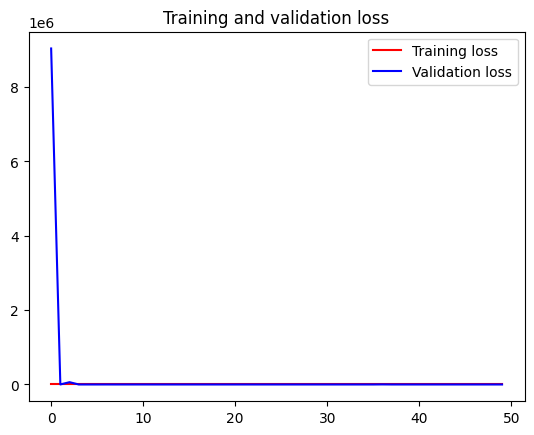

In [6]:
# test run, with cpu

# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_ResNet151V2():
    mod_name = "ResNet151V2"
    resnet_mod = create_model__resnetv2(num_classes)
    summary_model(resnet_mod)
    resnet_mod, hist = train_model(
        resnet_mod, model_name=mod_name, 
        train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr",exist_ok=True)
    resnet_mod.save(f"./models/img_clsr/{mod_name}.keras", overwrite=True)
    resnet_mod.export(f"./models/img_clsr/{mod_name}_asset/")

exec_train_ResNet151V2()

Model: "inception_v3_impl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 20)             │        20,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,312,508 (130.89 MB)

 Trainable params: 34,278,076 (130.76 MB)

 Non-trainable params: 34,432 (134.50 KB)

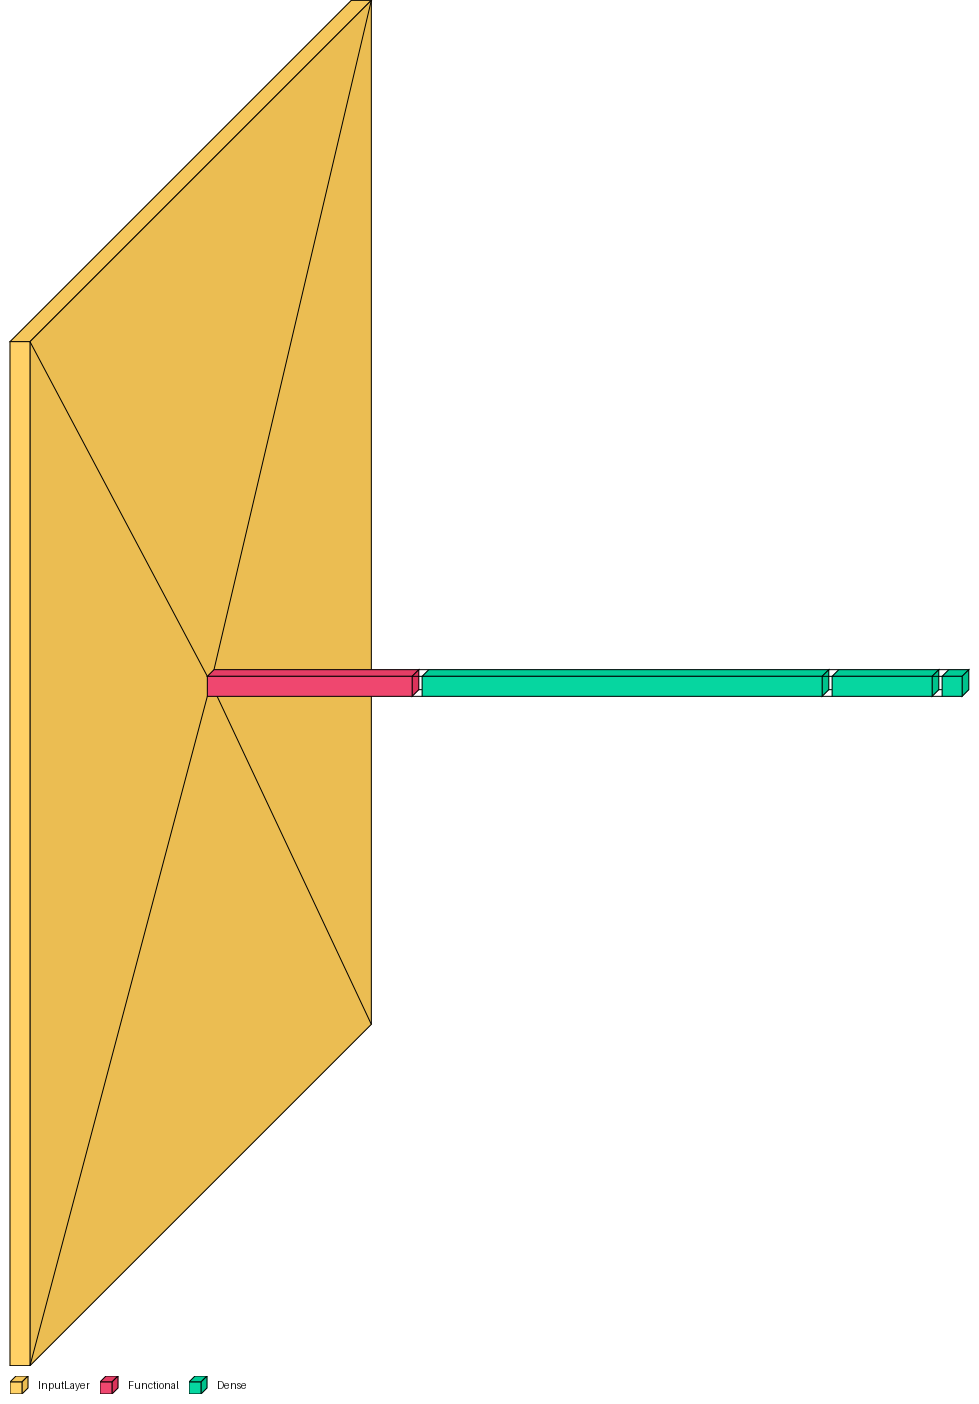

Epoch 1/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 40:34 24s/step - acc: 0.0312 - loss: 3.1310


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.0391 - loss: 4.9622  


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.0434 - loss: 5.3499


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.0482 - loss: 5.3608


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.0510 - loss: 5.2776


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.0521 - loss: 5.1744


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.0523 - loss: 5.0727


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.0531 - loss: 4.9721


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.0553 - loss: 4.8766


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.0569 - loss: 4.7889


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.0590 - loss: 4.7116


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.0604 - loss: 4.6455


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.0615 - loss: 4.5835


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.0630 - loss: 4.5251


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.0645 - loss: 4.4711


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.0658 - loss: 4.4209


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.0669 - loss: 4.3740


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.0679 - loss: 4.3303


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.0688 - loss: 4.2892


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.0695 - loss: 4.2511


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.0703 - loss: 4.2152


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.0711 - loss: 4.1815


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.0718 - loss: 4.1498


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.0725 - loss: 4.1199


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.0732 - loss: 4.0915


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.0737 - loss: 4.0648


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.0742 - loss: 4.0393


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.0746 - loss: 4.0152


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.0749 - loss: 3.9922


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.0753 - loss: 3.9703


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.0759 - loss: 3.9492


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.0764 - loss: 3.9291


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.0769 - loss: 3.9097


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.0773 - loss: 3.8912


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.0777 - loss: 3.8733


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.0781 - loss: 3.8562


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.0785 - loss: 3.8397


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.0788 - loss: 3.8238


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.0791 - loss: 3.8086


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.0794 - loss: 3.7938


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.0798 - loss: 3.7794


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.0802 - loss: 3.7656


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.0806 - loss: 3.7522


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.0810 - loss: 3.7393


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.0814 - loss: 3.7269


 46/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.0818 - loss: 3.7148


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.0822 - loss: 3.7030


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.0826 - loss: 3.6916


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.0830 - loss: 3.6804


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.0834 - loss: 3.6696


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.0837 - loss: 3.6591


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.0841 - loss: 3.6489


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.0844 - loss: 3.6391


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.0846 - loss: 3.6295


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.0849 - loss: 3.6201


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.0851 - loss: 3.6111


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.0853 - loss: 3.6022


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.0855 - loss: 3.5935


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.0857 - loss: 3.5849


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.0860 - loss: 3.5766


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.0863 - loss: 3.5683


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.0865 - loss: 3.5603


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.0867 - loss: 3.5525


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.0870 - loss: 3.5448


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.0872 - loss: 3.5373

2024-05-11 01:21:14.034144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/ghost/anaconda3/envs/uts-dl/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2024-05-11 01:21:23.528671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - acc: 0.0926 - loss: 3.3485 - val_acc: 0.0630 - val_loss: 916.0341


Epoch 2/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 7s/step - acc: 0.1562 - loss: 2.6205


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.1953 - loss: 2.5606 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2031 - loss: 2.5453


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2031 - loss: 2.5495


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.2013 - loss: 2.5503


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.1981 - loss: 2.5492


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.1947 - loss: 2.5514


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.1908 - loss: 2.5555


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.1878 - loss: 2.5596


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.1852 - loss: 2.5646


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.1821 - loss: 2.5701


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.1793 - loss: 2.5740


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.1771 - loss: 2.5773


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.1750 - loss: 2.5807


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.1738 - loss: 2.5824


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.1729 - loss: 2.5838


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.1726 - loss: 2.5840


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.1723 - loss: 2.5840


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.1718 - loss: 2.5843


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.1714 - loss: 2.5845


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.1712 - loss: 2.5843


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.1709 - loss: 2.5839


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.1707 - loss: 2.5836


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.1705 - loss: 2.5838


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.1703 - loss: 2.5839


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.1701 - loss: 2.5837


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.1699 - loss: 2.5836


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.1697 - loss: 2.5832


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - acc: 0.1694 - loss: 2.5827


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - acc: 0.1692 - loss: 2.5823


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 3s/step - acc: 0.1690 - loss: 2.5819


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.1689 - loss: 2.5816


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.1688 - loss: 2.5812


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.1686 - loss: 2.5811


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.1685 - loss: 2.5807


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.1683 - loss: 2.5803


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.1681 - loss: 2.5797


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.1681 - loss: 2.5789


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.1680 - loss: 2.5783


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.1679 - loss: 2.5776


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.1678 - loss: 2.5769


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.1677 - loss: 2.5761


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.1676 - loss: 2.5753


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.1675 - loss: 2.5746


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.1674 - loss: 2.5738


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.1674 - loss: 2.5730


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.1674 - loss: 2.5723


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.1673 - loss: 2.5717


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.1673 - loss: 2.5711


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.1673 - loss: 2.5705


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.1672 - loss: 2.5698


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.1672 - loss: 2.5692


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.1671 - loss: 2.5686


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.1671 - loss: 2.5680


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.1670 - loss: 2.5673


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.1670 - loss: 2.5666


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.1669 - loss: 2.5659


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.1669 - loss: 2.5652


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.1669 - loss: 2.5644


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.1669 - loss: 2.5636


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.1669 - loss: 2.5627


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.1670 - loss: 2.5617


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.1670 - loss: 2.5607


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.1670 - loss: 2.5597


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.1671 - loss: 2.5587

2024-05-11 01:24:00.445266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:24:08.786213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - acc: 0.1684 - loss: 2.5219 - val_acc: 0.0669 - val_loss: 58.9393


Epoch 3/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 7s/step - acc: 0.2812 - loss: 2.2397


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.2812 - loss: 2.2143 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.2639 - loss: 2.2037


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.2585 - loss: 2.1960


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.2568 - loss: 2.2155


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.2548 - loss: 2.2253


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.2541 - loss: 2.2306


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.2516 - loss: 2.2362


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2491 - loss: 2.2411


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.2467 - loss: 2.2452


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2444 - loss: 2.2504


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.2423 - loss: 2.2543


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.2405 - loss: 2.2573


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.2389 - loss: 2.2600


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.2379 - loss: 2.2620


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.2369 - loss: 2.2635


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2358 - loss: 2.2660


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.2353 - loss: 2.2684


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.2348 - loss: 2.2704


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.2344 - loss: 2.2724


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2341 - loss: 2.2744


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2340 - loss: 2.2759


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2341 - loss: 2.2762


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2342 - loss: 2.2767


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2343 - loss: 2.2772


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2344 - loss: 2.2774


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2345 - loss: 2.2778


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2345 - loss: 2.2780


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.2346 - loss: 2.2778


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.2348 - loss: 2.2772


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.2350 - loss: 2.2770


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.2351 - loss: 2.2768


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.2353 - loss: 2.2765


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.2355 - loss: 2.2763


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.2356 - loss: 2.2759


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2358 - loss: 2.2756


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.2360 - loss: 2.2752


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.2361 - loss: 2.2749


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.2363 - loss: 2.2745


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.2365 - loss: 2.2741


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.2368 - loss: 2.2736


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.2369 - loss: 2.2732


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2370 - loss: 2.2728


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2372 - loss: 2.2723


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2373 - loss: 2.2718


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.2375 - loss: 2.2713


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.2377 - loss: 2.2708


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.2378 - loss: 2.2702


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.2379 - loss: 2.2697


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.2379 - loss: 2.2694


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.2379 - loss: 2.2692


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.2378 - loss: 2.2692


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.2377 - loss: 2.2693


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.2375 - loss: 2.2696


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.2373 - loss: 2.2698


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.2371 - loss: 2.2701


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.2369 - loss: 2.2705


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.2367 - loss: 2.2710


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.2365 - loss: 2.2715


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.2363 - loss: 2.2719


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.2361 - loss: 2.2724


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.2359 - loss: 2.2729


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2358 - loss: 2.2734


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.2356 - loss: 2.2739


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2355 - loss: 2.2744

2024-05-11 01:26:37.294795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.2321 - loss: 2.2731 - val_acc: 0.0650 - val_loss: 4320.4473


Epoch 4/50


2024-05-11 01:26:45.645191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 7s/step - acc: 0.1875 - loss: 2.2553


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.1719 - loss: 2.2488 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.1736 - loss: 2.2334


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.1849 - loss: 2.2208


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.1917 - loss: 2.2169


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.1953 - loss: 2.2129


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.1987 - loss: 2.2165


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.2031 - loss: 2.2177


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.2060 - loss: 2.2196


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.2095 - loss: 2.2210


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.2129 - loss: 2.2218


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.2164 - loss: 2.2215


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.2201 - loss: 2.2198


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.2231 - loss: 2.2172


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.2258 - loss: 2.2145


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.2284 - loss: 2.2110


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.2308 - loss: 2.2082


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.2328 - loss: 2.2050


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.2348 - loss: 2.2020


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.2366 - loss: 2.1990


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.2383 - loss: 2.1956


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.2400 - loss: 2.1922


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.2416 - loss: 2.1897


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.2430 - loss: 2.1873


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.2443 - loss: 2.1853


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.2454 - loss: 2.1837


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.2464 - loss: 2.1827


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.2473 - loss: 2.1814


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.2481 - loss: 2.1804


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.2489 - loss: 2.1798


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.2497 - loss: 2.1793


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.2505 - loss: 2.1796


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.2512 - loss: 2.1796


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.2521 - loss: 2.1794


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.2529 - loss: 2.1790


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.2536 - loss: 2.1785


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.2544 - loss: 2.1780


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.2551 - loss: 2.1773


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.2558 - loss: 2.1767


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.2565 - loss: 2.1760


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.2571 - loss: 2.1752


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.2577 - loss: 2.1744


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.2582 - loss: 2.1738


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.2588 - loss: 2.1731


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.2593 - loss: 2.1726


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.2597 - loss: 2.1721


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.2601 - loss: 2.1716


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.2605 - loss: 2.1713


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.2609 - loss: 2.1710


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.2613 - loss: 2.1706


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.2618 - loss: 2.1702


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.2622 - loss: 2.1696


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.2626 - loss: 2.1691


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.2631 - loss: 2.1684


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.2635 - loss: 2.1677


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.2640 - loss: 2.1670


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.2644 - loss: 2.1664


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.2648 - loss: 2.1657


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.2652 - loss: 2.1651


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.2657 - loss: 2.1644


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.2662 - loss: 2.1636


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.2667 - loss: 2.1628


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.2673 - loss: 2.1619


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.2679 - loss: 2.1609


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.2685 - loss: 2.1599

2024-05-11 01:29:14.332124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.2819 - loss: 2.1247 - val_acc: 0.0866 - val_loss: 106.6710


Epoch 5/50


2024-05-11 01:29:22.686265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 7s/step - acc: 0.5000 - loss: 1.5439


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.4531 - loss: 1.6095 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.4375 - loss: 1.7033


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4258 - loss: 1.7540


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4181 - loss: 1.7916


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4144 - loss: 1.8083


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.4103 - loss: 1.8237


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4028 - loss: 1.8383


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.3956 - loss: 1.8519


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.3912 - loss: 1.8586


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.3865 - loss: 1.8649


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.3829 - loss: 1.8685


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.3800 - loss: 1.8720


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.3781 - loss: 1.8738


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.3771 - loss: 1.8746


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.3762 - loss: 1.8755


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.3753 - loss: 1.8767


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.3742 - loss: 1.8778


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.3736 - loss: 1.8779


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.3729 - loss: 1.8776


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.3723 - loss: 1.8775


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.3715 - loss: 1.8777


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.3707 - loss: 1.8779


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.3702 - loss: 1.8782


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.3698 - loss: 1.8785


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.3691 - loss: 1.8790


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.3685 - loss: 1.8794


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.3678 - loss: 1.8801


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.3673 - loss: 1.8806


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.3670 - loss: 1.8808


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.3668 - loss: 1.8811


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.3665 - loss: 1.8814


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.3664 - loss: 1.8814


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.3663 - loss: 1.8815


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.3662 - loss: 1.8813


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.3662 - loss: 1.8810


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.3664 - loss: 1.8803


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.3666 - loss: 1.8797


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.3668 - loss: 1.8789


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.3669 - loss: 1.8781


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.3672 - loss: 1.8773


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.3673 - loss: 1.8770


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.3675 - loss: 1.8765


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.3677 - loss: 1.8759


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.3679 - loss: 1.8753


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.3681 - loss: 1.8749


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.3683 - loss: 1.8743


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.3685 - loss: 1.8739


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.3686 - loss: 1.8735


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.3688 - loss: 1.8731


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.3690 - loss: 1.8726


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.3692 - loss: 1.8721


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.3695 - loss: 1.8716


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.3697 - loss: 1.8709


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.3699 - loss: 1.8702


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.3701 - loss: 1.8696


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.3703 - loss: 1.8689


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.3705 - loss: 1.8682


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.3706 - loss: 1.8674


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.3708 - loss: 1.8667


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.3710 - loss: 1.8658


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.3712 - loss: 1.8651


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.3715 - loss: 1.8643


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.3718 - loss: 1.8635


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.3721 - loss: 1.8627

2024-05-11 01:31:51.157193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:31:59.451316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.3792 - loss: 1.8338 - val_acc: 0.2028 - val_loss: 5.7003


Epoch 6/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 7s/step - acc: 0.4375 - loss: 1.7699


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.4453 - loss: 1.6910 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.4462 - loss: 1.6682


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.4518 - loss: 1.6567


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4540 - loss: 1.6494


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4573 - loss: 1.6434


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.4577 - loss: 1.6428


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.4566 - loss: 1.6494


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.4564 - loss: 1.6496


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.4570 - loss: 1.6510


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.4583 - loss: 1.6508


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.4586 - loss: 1.6509


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4584 - loss: 1.6535


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4584 - loss: 1.6550


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4585 - loss: 1.6558


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4586 - loss: 1.6564


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.4584 - loss: 1.6571


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4577 - loss: 1.6586


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4572 - loss: 1.6603


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4566 - loss: 1.6621


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4562 - loss: 1.6635


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4559 - loss: 1.6644


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.4557 - loss: 1.6649


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.4556 - loss: 1.6654


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4556 - loss: 1.6656


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4556 - loss: 1.6657


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4557 - loss: 1.6655


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4559 - loss: 1.6651


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4560 - loss: 1.6648


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4560 - loss: 1.6647


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.4561 - loss: 1.6646


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.4561 - loss: 1.6648


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.4561 - loss: 1.6648


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.4561 - loss: 1.6648


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.4562 - loss: 1.6649


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4563 - loss: 1.6649


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4563 - loss: 1.6651


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4562 - loss: 1.6656


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4561 - loss: 1.6661


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.4561 - loss: 1.6663


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.4560 - loss: 1.6665


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4561 - loss: 1.6664


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4562 - loss: 1.6660


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4563 - loss: 1.6659


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4563 - loss: 1.6657


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4563 - loss: 1.6655


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.4564 - loss: 1.6653


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4564 - loss: 1.6652


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4564 - loss: 1.6651


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4564 - loss: 1.6650


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4564 - loss: 1.6648


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.4564 - loss: 1.6645


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4565 - loss: 1.6642


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4565 - loss: 1.6640


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4566 - loss: 1.6637


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4567 - loss: 1.6632


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4569 - loss: 1.6628


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4570 - loss: 1.6624


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4571 - loss: 1.6621


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4572 - loss: 1.6619


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4573 - loss: 1.6616


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.4574 - loss: 1.6615


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4575 - loss: 1.6612


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4575 - loss: 1.6611


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4576 - loss: 1.6609

2024-05-11 01:34:28.152664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:34:36.545208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.4588 - loss: 1.6474 - val_acc: 0.2461 - val_loss: 3.0817


Epoch 7/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:39 7s/step - acc: 0.5312 - loss: 1.5141


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.4922 - loss: 1.5042 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.4705 - loss: 1.5079


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.4622 - loss: 1.5133


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4548 - loss: 1.5359


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4554 - loss: 1.5455


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.4537 - loss: 1.5632


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4550 - loss: 1.5728


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.4578 - loss: 1.5754


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4595 - loss: 1.5756


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4625 - loss: 1.5731


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.4646 - loss: 1.5727


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.4645 - loss: 1.5754


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.4646 - loss: 1.5755


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4643 - loss: 1.5758


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.4642 - loss: 1.5751


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.4641 - loss: 1.5742


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.4637 - loss: 1.5738


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.4634 - loss: 1.5731


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.4632 - loss: 1.5729


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.4633 - loss: 1.5722


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4633 - loss: 1.5713


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.4633 - loss: 1.5707


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.4635 - loss: 1.5701


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4636 - loss: 1.5696


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.4638 - loss: 1.5687


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.4638 - loss: 1.5689


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.4639 - loss: 1.5691


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.4637 - loss: 1.5699


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.4634 - loss: 1.5708


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4631 - loss: 1.5717


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4629 - loss: 1.5722


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4627 - loss: 1.5725


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4626 - loss: 1.5729


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4624 - loss: 1.5734


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.4622 - loss: 1.5740


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.4620 - loss: 1.5745


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4618 - loss: 1.5750


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4616 - loss: 1.5754


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4616 - loss: 1.5756


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.4616 - loss: 1.5755


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.4617 - loss: 1.5753


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4617 - loss: 1.5751


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4619 - loss: 1.5748


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4620 - loss: 1.5745


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4621 - loss: 1.5744


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4622 - loss: 1.5741


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.4624 - loss: 1.5738


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4624 - loss: 1.5735


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4625 - loss: 1.5733


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4626 - loss: 1.5732


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4626 - loss: 1.5732


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.4627 - loss: 1.5731


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4627 - loss: 1.5731


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4628 - loss: 1.5730


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4628 - loss: 1.5730


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4628 - loss: 1.5730


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4629 - loss: 1.5729


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4629 - loss: 1.5729


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4630 - loss: 1.5730


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4630 - loss: 1.5730


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4630 - loss: 1.5730


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4631 - loss: 1.5730


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4631 - loss: 1.5732


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4631 - loss: 1.5735

2024-05-11 01:37:05.100262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.4629 - loss: 1.5718 - val_acc: 0.2717 - val_loss: 6.1887


Epoch 8/50


2024-05-11 01:37:13.418038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:24 7s/step - acc: 0.3438 - loss: 1.6968


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.4141 - loss: 1.6190 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.4392 - loss: 1.5828


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.4544 - loss: 1.5567


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.4673 - loss: 1.5346


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.4736 - loss: 1.5261


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4787 - loss: 1.5174


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.4808 - loss: 1.5156


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.4834 - loss: 1.5129


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.4866 - loss: 1.5118


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.4899 - loss: 1.5085


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.4920 - loss: 1.5103


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.4934 - loss: 1.5109


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.4951 - loss: 1.5105


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.4960 - loss: 1.5109


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.4960 - loss: 1.5135


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.4963 - loss: 1.5142


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.4962 - loss: 1.5157


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.4965 - loss: 1.5160


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.4968 - loss: 1.5169


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.4967 - loss: 1.5188


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.4969 - loss: 1.5197


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.4972 - loss: 1.5202


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.4973 - loss: 1.5215


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.4974 - loss: 1.5223


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.4975 - loss: 1.5234


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.4976 - loss: 1.5242


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.4979 - loss: 1.5251


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.4979 - loss: 1.5260


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.4977 - loss: 1.5272


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.4976 - loss: 1.5283


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.4974 - loss: 1.5291


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.4973 - loss: 1.5298


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.4971 - loss: 1.5306


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.4970 - loss: 1.5311


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.4969 - loss: 1.5319


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.4969 - loss: 1.5328


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.4968 - loss: 1.5335


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.4967 - loss: 1.5345


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.4967 - loss: 1.5353


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.4966 - loss: 1.5362


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.4964 - loss: 1.5371


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.4963 - loss: 1.5380


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.4962 - loss: 1.5387


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.4962 - loss: 1.5390


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.4962 - loss: 1.5394


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.4961 - loss: 1.5398


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.4960 - loss: 1.5403


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.4960 - loss: 1.5407


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.4960 - loss: 1.5409


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.4960 - loss: 1.5413


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.4959 - loss: 1.5415


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.4959 - loss: 1.5418


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.4958 - loss: 1.5419


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.4958 - loss: 1.5421


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.4957 - loss: 1.5422


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.4957 - loss: 1.5423


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.4957 - loss: 1.5422


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.4957 - loss: 1.5422


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.4957 - loss: 1.5422


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.4958 - loss: 1.5421


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.4958 - loss: 1.5422


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.4958 - loss: 1.5421


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.4959 - loss: 1.5421


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.4959 - loss: 1.5421

2024-05-11 01:39:41.417278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:39:49.772041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.4971 - loss: 1.5338 - val_acc: 0.4370 - val_loss: 2.1807


Epoch 9/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 7s/step - acc: 0.4062 - loss: 1.5056


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.4688 - loss: 1.4892 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.4826 - loss: 1.4988


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.4811 - loss: 1.5125


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.4836 - loss: 1.5033


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.4872 - loss: 1.4908


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.4923 - loss: 1.4809


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.4991 - loss: 1.4687


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.5046 - loss: 1.4583


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.5091 - loss: 1.4504


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.5135 - loss: 1.4448


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.5171 - loss: 1.4397


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.5200 - loss: 1.4352


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.5223 - loss: 1.4322


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.5251 - loss: 1.4265


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.5277 - loss: 1.4207


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.5301 - loss: 1.4152


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.5321 - loss: 1.4105


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.5344 - loss: 1.4049


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.5367 - loss: 1.3991


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.5388 - loss: 1.3936


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.5408 - loss: 1.3881


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.5422 - loss: 1.3839


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.5434 - loss: 1.3802


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.5446 - loss: 1.3771


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.5455 - loss: 1.3744


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.5462 - loss: 1.3718


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.5470 - loss: 1.3691


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.5476 - loss: 1.3667


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.5484 - loss: 1.3641


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.5489 - loss: 1.3620


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.5493 - loss: 1.3602


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.5497 - loss: 1.3587


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.5500 - loss: 1.3574


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.5502 - loss: 1.3563


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.5503 - loss: 1.3556


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.5504 - loss: 1.3551


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.5505 - loss: 1.3547


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.5506 - loss: 1.3544


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.5506 - loss: 1.3542


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.5508 - loss: 1.3540


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.5509 - loss: 1.3540


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.5510 - loss: 1.3541


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.5510 - loss: 1.3541


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.5511 - loss: 1.3542


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.5512 - loss: 1.3543


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.5513 - loss: 1.3543


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.5515 - loss: 1.3544


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.5517 - loss: 1.3544


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.5519 - loss: 1.3544


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.5521 - loss: 1.3544


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.5522 - loss: 1.3544


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.5522 - loss: 1.3545


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.5523 - loss: 1.3545


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.5523 - loss: 1.3547


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.5523 - loss: 1.3549


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5524 - loss: 1.3550


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5523 - loss: 1.3552


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.5523 - loss: 1.3554


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.5523 - loss: 1.3555


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.5523 - loss: 1.3556


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.5524 - loss: 1.3555


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.5524 - loss: 1.3554


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.5525 - loss: 1.3552


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.5526 - loss: 1.3549

2024-05-11 01:42:18.703966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:42:27.024092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.5547 - loss: 1.3424 - val_acc: 0.5236 - val_loss: 1.4073


Epoch 10/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 7s/step - acc: 0.5000 - loss: 1.4453


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - acc: 0.5469 - loss: 1.2881 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.5486 - loss: 1.3176


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.5443 - loss: 1.3310


  5/101 ━━━━━━━━━━━━━━━━━━━━ 10:34 7s/step - acc: 0.5404 - loss: 1.3446


  6/101 ━━━━━━━━━━━━━━━━━━━━ 9:10 6s/step - acc: 0.5303 - loss: 1.3675 


  7/101 ━━━━━━━━━━━━━━━━━━━━ 8:08 5s/step - acc: 0.5263 - loss: 1.3808


  8/101 ━━━━━━━━━━━━━━━━━━━━ 7:23 5s/step - acc: 0.5243 - loss: 1.3936


  9/101 ━━━━━━━━━━━━━━━━━━━━ 6:48 4s/step - acc: 0.5235 - loss: 1.4030


 10/101 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - acc: 0.5213 - loss: 1.4143


 11/101 ━━━━━━━━━━━━━━━━━━━━ 5:59 4s/step - acc: 0.5195 - loss: 1.4248


 12/101 ━━━━━━━━━━━━━━━━━━━━ 5:40 4s/step - acc: 0.5194 - loss: 1.4287


 13/101 ━━━━━━━━━━━━━━━━━━━━ 5:25 4s/step - acc: 0.5191 - loss: 1.4316


 14/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - acc: 0.5193 - loss: 1.4333


 15/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 3s/step - acc: 0.5191 - loss: 1.4352


 16/101 ━━━━━━━━━━━━━━━━━━━━ 4:48 3s/step - acc: 0.5192 - loss: 1.4362


 17/101 ━━━━━━━━━━━━━━━━━━━━ 4:38 3s/step - acc: 0.5194 - loss: 1.4362


 18/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - acc: 0.5197 - loss: 1.4360


 19/101 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - acc: 0.5200 - loss: 1.4351


 20/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - acc: 0.5200 - loss: 1.4344


 21/101 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - acc: 0.5201 - loss: 1.4333


 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:01 3s/step - acc: 0.5205 - loss: 1.4318


 23/101 ━━━━━━━━━━━━━━━━━━━━ 3:55 3s/step - acc: 0.5207 - loss: 1.4308


 24/101 ━━━━━━━━━━━━━━━━━━━━ 3:49 3s/step - acc: 0.5209 - loss: 1.4303


 25/101 ━━━━━━━━━━━━━━━━━━━━ 3:44 3s/step - acc: 0.5211 - loss: 1.4297


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - acc: 0.5210 - loss: 1.4295


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - acc: 0.5212 - loss: 1.4287


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - acc: 0.5213 - loss: 1.4280


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - acc: 0.5215 - loss: 1.4273


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - acc: 0.5218 - loss: 1.4264


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - acc: 0.5221 - loss: 1.4256


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - acc: 0.5224 - loss: 1.4249


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 3s/step - acc: 0.5226 - loss: 1.4242


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - acc: 0.5229 - loss: 1.4235


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.5232 - loss: 1.4228


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - acc: 0.5234 - loss: 1.4221


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.5236 - loss: 1.4215


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - acc: 0.5237 - loss: 1.4210


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - acc: 0.5239 - loss: 1.4203


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - acc: 0.5241 - loss: 1.4197


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.5244 - loss: 1.4189


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.5247 - loss: 1.4181


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.5249 - loss: 1.4175


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.5251 - loss: 1.4168


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.5255 - loss: 1.4159


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - acc: 0.5258 - loss: 1.4150


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.5262 - loss: 1.4140


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.5266 - loss: 1.4130


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - acc: 0.5270 - loss: 1.4120


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.5274 - loss: 1.4110


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - acc: 0.5279 - loss: 1.4099


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.5284 - loss: 1.4086


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.5289 - loss: 1.4074


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.5295 - loss: 1.4061


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - acc: 0.5300 - loss: 1.4047


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.5306 - loss: 1.4032


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.5312 - loss: 1.4020


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.5317 - loss: 1.4007


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.5323 - loss: 1.3994


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.5328 - loss: 1.3982


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.5333 - loss: 1.3970


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.5338 - loss: 1.3959


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.5343 - loss: 1.3948


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.5347 - loss: 1.3937


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.5352 - loss: 1.3926

2024-05-11 01:45:13.550071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - acc: 0.5455 - loss: 1.3603 - val_acc: 0.3307 - val_loss: 2.4636


Epoch 11/50


2024-05-11 01:45:21.904501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 7s/step - acc: 0.7188 - loss: 1.2274


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.7188 - loss: 1.2039 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.6979 - loss: 1.1978


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.6816 - loss: 1.1893


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6703 - loss: 1.1781


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.6602 - loss: 1.1752


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6519 - loss: 1.1780


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.6442 - loss: 1.1842


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.6382 - loss: 1.1859


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6325 - loss: 1.1921


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6287 - loss: 1.1949


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6269 - loss: 1.1961


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6258 - loss: 1.1962


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6242 - loss: 1.1974


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6231 - loss: 1.1971


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6221 - loss: 1.1968


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6213 - loss: 1.1960


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6205 - loss: 1.1957


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6201 - loss: 1.1946


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6196 - loss: 1.1945


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6193 - loss: 1.1943


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6189 - loss: 1.1944


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6187 - loss: 1.1937


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6183 - loss: 1.1943


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6182 - loss: 1.1943


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.6184 - loss: 1.1938


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.6186 - loss: 1.1931


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.6188 - loss: 1.1923


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6189 - loss: 1.1916


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6190 - loss: 1.1913


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6189 - loss: 1.1909


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6190 - loss: 1.1903


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6193 - loss: 1.1895


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6194 - loss: 1.1888


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6197 - loss: 1.1880


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6198 - loss: 1.1875


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6199 - loss: 1.1871


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.6200 - loss: 1.1867


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.6201 - loss: 1.1862


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6200 - loss: 1.1860


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6199 - loss: 1.1858


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6199 - loss: 1.1854


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.6198 - loss: 1.1853


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.6196 - loss: 1.1854


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.6194 - loss: 1.1857


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.6193 - loss: 1.1858


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.6191 - loss: 1.1857


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.6190 - loss: 1.1858


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.6188 - loss: 1.1859


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.6186 - loss: 1.1860


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.6185 - loss: 1.1861


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.6183 - loss: 1.1861


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.6181 - loss: 1.1860


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.6180 - loss: 1.1859


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.6178 - loss: 1.1858


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6177 - loss: 1.1855


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.6177 - loss: 1.1852


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6176 - loss: 1.1851


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6175 - loss: 1.1849


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6174 - loss: 1.1848


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.6173 - loss: 1.1846


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6172 - loss: 1.1843


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6171 - loss: 1.1840


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6171 - loss: 1.1837


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6171 - loss: 1.1834

2024-05-11 01:47:49.904342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.6164 - loss: 1.1695 - val_acc: 0.4409 - val_loss: 1.9353


Epoch 12/50


2024-05-11 01:47:58.259753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:14 7s/step - acc: 0.5938 - loss: 1.2891


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - acc: 0.6172 - loss: 1.2155 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6302 - loss: 1.1949


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6348 - loss: 1.1885


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.6378 - loss: 1.1846


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.6348 - loss: 1.1918


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6309 - loss: 1.1981


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6282 - loss: 1.2019


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6259 - loss: 1.2060


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.6261 - loss: 1.2062


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6276 - loss: 1.2038


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6280 - loss: 1.2038


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6292 - loss: 1.2009


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6305 - loss: 1.1984


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6310 - loss: 1.1996


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.6311 - loss: 1.2010


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6308 - loss: 1.2027


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6307 - loss: 1.2033


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.6307 - loss: 1.2033


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.6310 - loss: 1.2024


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6311 - loss: 1.2015


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6310 - loss: 1.2015


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6309 - loss: 1.2010


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6309 - loss: 1.2005


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6308 - loss: 1.2000


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6309 - loss: 1.1990


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6309 - loss: 1.1982


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6309 - loss: 1.1972


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6309 - loss: 1.1962


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6309 - loss: 1.1953


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6310 - loss: 1.1941


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6312 - loss: 1.1927


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6314 - loss: 1.1911


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6316 - loss: 1.1895


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6318 - loss: 1.1881


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6321 - loss: 1.1864


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6325 - loss: 1.1846


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6328 - loss: 1.1830


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6332 - loss: 1.1813


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6337 - loss: 1.1794


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6341 - loss: 1.1776


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6346 - loss: 1.1757


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6350 - loss: 1.1740


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6353 - loss: 1.1724


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6356 - loss: 1.1708


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.6360 - loss: 1.1692


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6363 - loss: 1.1677


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6365 - loss: 1.1663


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6368 - loss: 1.1651


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6370 - loss: 1.1639


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6373 - loss: 1.1629


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6375 - loss: 1.1619


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6376 - loss: 1.1610


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6377 - loss: 1.1602


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6378 - loss: 1.1595


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6378 - loss: 1.1590


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6379 - loss: 1.1584


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6380 - loss: 1.1578


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6380 - loss: 1.1572


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6381 - loss: 1.1565


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6382 - loss: 1.1560


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6383 - loss: 1.1555


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6384 - loss: 1.1550


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6384 - loss: 1.1545


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6385 - loss: 1.1540

2024-05-11 01:50:26.472812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.6402 - loss: 1.1371 - val_acc: 0.4409 - val_loss: 2.0249


Epoch 13/50


2024-05-11 01:50:34.760641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.5625 - loss: 1.3061


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.6250 - loss: 1.1798 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6562 - loss: 1.1079


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6758 - loss: 1.0750


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.6869 - loss: 1.0568


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.6905 - loss: 1.0498


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.6894 - loss: 1.0621


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.6877 - loss: 1.0743


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.6881 - loss: 1.0778


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.6877 - loss: 1.0807


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.6877 - loss: 1.0821


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.6879 - loss: 1.0816


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.6867 - loss: 1.0861


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6855 - loss: 1.0901


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6843 - loss: 1.0936


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6829 - loss: 1.0968


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.6820 - loss: 1.0983


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6814 - loss: 1.0989


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.6812 - loss: 1.0983


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.6810 - loss: 1.0977


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.6808 - loss: 1.0968


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6806 - loss: 1.0966


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6804 - loss: 1.0963


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.6803 - loss: 1.0958


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6800 - loss: 1.0957


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6798 - loss: 1.0951


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.6795 - loss: 1.0948


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6794 - loss: 1.0938


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6790 - loss: 1.0937


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6786 - loss: 1.0934


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.6781 - loss: 1.0932


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.6776 - loss: 1.0928


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.6771 - loss: 1.0927


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.6764 - loss: 1.0927


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6758 - loss: 1.0926


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6753 - loss: 1.0923


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6748 - loss: 1.0919


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6745 - loss: 1.0912


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.6743 - loss: 1.0905


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.6740 - loss: 1.0898


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6737 - loss: 1.0890


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6733 - loss: 1.0883


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6730 - loss: 1.0876


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6727 - loss: 1.0870


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6723 - loss: 1.0864


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6720 - loss: 1.0858


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6717 - loss: 1.0852


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6715 - loss: 1.0846


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6712 - loss: 1.0840


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6710 - loss: 1.0834


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.6707 - loss: 1.0830


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6704 - loss: 1.0824


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6702 - loss: 1.0820


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6699 - loss: 1.0817


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6697 - loss: 1.0812


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6695 - loss: 1.0809


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6693 - loss: 1.0805


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6691 - loss: 1.0803


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6688 - loss: 1.0800


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6686 - loss: 1.0796


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6684 - loss: 1.0793


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6682 - loss: 1.0790


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6680 - loss: 1.0787


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6678 - loss: 1.0785


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6676 - loss: 1.0783

2024-05-11 01:53:02.928704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 01:53:11.216119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.6628 - loss: 1.0671 - val_acc: 0.5748 - val_loss: 1.3449


Epoch 14/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:26 7s/step - acc: 0.6562 - loss: 1.1001


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6641 - loss: 1.0318 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.6684 - loss: 0.9824


  4/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.6664 - loss: 0.9980


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6707 - loss: 0.9902


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6669 - loss: 0.9966


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6608 - loss: 1.0068


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6568 - loss: 1.0110


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6553 - loss: 1.0114


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.6539 - loss: 1.0137


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6523 - loss: 1.0159


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.6525 - loss: 1.0155


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.6527 - loss: 1.0150


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.6532 - loss: 1.0152


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6535 - loss: 1.0154


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.6538 - loss: 1.0144


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.6539 - loss: 1.0140


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.6542 - loss: 1.0133


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.6542 - loss: 1.0131


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.6542 - loss: 1.0139


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.6540 - loss: 1.0154


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.6538 - loss: 1.0170


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.6539 - loss: 1.0180


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.6539 - loss: 1.0195


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.6540 - loss: 1.0206


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.6540 - loss: 1.0215


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.6541 - loss: 1.0221


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.6543 - loss: 1.0227


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.6543 - loss: 1.0234


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.6545 - loss: 1.0237


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6545 - loss: 1.0242


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.6544 - loss: 1.0251


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.6543 - loss: 1.0263


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.6542 - loss: 1.0275


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.6541 - loss: 1.0286


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.6541 - loss: 1.0295


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.6541 - loss: 1.0304


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.6540 - loss: 1.0314


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.6539 - loss: 1.0324


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.6540 - loss: 1.0330


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.6539 - loss: 1.0338


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.6540 - loss: 1.0344


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.6541 - loss: 1.0349


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.6542 - loss: 1.0351


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.6544 - loss: 1.0352


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.6545 - loss: 1.0356


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.6545 - loss: 1.0360


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.6545 - loss: 1.0362


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.6546 - loss: 1.0365


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.6546 - loss: 1.0368


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.6547 - loss: 1.0370


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.6547 - loss: 1.0370


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.6549 - loss: 1.0371


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.6550 - loss: 1.0372


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.6551 - loss: 1.0372


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.6552 - loss: 1.0373


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.6553 - loss: 1.0372


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.6554 - loss: 1.0372


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.6555 - loss: 1.0371


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.6557 - loss: 1.0370


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.6559 - loss: 1.0367


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.6560 - loss: 1.0365


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.6562 - loss: 1.0362


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.6564 - loss: 1.0358


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.6566 - loss: 1.0354

2024-05-11 01:55:39.184404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.6614 - loss: 1.0204 - val_acc: 0.5472 - val_loss: 1.6853


Epoch 15/50


2024-05-11 01:55:47.436403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:13 7s/step - acc: 0.7812 - loss: 0.7096


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7578 - loss: 0.9190 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7622 - loss: 0.9658


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7630 - loss: 0.9724


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.7579 - loss: 0.9684


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7540 - loss: 0.9667


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7509 - loss: 0.9732


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7488 - loss: 0.9756


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.7462 - loss: 0.9797


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7438 - loss: 0.9821


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7418 - loss: 0.9835


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7399 - loss: 0.9844


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7386 - loss: 0.9840


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7374 - loss: 0.9834


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7363 - loss: 0.9819


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7350 - loss: 0.9805


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7338 - loss: 0.9796


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7327 - loss: 0.9787


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7317 - loss: 0.9783


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7308 - loss: 0.9773


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7297 - loss: 0.9766


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7287 - loss: 0.9758


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7278 - loss: 0.9748


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7270 - loss: 0.9740


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7262 - loss: 0.9737


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7255 - loss: 0.9734


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7248 - loss: 0.9733


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7242 - loss: 0.9731


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7233 - loss: 0.9738


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7224 - loss: 0.9746


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7216 - loss: 0.9751


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7210 - loss: 0.9759


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.7203 - loss: 0.9766


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7197 - loss: 0.9775


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7189 - loss: 0.9786


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7182 - loss: 0.9797


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7175 - loss: 0.9809


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7168 - loss: 0.9821


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7161 - loss: 0.9833


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7154 - loss: 0.9847


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7147 - loss: 0.9862


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7140 - loss: 0.9875


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.7134 - loss: 0.9888


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7127 - loss: 0.9898


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7122 - loss: 0.9908


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7118 - loss: 0.9916


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7113 - loss: 0.9923


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7109 - loss: 0.9929


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7104 - loss: 0.9935


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7100 - loss: 0.9941


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7096 - loss: 0.9946


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7092 - loss: 0.9952


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7088 - loss: 0.9956


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7084 - loss: 0.9960


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7081 - loss: 0.9963


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7077 - loss: 0.9967


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7074 - loss: 0.9970


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7070 - loss: 0.9974


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7066 - loss: 0.9979


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7062 - loss: 0.9984


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.7058 - loss: 0.9988


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.7055 - loss: 0.9992


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7052 - loss: 0.9995


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7049 - loss: 0.9997


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7046 - loss: 0.9998

2024-05-11 01:58:15.972346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.6989 - loss: 0.9979 - val_acc: 0.4862 - val_loss: 1.9393


Epoch 16/50


2024-05-11 01:58:24.321856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:19 7s/step - acc: 0.7188 - loss: 0.9252


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.6953 - loss: 0.9256 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.6997 - loss: 0.9156


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7044 - loss: 0.9232


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7110 - loss: 0.9196


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7158 - loss: 0.9209


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7156 - loss: 0.9268


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7160 - loss: 0.9250


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7174 - loss: 0.9203


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7188 - loss: 0.9159


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7183 - loss: 0.9145


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7181 - loss: 0.9118


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7184 - loss: 0.9087


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7184 - loss: 0.9054


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7187 - loss: 0.9012


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7188 - loss: 0.8972


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7188 - loss: 0.8943


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7185 - loss: 0.8920


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7183 - loss: 0.8904


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7177 - loss: 0.8891


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7172 - loss: 0.8876


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7164 - loss: 0.8868


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7160 - loss: 0.8857


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7154 - loss: 0.8851


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7149 - loss: 0.8844


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7145 - loss: 0.8837


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7140 - loss: 0.8835


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7135 - loss: 0.8835


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7131 - loss: 0.8836


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7127 - loss: 0.8836


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7124 - loss: 0.8836


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7122 - loss: 0.8835


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7120 - loss: 0.8838


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7117 - loss: 0.8842


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7115 - loss: 0.8846


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7112 - loss: 0.8852


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7109 - loss: 0.8857


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7106 - loss: 0.8863


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7103 - loss: 0.8871


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7101 - loss: 0.8876


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7098 - loss: 0.8880


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.7095 - loss: 0.8885


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.7092 - loss: 0.8891


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7090 - loss: 0.8895


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7087 - loss: 0.8900


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7084 - loss: 0.8905


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7082 - loss: 0.8909


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7080 - loss: 0.8913


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7077 - loss: 0.8919


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7074 - loss: 0.8926


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7072 - loss: 0.8931


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7070 - loss: 0.8936


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7068 - loss: 0.8940


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7067 - loss: 0.8944


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7065 - loss: 0.8948


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7063 - loss: 0.8953


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7062 - loss: 0.8958


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7061 - loss: 0.8961


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7060 - loss: 0.8965


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7058 - loss: 0.8970


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.7057 - loss: 0.8974


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7056 - loss: 0.8977


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7055 - loss: 0.8981


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7053 - loss: 0.8985


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7052 - loss: 0.8989

2024-05-11 02:00:52.594800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.7025 - loss: 0.9028 - val_acc: 0.4764 - val_loss: 1.9622


Epoch 17/50


2024-05-11 02:01:00.964408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.7500 - loss: 0.8960


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.7344 - loss: 0.9093 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7326 - loss: 0.9101


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.7233 - loss: 0.9184


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7224 - loss: 0.9079


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7218 - loss: 0.9043


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7220 - loss: 0.8971


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7216 - loss: 0.8937


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7205 - loss: 0.8921


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7206 - loss: 0.8881


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7202 - loss: 0.8861


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7192 - loss: 0.8845


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7179 - loss: 0.8833


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7165 - loss: 0.8839


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7156 - loss: 0.8836


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7150 - loss: 0.8828


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7148 - loss: 0.8820


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7144 - loss: 0.8824


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7137 - loss: 0.8831


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7132 - loss: 0.8829


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7128 - loss: 0.8825


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7125 - loss: 0.8821


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7122 - loss: 0.8818


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7122 - loss: 0.8815


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7121 - loss: 0.8816


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7120 - loss: 0.8818


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.7120 - loss: 0.8817


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7119 - loss: 0.8819


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7119 - loss: 0.8818


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7118 - loss: 0.8818


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7116 - loss: 0.8826


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7113 - loss: 0.8835


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7111 - loss: 0.8843


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7109 - loss: 0.8850


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7109 - loss: 0.8856


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7109 - loss: 0.8859


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7109 - loss: 0.8863


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7110 - loss: 0.8865


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7111 - loss: 0.8867


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7112 - loss: 0.8869


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7112 - loss: 0.8873


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7113 - loss: 0.8876


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7113 - loss: 0.8881


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7114 - loss: 0.8884


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7114 - loss: 0.8887


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7115 - loss: 0.8891


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7116 - loss: 0.8893


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7117 - loss: 0.8897


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7117 - loss: 0.8901


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7117 - loss: 0.8904


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7117 - loss: 0.8907


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7118 - loss: 0.8910


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7118 - loss: 0.8914


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7118 - loss: 0.8918


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7118 - loss: 0.8923


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7118 - loss: 0.8926


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7119 - loss: 0.8928


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7119 - loss: 0.8930


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7120 - loss: 0.8930


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7122 - loss: 0.8930


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.7123 - loss: 0.8930


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7124 - loss: 0.8929


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7125 - loss: 0.8930


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7126 - loss: 0.8930


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7127 - loss: 0.8930

2024-05-11 02:03:29.396179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.7148 - loss: 0.8876 - val_acc: 0.5531 - val_loss: 1.7223


Epoch 18/50


2024-05-11 02:03:37.628674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:36 7s/step - acc: 0.6875 - loss: 0.9224


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.6953 - loss: 0.9355 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.6843 - loss: 1.0177


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.6761 - loss: 1.0452


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6770 - loss: 1.0616


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6808 - loss: 1.0598


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6846 - loss: 1.0578


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6876 - loss: 1.0546


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.6897 - loss: 1.0544


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.6921 - loss: 1.0495


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.6939 - loss: 1.0438


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.6955 - loss: 1.0398


 13/101 ━━━━━━━━━━━━━━━━━━━━ 5:01 3s/step - acc: 0.6958 - loss: 1.0400


 14/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 3s/step - acc: 0.6959 - loss: 1.0400


 15/101 ━━━━━━━━━━━━━━━━━━━━ 4:39 3s/step - acc: 0.6968 - loss: 1.0381


 16/101 ━━━━━━━━━━━━━━━━━━━━ 4:29 3s/step - acc: 0.6970 - loss: 1.0377


 17/101 ━━━━━━━━━━━━━━━━━━━━ 4:21 3s/step - acc: 0.6973 - loss: 1.0367


 18/101 ━━━━━━━━━━━━━━━━━━━━ 4:14 3s/step - acc: 0.6977 - loss: 1.0351


 19/101 ━━━━━━━━━━━━━━━━━━━━ 4:07 3s/step - acc: 0.6984 - loss: 1.0328


 20/101 ━━━━━━━━━━━━━━━━━━━━ 4:00 3s/step - acc: 0.6988 - loss: 1.0306


 21/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - acc: 0.6992 - loss: 1.0281


 22/101 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - acc: 0.6998 - loss: 1.0256


 23/101 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - acc: 0.7005 - loss: 1.0225


 24/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 3s/step - acc: 0.7010 - loss: 1.0197


 25/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - acc: 0.7017 - loss: 1.0164


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - acc: 0.7022 - loss: 1.0134


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - acc: 0.7029 - loss: 1.0104


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - acc: 0.7034 - loss: 1.0079


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 3s/step - acc: 0.7037 - loss: 1.0060


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 3s/step - acc: 0.7042 - loss: 1.0042


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - acc: 0.7045 - loss: 1.0023


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - acc: 0.7049 - loss: 1.0002


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - acc: 0.7052 - loss: 0.9984


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.7054 - loss: 0.9968


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - acc: 0.7055 - loss: 0.9953


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - acc: 0.7057 - loss: 0.9936


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - acc: 0.7059 - loss: 0.9919


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.7060 - loss: 0.9906


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.7061 - loss: 0.9892


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - acc: 0.7062 - loss: 0.9878


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 3s/step - acc: 0.7063 - loss: 0.9864


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 3s/step - acc: 0.7064 - loss: 0.9849


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - acc: 0.7065 - loss: 0.9839


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.7065 - loss: 0.9829


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - acc: 0.7066 - loss: 0.9818


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - acc: 0.7068 - loss: 0.9807


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - acc: 0.7070 - loss: 0.9795


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.7072 - loss: 0.9783


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.7074 - loss: 0.9771


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - acc: 0.7076 - loss: 0.9759


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7079 - loss: 0.9746


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7081 - loss: 0.9732


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7084 - loss: 0.9719


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7087 - loss: 0.9704


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7090 - loss: 0.9691


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7092 - loss: 0.9679


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7094 - loss: 0.9668


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7096 - loss: 0.9658


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7097 - loss: 0.9649


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.7099 - loss: 0.9638


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7101 - loss: 0.9629


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.7103 - loss: 0.9619


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7105 - loss: 0.9609


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7107 - loss: 0.9599


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7109 - loss: 0.9589

2024-05-11 02:06:19.870751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - acc: 0.7147 - loss: 0.9327 - val_acc: 0.4665 - val_loss: 2.2148


Epoch 19/50


2024-05-11 02:06:28.164739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.7812 - loss: 0.7271


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.7891 - loss: 0.6520 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.7830 - loss: 0.6488


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7786 - loss: 0.6519


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7729 - loss: 0.6631


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7717 - loss: 0.6712


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7686 - loss: 0.6815


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7638 - loss: 0.6968


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7596 - loss: 0.7061


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7558 - loss: 0.7153


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7527 - loss: 0.7234


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7503 - loss: 0.7304


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7479 - loss: 0.7380


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7460 - loss: 0.7444


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7446 - loss: 0.7498


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7430 - loss: 0.7556


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7416 - loss: 0.7604


 18/101 ━━━━━━━━━━━━━━━━━━━━ 7:03 5s/step - acc: 0.7411 - loss: 0.7638


 19/101 ━━━━━━━━━━━━━━━━━━━━ 6:45 5s/step - acc: 0.7407 - loss: 0.7669


 20/101 ━━━━━━━━━━━━━━━━━━━━ 6:28 5s/step - acc: 0.7400 - loss: 0.7699


 21/101 ━━━━━━━━━━━━━━━━━━━━ 6:12 5s/step - acc: 0.7396 - loss: 0.7725


 22/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 5s/step - acc: 0.7390 - loss: 0.7758


 23/101 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - acc: 0.7387 - loss: 0.7782


 24/101 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - acc: 0.7384 - loss: 0.7807


 25/101 ━━━━━━━━━━━━━━━━━━━━ 5:22 4s/step - acc: 0.7382 - loss: 0.7826


 26/101 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - acc: 0.7381 - loss: 0.7843


 27/101 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - acc: 0.7377 - loss: 0.7861


 28/101 ━━━━━━━━━━━━━━━━━━━━ 4:52 4s/step - acc: 0.7374 - loss: 0.7877


 29/101 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - acc: 0.7373 - loss: 0.7888


 30/101 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - acc: 0.7373 - loss: 0.7900


 31/101 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - acc: 0.7373 - loss: 0.7911


 32/101 ━━━━━━━━━━━━━━━━━━━━ 4:20 4s/step - acc: 0.7373 - loss: 0.7922


 33/101 ━━━━━━━━━━━━━━━━━━━━ 4:13 4s/step - acc: 0.7373 - loss: 0.7934


 34/101 ━━━━━━━━━━━━━━━━━━━━ 4:06 4s/step - acc: 0.7372 - loss: 0.7945


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - acc: 0.7371 - loss: 0.7954


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 4s/step - acc: 0.7370 - loss: 0.7962


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:44 4s/step - acc: 0.7368 - loss: 0.7974


 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - acc: 0.7365 - loss: 0.7985


 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 3s/step - acc: 0.7363 - loss: 0.7995


 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - acc: 0.7361 - loss: 0.8005


 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - acc: 0.7360 - loss: 0.8011


 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - acc: 0.7358 - loss: 0.8018


 43/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 3s/step - acc: 0.7357 - loss: 0.8025


 44/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 3s/step - acc: 0.7356 - loss: 0.8031


 45/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - acc: 0.7355 - loss: 0.8037


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - acc: 0.7354 - loss: 0.8042


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - acc: 0.7354 - loss: 0.8045


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - acc: 0.7354 - loss: 0.8048


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - acc: 0.7354 - loss: 0.8052


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 3s/step - acc: 0.7354 - loss: 0.8055


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - acc: 0.7354 - loss: 0.8058


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - acc: 0.7353 - loss: 0.8061


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.7353 - loss: 0.8065


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - acc: 0.7352 - loss: 0.8068


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - acc: 0.7352 - loss: 0.8070


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.7351 - loss: 0.8072


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.7351 - loss: 0.8073


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.7352 - loss: 0.8072


 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.7353 - loss: 0.8071


 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.7354 - loss: 0.8070


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 3s/step - acc: 0.7354 - loss: 0.8070


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.7355 - loss: 0.8069


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - acc: 0.7356 - loss: 0.8067


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.7358 - loss: 0.8066


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.7359 - loss: 0.8063

2024-05-11 02:09:43.202570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - acc: 0.7394 - loss: 0.7969 - val_acc: 0.6161 - val_loss: 1.5961


Epoch 20/50


2024-05-11 02:09:51.407105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:15 7s/step - acc: 0.6250 - loss: 1.2496


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.6797 - loss: 1.1033 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7066 - loss: 1.0051


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7174 - loss: 0.9506


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7252 - loss: 0.9125


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7337 - loss: 0.8795


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.7424 - loss: 0.8494


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.7507 - loss: 0.8217


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7583 - loss: 0.7966


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7628 - loss: 0.7808


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7663 - loss: 0.7685


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7693 - loss: 0.7576


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7713 - loss: 0.7488


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7734 - loss: 0.7400


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.7752 - loss: 0.7315


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7772 - loss: 0.7232


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7785 - loss: 0.7172


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7795 - loss: 0.7127


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7806 - loss: 0.7092


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7813 - loss: 0.7067


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7819 - loss: 0.7052


 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - acc: 0.7823 - loss: 0.7033


 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - acc: 0.7825 - loss: 0.7017


 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - acc: 0.7827 - loss: 0.7006


 25/101 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - acc: 0.7827 - loss: 0.7006


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - acc: 0.7827 - loss: 0.7006


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - acc: 0.7825 - loss: 0.7008


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - acc: 0.7821 - loss: 0.7014


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 3s/step - acc: 0.7816 - loss: 0.7026


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 3s/step - acc: 0.7811 - loss: 0.7036


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 3s/step - acc: 0.7807 - loss: 0.7045


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - acc: 0.7804 - loss: 0.7053


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - acc: 0.7800 - loss: 0.7061


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - acc: 0.7797 - loss: 0.7066


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.7795 - loss: 0.7070


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.7792 - loss: 0.7077


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.7789 - loss: 0.7083


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.7786 - loss: 0.7086


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - acc: 0.7784 - loss: 0.7094


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - acc: 0.7781 - loss: 0.7102


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - acc: 0.7779 - loss: 0.7108


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - acc: 0.7777 - loss: 0.7113


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 3s/step - acc: 0.7776 - loss: 0.7118


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.7775 - loss: 0.7122


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - acc: 0.7773 - loss: 0.7127


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 3s/step - acc: 0.7771 - loss: 0.7131


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - acc: 0.7769 - loss: 0.7135


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - acc: 0.7767 - loss: 0.7140


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - acc: 0.7765 - loss: 0.7145


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.7763 - loss: 0.7149


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - acc: 0.7761 - loss: 0.7153


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.7758 - loss: 0.7158


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.7756 - loss: 0.7163


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.7754 - loss: 0.7167


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.7752 - loss: 0.7172


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.7750 - loss: 0.7178


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - acc: 0.7748 - loss: 0.7183


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.7746 - loss: 0.7187


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.7744 - loss: 0.7192


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.7743 - loss: 0.7196


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.7740 - loss: 0.7201


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.7738 - loss: 0.7206


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.7736 - loss: 0.7210


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - acc: 0.7735 - loss: 0.7215


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 3s/step - acc: 0.7733 - loss: 0.7220

2024-05-11 02:12:41.895574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - acc: 0.7692 - loss: 0.7286 - val_acc: 0.5827 - val_loss: 1.3684


Epoch 21/50


2024-05-11 02:12:50.137543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:05 7s/step - acc: 0.8125 - loss: 0.7807


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.7812 - loss: 0.8143 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7847 - loss: 0.8037


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7819 - loss: 0.8052


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7818 - loss: 0.8011


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7799 - loss: 0.8067


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7795 - loss: 0.8041


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7792 - loss: 0.8046


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7791 - loss: 0.8050


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7787 - loss: 0.8049


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7789 - loss: 0.8016


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7797 - loss: 0.7958


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7802 - loss: 0.7910


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.7811 - loss: 0.7855


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.7817 - loss: 0.7818


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.7819 - loss: 0.7785


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.7822 - loss: 0.7751


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7821 - loss: 0.7728


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.7820 - loss: 0.7710


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7817 - loss: 0.7700


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7813 - loss: 0.7694


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7809 - loss: 0.7688


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7807 - loss: 0.7677


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7806 - loss: 0.7663


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7806 - loss: 0.7645


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7803 - loss: 0.7635


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.7800 - loss: 0.7626


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.7796 - loss: 0.7619


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.7793 - loss: 0.7612


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7789 - loss: 0.7608


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7786 - loss: 0.7606


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7782 - loss: 0.7604


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7780 - loss: 0.7602


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.7777 - loss: 0.7603


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.7773 - loss: 0.7602


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.7772 - loss: 0.7598


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.7771 - loss: 0.7590


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7770 - loss: 0.7583


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.7769 - loss: 0.7578


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.7768 - loss: 0.7572


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.7767 - loss: 0.7569


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.7765 - loss: 0.7566


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.7764 - loss: 0.7562


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7764 - loss: 0.7556


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7763 - loss: 0.7551


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7762 - loss: 0.7546


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7761 - loss: 0.7541


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7760 - loss: 0.7538


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7759 - loss: 0.7536


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7757 - loss: 0.7536


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7756 - loss: 0.7536


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7754 - loss: 0.7535


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7753 - loss: 0.7534


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7751 - loss: 0.7534


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7750 - loss: 0.7533


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7748 - loss: 0.7534


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7747 - loss: 0.7536


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7745 - loss: 0.7540


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.7743 - loss: 0.7543


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7741 - loss: 0.7546


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7740 - loss: 0.7547


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7739 - loss: 0.7549


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7737 - loss: 0.7551


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.7735 - loss: 0.7552


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7734 - loss: 0.7553

2024-05-11 02:15:17.432243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.7703 - loss: 0.7536 - val_acc: 0.5197 - val_loss: 1.9910


Epoch 22/50


2024-05-11 02:15:25.699700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 7s/step - acc: 0.7500 - loss: 0.8784


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.7422 - loss: 0.8671 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7378 - loss: 0.8635


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.7311 - loss: 0.8760


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7336 - loss: 0.8654


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7372 - loss: 0.8490


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7397 - loss: 0.8372


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7410 - loss: 0.8338


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.7424 - loss: 0.8297


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.7428 - loss: 0.8259


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.7437 - loss: 0.8212


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7438 - loss: 0.8201


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7437 - loss: 0.8196


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7432 - loss: 0.8196


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7430 - loss: 0.8193


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7432 - loss: 0.8181


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7435 - loss: 0.8169


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7440 - loss: 0.8150


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7442 - loss: 0.8140


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.7442 - loss: 0.8137


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.7443 - loss: 0.8131


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7442 - loss: 0.8128


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7444 - loss: 0.8119


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7447 - loss: 0.8108


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7449 - loss: 0.8099


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7449 - loss: 0.8097


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7449 - loss: 0.8095


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7450 - loss: 0.8090


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7452 - loss: 0.8084


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.7454 - loss: 0.8078


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.7455 - loss: 0.8073


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7458 - loss: 0.8066


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7461 - loss: 0.8057


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7464 - loss: 0.8045


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.7468 - loss: 0.8033


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.7471 - loss: 0.8022


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.7474 - loss: 0.8010


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7477 - loss: 0.7995


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.7481 - loss: 0.7982


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7483 - loss: 0.7972


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7485 - loss: 0.7963


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7487 - loss: 0.7955


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7489 - loss: 0.7947


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7489 - loss: 0.7941


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.7490 - loss: 0.7934


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7491 - loss: 0.7929


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7492 - loss: 0.7923


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7492 - loss: 0.7919


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7493 - loss: 0.7915


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.7494 - loss: 0.7910


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.7495 - loss: 0.7906


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7495 - loss: 0.7902


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7496 - loss: 0.7899


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7496 - loss: 0.7896


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7496 - loss: 0.7893


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.7496 - loss: 0.7890


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7497 - loss: 0.7887


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7497 - loss: 0.7886


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7497 - loss: 0.7886


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7496 - loss: 0.7887


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7496 - loss: 0.7886


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7497 - loss: 0.7884


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7497 - loss: 0.7883


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7497 - loss: 0.7882


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7498 - loss: 0.7880

2024-05-11 02:17:53.628535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.7506 - loss: 0.7803 - val_acc: 0.6043 - val_loss: 1.6121


Epoch 23/50


2024-05-11 02:18:01.941483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 7s/step - acc: 0.7812 - loss: 0.6399


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.7656 - loss: 0.6620 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.7569 - loss: 0.7146


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7533 - loss: 0.7353


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.7476 - loss: 0.7506


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7445 - loss: 0.7580


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7428 - loss: 0.7606


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7412 - loss: 0.7620


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.7407 - loss: 0.7641


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7407 - loss: 0.7646


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7405 - loss: 0.7659


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.7400 - loss: 0.7695


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.7398 - loss: 0.7718


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.7399 - loss: 0.7737


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.7403 - loss: 0.7744


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.7405 - loss: 0.7760


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.7404 - loss: 0.7780


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.7407 - loss: 0.7790


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7409 - loss: 0.7799


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7413 - loss: 0.7798


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7414 - loss: 0.7799


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.7414 - loss: 0.7799


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.7416 - loss: 0.7797


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.7419 - loss: 0.7794


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.7422 - loss: 0.7790


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.7425 - loss: 0.7786


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7429 - loss: 0.7779


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7433 - loss: 0.7772


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7439 - loss: 0.7760


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7447 - loss: 0.7745


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7455 - loss: 0.7729


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.7464 - loss: 0.7713


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7472 - loss: 0.7696


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7480 - loss: 0.7680


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7488 - loss: 0.7663


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.7495 - loss: 0.7652


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.7502 - loss: 0.7640


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.7509 - loss: 0.7627


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.7516 - loss: 0.7614


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.7523 - loss: 0.7600


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.7530 - loss: 0.7591


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.7536 - loss: 0.7581


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.7542 - loss: 0.7573


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.7548 - loss: 0.7564


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.7554 - loss: 0.7556


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.7559 - loss: 0.7548


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.7564 - loss: 0.7539


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.7570 - loss: 0.7529


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.7574 - loss: 0.7521


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.7579 - loss: 0.7514


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.7583 - loss: 0.7507


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.7587 - loss: 0.7501


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.7590 - loss: 0.7495


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.7594 - loss: 0.7488


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.7598 - loss: 0.7481


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7602 - loss: 0.7475


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.7605 - loss: 0.7470


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7608 - loss: 0.7465


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7610 - loss: 0.7460


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.7612 - loss: 0.7457


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7614 - loss: 0.7453


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7616 - loss: 0.7449


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7618 - loss: 0.7445


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7620 - loss: 0.7441


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.7622 - loss: 0.7437

2024-05-11 02:20:29.748414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.7665 - loss: 0.7300 - val_acc: 0.6181 - val_loss: 1.3502


Epoch 24/50


2024-05-11 02:20:38.041825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.9375 - loss: 0.2893


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - acc: 0.9062 - loss: 0.3715 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.8924 - loss: 0.4192


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8822 - loss: 0.4387


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8745 - loss: 0.4553


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8668 - loss: 0.4657


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8596 - loss: 0.4803


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8537 - loss: 0.4910


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8484 - loss: 0.5031


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8445 - loss: 0.5142


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8418 - loss: 0.5233


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8392 - loss: 0.5331


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8366 - loss: 0.5415


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8345 - loss: 0.5482


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8328 - loss: 0.5532


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8307 - loss: 0.5590


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8287 - loss: 0.5639


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8271 - loss: 0.5684


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8252 - loss: 0.5740


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8237 - loss: 0.5782


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8223 - loss: 0.5821


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8211 - loss: 0.5855


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8199 - loss: 0.5887


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8185 - loss: 0.5920


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8173 - loss: 0.5948


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8163 - loss: 0.5969


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8153 - loss: 0.5988


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.8143 - loss: 0.6008


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8133 - loss: 0.6026


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8123 - loss: 0.6043


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8115 - loss: 0.6062


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8106 - loss: 0.6080


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8099 - loss: 0.6097


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8091 - loss: 0.6112


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8084 - loss: 0.6128


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8078 - loss: 0.6142


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8072 - loss: 0.6155


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8066 - loss: 0.6170


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8060 - loss: 0.6185


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8054 - loss: 0.6201


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8049 - loss: 0.6218


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8044 - loss: 0.6234


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8039 - loss: 0.6249


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8035 - loss: 0.6262


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8030 - loss: 0.6277


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8025 - loss: 0.6291


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8020 - loss: 0.6305


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8016 - loss: 0.6319


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8011 - loss: 0.6331


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8007 - loss: 0.6343


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8003 - loss: 0.6353


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7999 - loss: 0.6363


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7995 - loss: 0.6372


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7992 - loss: 0.6381


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7989 - loss: 0.6390


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7986 - loss: 0.6398


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7983 - loss: 0.6406


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7980 - loss: 0.6415


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7977 - loss: 0.6424


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7974 - loss: 0.6432


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.7971 - loss: 0.6441


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7968 - loss: 0.6450


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7965 - loss: 0.6458


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7963 - loss: 0.6466


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7960 - loss: 0.6473

2024-05-11 02:23:06.153867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 02:23:14.479818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.7907 - loss: 0.6590 - val_acc: 0.7126 - val_loss: 0.9172


Epoch 25/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:28 7s/step - acc: 0.7812 - loss: 0.5998


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.7734 - loss: 0.6623 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.7691 - loss: 0.6796


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.7682 - loss: 0.6913


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.7683 - loss: 0.7005


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.7714 - loss: 0.6997


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.7728 - loss: 0.6998


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.7733 - loss: 0.6987


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.7715 - loss: 0.7022


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.7712 - loss: 0.7021


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.7714 - loss: 0.7021


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.7715 - loss: 0.7004


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.7717 - loss: 0.6990


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.7716 - loss: 0.6989


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7717 - loss: 0.7005


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.7720 - loss: 0.7007


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.7725 - loss: 0.7003


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.7731 - loss: 0.7000


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.7734 - loss: 0.7006


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.7737 - loss: 0.7009


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.7740 - loss: 0.7012


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.7744 - loss: 0.7011


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.7745 - loss: 0.7017


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.7745 - loss: 0.7027


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.7743 - loss: 0.7040


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.7741 - loss: 0.7054


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.7741 - loss: 0.7063


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.7739 - loss: 0.7075


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.7737 - loss: 0.7086


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.7734 - loss: 0.7101


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.7731 - loss: 0.7115


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.7728 - loss: 0.7128


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.7725 - loss: 0.7139


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.7722 - loss: 0.7152


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.7718 - loss: 0.7164


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.7716 - loss: 0.7173


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.7713 - loss: 0.7183


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.7711 - loss: 0.7193


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.7709 - loss: 0.7200


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.7707 - loss: 0.7204


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.7705 - loss: 0.7211


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.7704 - loss: 0.7216


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.7703 - loss: 0.7222


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.7702 - loss: 0.7225


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.7702 - loss: 0.7229


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.7701 - loss: 0.7233


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.7701 - loss: 0.7236


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.7701 - loss: 0.7238


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.7701 - loss: 0.7239


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.7701 - loss: 0.7240


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.7701 - loss: 0.7242


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.7702 - loss: 0.7243


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.7702 - loss: 0.7244


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.7702 - loss: 0.7245


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.7703 - loss: 0.7245


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.7703 - loss: 0.7245


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.7704 - loss: 0.7244


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.7705 - loss: 0.7244


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.7705 - loss: 0.7244


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.7706 - loss: 0.7243


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.7707 - loss: 0.7242


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.7708 - loss: 0.7241


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.7708 - loss: 0.7240


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.7709 - loss: 0.7238


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.7710 - loss: 0.7237

2024-05-11 02:25:43.100103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.7729 - loss: 0.7161 - val_acc: 0.6201 - val_loss: 1.2863


Epoch 26/50


2024-05-11 02:25:51.404458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:44 7s/step - acc: 0.8438 - loss: 0.6088


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.8281 - loss: 0.6071 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8090 - loss: 0.6643


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8021 - loss: 0.6776


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8017 - loss: 0.6779


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8035 - loss: 0.6759


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8044 - loss: 0.6703


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8056 - loss: 0.6656


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8078 - loss: 0.6587


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8097 - loss: 0.6544


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8120 - loss: 0.6488


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8138 - loss: 0.6451


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8155 - loss: 0.6410


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8165 - loss: 0.6386


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8173 - loss: 0.6371


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8178 - loss: 0.6361


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8182 - loss: 0.6361


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8187 - loss: 0.6357


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8192 - loss: 0.6354


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8194 - loss: 0.6355


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8196 - loss: 0.6355


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8194 - loss: 0.6360


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8193 - loss: 0.6364


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8194 - loss: 0.6364


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8195 - loss: 0.6364


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8196 - loss: 0.6362


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8197 - loss: 0.6359


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8196 - loss: 0.6355


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8194 - loss: 0.6358


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8191 - loss: 0.6360


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8189 - loss: 0.6362


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8186 - loss: 0.6365


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8181 - loss: 0.6369


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 3s/step - acc: 0.8177 - loss: 0.6375


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - acc: 0.8172 - loss: 0.6380


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - acc: 0.8167 - loss: 0.6386


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - acc: 0.8162 - loss: 0.6391


 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 3s/step - acc: 0.8158 - loss: 0.6396


 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 3s/step - acc: 0.8154 - loss: 0.6401


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 3s/step - acc: 0.8150 - loss: 0.6404


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - acc: 0.8147 - loss: 0.6409


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - acc: 0.8143 - loss: 0.6413


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - acc: 0.8139 - loss: 0.6418


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - acc: 0.8136 - loss: 0.6423


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.8132 - loss: 0.6428


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.8128 - loss: 0.6433


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.8125 - loss: 0.6436


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 3s/step - acc: 0.8122 - loss: 0.6440


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - acc: 0.8119 - loss: 0.6443


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - acc: 0.8117 - loss: 0.6445


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - acc: 0.8115 - loss: 0.6446


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - acc: 0.8113 - loss: 0.6449


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.8111 - loss: 0.6454


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - acc: 0.8107 - loss: 0.6460


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.8104 - loss: 0.6466


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.8102 - loss: 0.6471


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.8099 - loss: 0.6475


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.8097 - loss: 0.6478


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - acc: 0.8095 - loss: 0.6482


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - acc: 0.8093 - loss: 0.6485


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - acc: 0.8091 - loss: 0.6488


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.8089 - loss: 0.6492


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.8087 - loss: 0.6496


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.8085 - loss: 0.6500


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - acc: 0.8083 - loss: 0.6504

2024-05-11 02:28:47.135956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - acc: 0.8040 - loss: 0.6553 - val_acc: 0.6024 - val_loss: 1.5430


Epoch 27/50


2024-05-11 02:28:55.301195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 7s/step - acc: 0.8750 - loss: 0.3647


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.8672 - loss: 0.4326 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8733 - loss: 0.4303


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8737 - loss: 0.4319


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8690 - loss: 0.4457


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8613 - loss: 0.4698


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8537 - loss: 0.4929


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8490 - loss: 0.5096


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8453 - loss: 0.5219


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8430 - loss: 0.5298


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8402 - loss: 0.5394


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8384 - loss: 0.5463


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8371 - loss: 0.5511


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8357 - loss: 0.5572


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8343 - loss: 0.5628


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8331 - loss: 0.5671


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8319 - loss: 0.5711


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8309 - loss: 0.5746


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8301 - loss: 0.5771


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8296 - loss: 0.5790


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8291 - loss: 0.5805


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8288 - loss: 0.5821


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8288 - loss: 0.5825


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8285 - loss: 0.5832


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8285 - loss: 0.5833


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8286 - loss: 0.5829


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8286 - loss: 0.5828


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8287 - loss: 0.5824


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.8286 - loss: 0.5821


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.8287 - loss: 0.5816


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8287 - loss: 0.5813


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8287 - loss: 0.5810


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8287 - loss: 0.5807


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8286 - loss: 0.5810


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8285 - loss: 0.5812


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8284 - loss: 0.5813


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8284 - loss: 0.5814


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8283 - loss: 0.5817


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8282 - loss: 0.5820


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8282 - loss: 0.5822


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8281 - loss: 0.5824


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8281 - loss: 0.5827


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8280 - loss: 0.5830


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8280 - loss: 0.5832


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8280 - loss: 0.5835


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8279 - loss: 0.5839


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8278 - loss: 0.5843


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8278 - loss: 0.5847


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8277 - loss: 0.5850


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8277 - loss: 0.5855


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8276 - loss: 0.5859


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8275 - loss: 0.5862


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8274 - loss: 0.5866


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8273 - loss: 0.5869


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8272 - loss: 0.5872


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.8272 - loss: 0.5874


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8271 - loss: 0.5876


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8270 - loss: 0.5877


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8270 - loss: 0.5878


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8270 - loss: 0.5878


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8269 - loss: 0.5879


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8269 - loss: 0.5880


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8268 - loss: 0.5881


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.8268 - loss: 0.5882


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.8267 - loss: 0.5882

2024-05-11 02:31:22.640014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8261 - loss: 0.5863 - val_acc: 0.6024 - val_loss: 1.4554


Epoch 28/50


2024-05-11 02:31:30.933151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 7s/step - acc: 0.8750 - loss: 0.3075


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8828 - loss: 0.3124 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8837 - loss: 0.3248


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8776 - loss: 0.3452


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8746 - loss: 0.3624


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8729 - loss: 0.3747


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8694 - loss: 0.3882


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8667 - loss: 0.3987


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8641 - loss: 0.4085


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8624 - loss: 0.4146


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8599 - loss: 0.4238


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8581 - loss: 0.4300


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8570 - loss: 0.4347


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8556 - loss: 0.4408


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8541 - loss: 0.4479


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8531 - loss: 0.4533


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8525 - loss: 0.4579


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8517 - loss: 0.4637


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8510 - loss: 0.4686


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8504 - loss: 0.4728


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8496 - loss: 0.4774


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8485 - loss: 0.4823


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8474 - loss: 0.4866


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8463 - loss: 0.4911


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8451 - loss: 0.4955


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8440 - loss: 0.4993


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8431 - loss: 0.5026


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8422 - loss: 0.5057


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8414 - loss: 0.5086


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8407 - loss: 0.5110


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8401 - loss: 0.5132


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8395 - loss: 0.5149


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8391 - loss: 0.5163


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8387 - loss: 0.5178


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8383 - loss: 0.5191


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8379 - loss: 0.5204


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.8375 - loss: 0.5220


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.8371 - loss: 0.5236


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8368 - loss: 0.5251


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.8364 - loss: 0.5266


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.8362 - loss: 0.5280


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.8359 - loss: 0.5293


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.8356 - loss: 0.5304


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.8354 - loss: 0.5315


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - acc: 0.8351 - loss: 0.5326


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.8349 - loss: 0.5336


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.8347 - loss: 0.5346


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 3s/step - acc: 0.8345 - loss: 0.5355


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 3s/step - acc: 0.8343 - loss: 0.5363


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 3s/step - acc: 0.8341 - loss: 0.5372


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.8338 - loss: 0.5379


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.8336 - loss: 0.5387


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.8334 - loss: 0.5393


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8332 - loss: 0.5399


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8330 - loss: 0.5404


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8329 - loss: 0.5409


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8327 - loss: 0.5413


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8326 - loss: 0.5416


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8325 - loss: 0.5420


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8324 - loss: 0.5424


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8322 - loss: 0.5429


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8321 - loss: 0.5433


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8319 - loss: 0.5437


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8318 - loss: 0.5440


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8317 - loss: 0.5443

2024-05-11 02:34:13.287186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - acc: 0.8289 - loss: 0.5479 - val_acc: 0.3504 - val_loss: 3.7554


Epoch 29/50


2024-05-11 02:34:21.498076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 7s/step - acc: 0.7812 - loss: 0.9419


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8047 - loss: 0.7965 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8108 - loss: 0.7188


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8132 - loss: 0.6715


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8193 - loss: 0.6301


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8225 - loss: 0.6092


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8242 - loss: 0.5936


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8238 - loss: 0.5830


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8221 - loss: 0.5786


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8199 - loss: 0.5812


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8182 - loss: 0.5831


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8166 - loss: 0.5853


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8160 - loss: 0.5850


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8154 - loss: 0.5852


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8149 - loss: 0.5852


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8144 - loss: 0.5852


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8141 - loss: 0.5855


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8135 - loss: 0.5865


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8128 - loss: 0.5876


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8121 - loss: 0.5888


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8115 - loss: 0.5900


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8110 - loss: 0.5909


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8105 - loss: 0.5916


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8102 - loss: 0.5918


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8099 - loss: 0.5923


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8096 - loss: 0.5928


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8094 - loss: 0.5933


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8093 - loss: 0.5937


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.8091 - loss: 0.5940


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.8088 - loss: 0.5947


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8086 - loss: 0.5951


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8083 - loss: 0.5954


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8081 - loss: 0.5959


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8079 - loss: 0.5965


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8077 - loss: 0.5970


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8075 - loss: 0.5977


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:21 2s/step - acc: 0.8072 - loss: 0.5984


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.8069 - loss: 0.5990


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8066 - loss: 0.5995


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8064 - loss: 0.6001


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8061 - loss: 0.6007


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8058 - loss: 0.6012


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8056 - loss: 0.6017


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8054 - loss: 0.6019


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8053 - loss: 0.6021


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8053 - loss: 0.6021


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8052 - loss: 0.6021


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8052 - loss: 0.6021


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8051 - loss: 0.6021


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8051 - loss: 0.6022


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8050 - loss: 0.6024


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8049 - loss: 0.6027


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8049 - loss: 0.6030


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8048 - loss: 0.6032


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8047 - loss: 0.6035


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.8046 - loss: 0.6037


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8045 - loss: 0.6039


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8044 - loss: 0.6041


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8043 - loss: 0.6045


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8043 - loss: 0.6047


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8042 - loss: 0.6049


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8042 - loss: 0.6052


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8041 - loss: 0.6054


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8041 - loss: 0.6055


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.8040 - loss: 0.6056

2024-05-11 02:36:49.096530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8033 - loss: 0.6051 - val_acc: 0.6122 - val_loss: 1.6813


Epoch 30/50


2024-05-11 02:36:57.412466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:30 8s/step - acc: 0.7812 - loss: 0.7833


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.7812 - loss: 0.7823 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.7847 - loss: 0.7866


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.7897 - loss: 0.7745


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.7955 - loss: 0.7575


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8027 - loss: 0.7362


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8073 - loss: 0.7203


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8118 - loss: 0.7072


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8146 - loss: 0.6984


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8178 - loss: 0.6883


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8202 - loss: 0.6790


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8224 - loss: 0.6705


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8238 - loss: 0.6636


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8245 - loss: 0.6579


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8253 - loss: 0.6523


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8257 - loss: 0.6485


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8256 - loss: 0.6471


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8253 - loss: 0.6467


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8250 - loss: 0.6468


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8250 - loss: 0.6463


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8249 - loss: 0.6457


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8246 - loss: 0.6453


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8243 - loss: 0.6450


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8239 - loss: 0.6453


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8234 - loss: 0.6455


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8231 - loss: 0.6454


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8228 - loss: 0.6451


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8226 - loss: 0.6447


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.8223 - loss: 0.6444


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8221 - loss: 0.6441


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8218 - loss: 0.6438


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8216 - loss: 0.6440


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8213 - loss: 0.6442


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8209 - loss: 0.6443


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8206 - loss: 0.6443


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8203 - loss: 0.6444


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8200 - loss: 0.6444


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8196 - loss: 0.6446


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8192 - loss: 0.6448


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8189 - loss: 0.6448


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8187 - loss: 0.6446


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8184 - loss: 0.6444


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8182 - loss: 0.6441


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8180 - loss: 0.6438


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8177 - loss: 0.6436


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8175 - loss: 0.6434


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8173 - loss: 0.6432


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8171 - loss: 0.6430


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8169 - loss: 0.6427


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8168 - loss: 0.6424


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8166 - loss: 0.6421


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8165 - loss: 0.6417


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8164 - loss: 0.6413


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8163 - loss: 0.6410


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8162 - loss: 0.6405


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8161 - loss: 0.6401


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8160 - loss: 0.6396


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8160 - loss: 0.6392


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8159 - loss: 0.6388


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8158 - loss: 0.6385


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8158 - loss: 0.6381


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8157 - loss: 0.6377


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8156 - loss: 0.6373


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8156 - loss: 0.6369


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8156 - loss: 0.6365

2024-05-11 02:39:25.716294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8149 - loss: 0.6232 - val_acc: 0.6161 - val_loss: 1.4903


Epoch 31/50


2024-05-11 02:39:34.001498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:20 7s/step - acc: 0.8125 - loss: 0.4133


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.7969 - loss: 0.4928 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.8090 - loss: 0.4911


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8079 - loss: 0.5022


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8014 - loss: 0.5127


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.7989 - loss: 0.5216


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.7989 - loss: 0.5290


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8006 - loss: 0.5298


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8012 - loss: 0.5320


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8020 - loss: 0.5324


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8032 - loss: 0.5315


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8042 - loss: 0.5328


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8043 - loss: 0.5372


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8045 - loss: 0.5395


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8044 - loss: 0.5415


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8048 - loss: 0.5419


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8051 - loss: 0.5423


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8052 - loss: 0.5435


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8054 - loss: 0.5443


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8054 - loss: 0.5451


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8055 - loss: 0.5458


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8055 - loss: 0.5468


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8055 - loss: 0.5486


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8055 - loss: 0.5501


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8057 - loss: 0.5511


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8057 - loss: 0.5522


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8058 - loss: 0.5533


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8060 - loss: 0.5539


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8060 - loss: 0.5549


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8061 - loss: 0.5557


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8061 - loss: 0.5563


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8063 - loss: 0.5568


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8063 - loss: 0.5579


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8063 - loss: 0.5591


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8062 - loss: 0.5602


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8062 - loss: 0.5612


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8062 - loss: 0.5622


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8061 - loss: 0.5634


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8060 - loss: 0.5645


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8059 - loss: 0.5656


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8058 - loss: 0.5666


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8057 - loss: 0.5677


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8056 - loss: 0.5688


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8055 - loss: 0.5696


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8054 - loss: 0.5704


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8054 - loss: 0.5710


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8054 - loss: 0.5715


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8055 - loss: 0.5719


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8055 - loss: 0.5725


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8055 - loss: 0.5730


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8054 - loss: 0.5735


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8054 - loss: 0.5741


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8053 - loss: 0.5748


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8052 - loss: 0.5756


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8051 - loss: 0.5763


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8051 - loss: 0.5769


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8050 - loss: 0.5776


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8049 - loss: 0.5783


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8049 - loss: 0.5788


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8049 - loss: 0.5793


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8049 - loss: 0.5796


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8049 - loss: 0.5801


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8049 - loss: 0.5805


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8049 - loss: 0.5808


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8049 - loss: 0.5811

2024-05-11 02:42:02.269729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8054 - loss: 0.5852 - val_acc: 0.6713 - val_loss: 1.0245


Epoch 32/50


2024-05-11 02:42:10.561243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:10 7s/step - acc: 0.9062 - loss: 0.2929


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.8906 - loss: 0.3367 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.8958 - loss: 0.3344


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8906 - loss: 0.3500


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8813 - loss: 0.3741


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8733 - loss: 0.3954


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8671 - loss: 0.4132


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8637 - loss: 0.4251


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8603 - loss: 0.4377


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8584 - loss: 0.4449


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8568 - loss: 0.4501


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8557 - loss: 0.4546


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8550 - loss: 0.4574


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8545 - loss: 0.4591


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8542 - loss: 0.4603


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8537 - loss: 0.4623


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8533 - loss: 0.4638


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8530 - loss: 0.4651


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8526 - loss: 0.4662


 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8524 - loss: 0.4670


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8517 - loss: 0.4684


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8510 - loss: 0.4695


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8504 - loss: 0.4705


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8498 - loss: 0.4716


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8493 - loss: 0.4724


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8488 - loss: 0.4733


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8483 - loss: 0.4743


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8477 - loss: 0.4757


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8471 - loss: 0.4772


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8466 - loss: 0.4787


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8461 - loss: 0.4801


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8456 - loss: 0.4812


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8453 - loss: 0.4821


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8449 - loss: 0.4828


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8446 - loss: 0.4835


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8442 - loss: 0.4842


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8440 - loss: 0.4848


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8438 - loss: 0.4852


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8435 - loss: 0.4855


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8433 - loss: 0.4858


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8430 - loss: 0.4862


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8428 - loss: 0.4866


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8426 - loss: 0.4869


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8424 - loss: 0.4871


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8421 - loss: 0.4874


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8419 - loss: 0.4877


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8416 - loss: 0.4880


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8414 - loss: 0.4883


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8412 - loss: 0.4886


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8409 - loss: 0.4890


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8407 - loss: 0.4894


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8405 - loss: 0.4897


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8403 - loss: 0.4901


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.8400 - loss: 0.4907


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8397 - loss: 0.4912


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8395 - loss: 0.4916


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8393 - loss: 0.4919


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8391 - loss: 0.4922


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8389 - loss: 0.4925


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8387 - loss: 0.4929


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8385 - loss: 0.4932


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8383 - loss: 0.4935


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8381 - loss: 0.4937


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8380 - loss: 0.4939


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8378 - loss: 0.4942

2024-05-11 02:44:38.604127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8339 - loss: 0.4974 - val_acc: 0.6909 - val_loss: 1.1150


Epoch 33/50


2024-05-11 02:44:47.014343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 7s/step - acc: 0.8750 - loss: 0.4376


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8359 - loss: 0.5287 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8247 - loss: 0.5441


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8236 - loss: 0.5419


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8239 - loss: 0.5473


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8220 - loss: 0.5518


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8200 - loss: 0.5578


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8200 - loss: 0.5588


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8211 - loss: 0.5590


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8224 - loss: 0.5568


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8231 - loss: 0.5568


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8242 - loss: 0.5553


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8253 - loss: 0.5530


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8271 - loss: 0.5495


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8282 - loss: 0.5476


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8288 - loss: 0.5462


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8291 - loss: 0.5465


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8294 - loss: 0.5472


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8299 - loss: 0.5469


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8302 - loss: 0.5471


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8304 - loss: 0.5473


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8306 - loss: 0.5472


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8308 - loss: 0.5467


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8309 - loss: 0.5464


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8312 - loss: 0.5456


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8313 - loss: 0.5456


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8315 - loss: 0.5451


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8315 - loss: 0.5450


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8315 - loss: 0.5448


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8314 - loss: 0.5446


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8313 - loss: 0.5449


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8311 - loss: 0.5454


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8310 - loss: 0.5457


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8309 - loss: 0.5460


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8308 - loss: 0.5464


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8307 - loss: 0.5466


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8306 - loss: 0.5467


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8305 - loss: 0.5470


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8304 - loss: 0.5472


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8304 - loss: 0.5472


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8303 - loss: 0.5472


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8303 - loss: 0.5471


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8304 - loss: 0.5470


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8304 - loss: 0.5468


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8304 - loss: 0.5467


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8304 - loss: 0.5466


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8304 - loss: 0.5464


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8304 - loss: 0.5463


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8304 - loss: 0.5463


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8303 - loss: 0.5463


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8302 - loss: 0.5464


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8302 - loss: 0.5466


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 3s/step - acc: 0.8301 - loss: 0.5469


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.8299 - loss: 0.5472


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.8298 - loss: 0.5474


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - acc: 0.8297 - loss: 0.5475


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.8297 - loss: 0.5475


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.8296 - loss: 0.5476


 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 3s/step - acc: 0.8295 - loss: 0.5476


 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.8294 - loss: 0.5477


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.8293 - loss: 0.5478


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.8292 - loss: 0.5479


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.8291 - loss: 0.5480


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.8290 - loss: 0.5482


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - acc: 0.8289 - loss: 0.5483

2024-05-11 02:48:00.912120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.8262 - loss: 0.5479 - val_acc: 0.7028 - val_loss: 1.0364


Epoch 34/50


2024-05-11 02:48:08.990482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.8438 - loss: 0.5463


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8594 - loss: 0.5092 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8576 - loss: 0.5190


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8600 - loss: 0.5075


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8630 - loss: 0.4925


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8659 - loss: 0.4829


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8685 - loss: 0.4734


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8703 - loss: 0.4661


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8712 - loss: 0.4609


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8719 - loss: 0.4571


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8709 - loss: 0.4564


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8699 - loss: 0.4561


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8697 - loss: 0.4543


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8693 - loss: 0.4534


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8687 - loss: 0.4528


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8683 - loss: 0.4522


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8675 - loss: 0.4529


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8667 - loss: 0.4541


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8660 - loss: 0.4550


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8653 - loss: 0.4554


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8647 - loss: 0.4557


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8641 - loss: 0.4564


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8638 - loss: 0.4565


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8636 - loss: 0.4564


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8633 - loss: 0.4565


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8628 - loss: 0.4567


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8624 - loss: 0.4569


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8621 - loss: 0.4570


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8617 - loss: 0.4570


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8615 - loss: 0.4568


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8612 - loss: 0.4570


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8609 - loss: 0.4572


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8607 - loss: 0.4573


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8605 - loss: 0.4574


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8603 - loss: 0.4577


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8600 - loss: 0.4578


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8598 - loss: 0.4580


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8597 - loss: 0.4579


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8595 - loss: 0.4578


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8594 - loss: 0.4578


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8592 - loss: 0.4579


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8590 - loss: 0.4581


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8589 - loss: 0.4582


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8587 - loss: 0.4584


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8586 - loss: 0.4586


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8584 - loss: 0.4587


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8583 - loss: 0.4590


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8582 - loss: 0.4592


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8581 - loss: 0.4594


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8580 - loss: 0.4595


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8580 - loss: 0.4595


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8580 - loss: 0.4595


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8579 - loss: 0.4595


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8579 - loss: 0.4595


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8579 - loss: 0.4594


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.8579 - loss: 0.4594


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.8580 - loss: 0.4594


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.8579 - loss: 0.4595


 59/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.8579 - loss: 0.4596


 60/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.8579 - loss: 0.4597


 61/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 3s/step - acc: 0.8579 - loss: 0.4598


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.8578 - loss: 0.4600


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.8578 - loss: 0.4601


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - acc: 0.8578 - loss: 0.4603


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.8578 - loss: 0.4605

2024-05-11 02:51:28.528623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - acc: 0.8571 - loss: 0.4622 - val_acc: 0.7382 - val_loss: 1.0181


Epoch 35/50


2024-05-11 02:51:36.526766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:45 7s/step - acc: 0.8438 - loss: 0.4753


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8516 - loss: 0.4893 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8455 - loss: 0.5055


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8490 - loss: 0.4961


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8479 - loss: 0.4923


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8490 - loss: 0.4829


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8495 - loss: 0.4767


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8512 - loss: 0.4682


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8519 - loss: 0.4622


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8524 - loss: 0.4587


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8531 - loss: 0.4551


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8545 - loss: 0.4505


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8552 - loss: 0.4484


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8558 - loss: 0.4467


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8565 - loss: 0.4450


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8571 - loss: 0.4440


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8571 - loss: 0.4436


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8573 - loss: 0.4429


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8574 - loss: 0.4426


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8573 - loss: 0.4429


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8570 - loss: 0.4433


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8567 - loss: 0.4438


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8565 - loss: 0.4443


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8562 - loss: 0.4448


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8559 - loss: 0.4456


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8556 - loss: 0.4465


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8553 - loss: 0.4474


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8549 - loss: 0.4482


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8545 - loss: 0.4489


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8542 - loss: 0.4498


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8538 - loss: 0.4507


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8535 - loss: 0.4517


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8533 - loss: 0.4524


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8531 - loss: 0.4530


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8530 - loss: 0.4536


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8529 - loss: 0.4540


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8528 - loss: 0.4546


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8527 - loss: 0.4551


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8526 - loss: 0.4555


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8524 - loss: 0.4560


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8523 - loss: 0.4566


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8521 - loss: 0.4573


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8519 - loss: 0.4580


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8517 - loss: 0.4586


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8516 - loss: 0.4591


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8515 - loss: 0.4594


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8514 - loss: 0.4597


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8513 - loss: 0.4601


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8512 - loss: 0.4606


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8510 - loss: 0.4612


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8508 - loss: 0.4619


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8507 - loss: 0.4625


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8505 - loss: 0.4630


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8503 - loss: 0.4636


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8501 - loss: 0.4641


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8500 - loss: 0.4649


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8498 - loss: 0.4655


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8497 - loss: 0.4663


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8495 - loss: 0.4671


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8494 - loss: 0.4680


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8492 - loss: 0.4689


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.8490 - loss: 0.4698


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.8488 - loss: 0.4707


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - acc: 0.8486 - loss: 0.4717


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.8484 - loss: 0.4725

2024-05-11 02:54:02.884195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - acc: 0.8443 - loss: 0.4891 - val_acc: 0.6732 - val_loss: 1.1562


Epoch 36/50


2024-05-11 02:54:11.201994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 7s/step - acc: 1.0000 - loss: 0.1550


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.9766 - loss: 0.1769 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.9462 - loss: 0.2365


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.9303 - loss: 0.2652


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.9193 - loss: 0.2881


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.9093 - loss: 0.3092


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.9025 - loss: 0.3231


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8971 - loss: 0.3343


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8915 - loss: 0.3461


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8855 - loss: 0.3586


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8809 - loss: 0.3684


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8774 - loss: 0.3780


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8748 - loss: 0.3850


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8732 - loss: 0.3901


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8713 - loss: 0.3954


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8696 - loss: 0.4004


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8679 - loss: 0.4050


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8665 - loss: 0.4091


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8652 - loss: 0.4137


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8642 - loss: 0.4174


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8633 - loss: 0.4206


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - acc: 0.8623 - loss: 0.4245


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8612 - loss: 0.4286


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8603 - loss: 0.4320


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8595 - loss: 0.4349


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8587 - loss: 0.4376


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8578 - loss: 0.4410


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8570 - loss: 0.4443


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.8562 - loss: 0.4474


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.8554 - loss: 0.4504


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8547 - loss: 0.4529


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8540 - loss: 0.4555


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8533 - loss: 0.4579


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8528 - loss: 0.4599


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8523 - loss: 0.4618


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8518 - loss: 0.4634


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8513 - loss: 0.4652


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8509 - loss: 0.4669


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8504 - loss: 0.4686


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8500 - loss: 0.4702


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8497 - loss: 0.4717


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8493 - loss: 0.4732


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8489 - loss: 0.4746


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8486 - loss: 0.4759


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8483 - loss: 0.4770


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8481 - loss: 0.4781


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8478 - loss: 0.4792


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8475 - loss: 0.4806


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8472 - loss: 0.4818


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8470 - loss: 0.4830


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8467 - loss: 0.4843


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8465 - loss: 0.4855


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8463 - loss: 0.4867


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8461 - loss: 0.4878


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8459 - loss: 0.4888


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - acc: 0.8458 - loss: 0.4897


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8456 - loss: 0.4905


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8455 - loss: 0.4914


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8454 - loss: 0.4922


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - acc: 0.8453 - loss: 0.4930


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8451 - loss: 0.4938


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8450 - loss: 0.4945


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8450 - loss: 0.4952


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8449 - loss: 0.4959


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - acc: 0.8448 - loss: 0.4966

2024-05-11 02:56:38.901564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8423 - loss: 0.5101 - val_acc: 0.6142 - val_loss: 1.4807


Epoch 37/50


2024-05-11 02:56:47.147580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:16 7s/step - acc: 0.8125 - loss: 0.6197


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.8281 - loss: 0.5360 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8299 - loss: 0.5135


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8314 - loss: 0.5071


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.8339 - loss: 0.5019


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8355 - loss: 0.4941


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8354 - loss: 0.4907


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8369 - loss: 0.4856


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8385 - loss: 0.4804


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8399 - loss: 0.4748


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8416 - loss: 0.4708


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8426 - loss: 0.4691


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8435 - loss: 0.4687


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8445 - loss: 0.4681


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8450 - loss: 0.4687


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8457 - loss: 0.4682


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8464 - loss: 0.4677


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8466 - loss: 0.4692


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8464 - loss: 0.4718


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8464 - loss: 0.4738


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8465 - loss: 0.4751


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8469 - loss: 0.4757


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8473 - loss: 0.4762


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8476 - loss: 0.4767


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8479 - loss: 0.4772


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8482 - loss: 0.4774


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8485 - loss: 0.4775


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8487 - loss: 0.4776


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8489 - loss: 0.4778


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8491 - loss: 0.4778


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8493 - loss: 0.4776


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8496 - loss: 0.4772


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8498 - loss: 0.4770


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8500 - loss: 0.4767


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8501 - loss: 0.4765


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8504 - loss: 0.4760


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8505 - loss: 0.4756


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8507 - loss: 0.4750


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8509 - loss: 0.4746


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8510 - loss: 0.4742


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8511 - loss: 0.4737


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8511 - loss: 0.4734


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8511 - loss: 0.4733


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8512 - loss: 0.4730


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8512 - loss: 0.4727


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8512 - loss: 0.4725


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8512 - loss: 0.4723


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8512 - loss: 0.4722


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8512 - loss: 0.4721


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8512 - loss: 0.4720


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8511 - loss: 0.4719


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8511 - loss: 0.4717


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8511 - loss: 0.4715


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8510 - loss: 0.4713


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8510 - loss: 0.4711


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8510 - loss: 0.4709


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8510 - loss: 0.4706


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8510 - loss: 0.4703


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8510 - loss: 0.4701


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8511 - loss: 0.4698


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8511 - loss: 0.4696


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8511 - loss: 0.4694


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8510 - loss: 0.4693


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8510 - loss: 0.4691


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8510 - loss: 0.4689

2024-05-11 02:59:15.082889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8503 - loss: 0.4627 - val_acc: 0.6811 - val_loss: 1.2063


Epoch 38/50


2024-05-11 02:59:23.416855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:27 7s/step - acc: 0.7812 - loss: 0.8422


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8047 - loss: 0.7216 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8177 - loss: 0.6516


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8223 - loss: 0.6200


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8278 - loss: 0.5922


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8313 - loss: 0.5732


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8357 - loss: 0.5549


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8381 - loss: 0.5429


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8415 - loss: 0.5297


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8439 - loss: 0.5181


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8457 - loss: 0.5085


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8479 - loss: 0.4995


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8500 - loss: 0.4912


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8523 - loss: 0.4827


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8542 - loss: 0.4751


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8560 - loss: 0.4683


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8574 - loss: 0.4627


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8587 - loss: 0.4576


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8598 - loss: 0.4531


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8609 - loss: 0.4493


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8618 - loss: 0.4458


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8627 - loss: 0.4427


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8636 - loss: 0.4395


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8644 - loss: 0.4367


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8651 - loss: 0.4341


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8657 - loss: 0.4321


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8662 - loss: 0.4303


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8669 - loss: 0.4283


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8673 - loss: 0.4267


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8678 - loss: 0.4251


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8682 - loss: 0.4235


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8686 - loss: 0.4220


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8689 - loss: 0.4206


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8692 - loss: 0.4194


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8694 - loss: 0.4183


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8696 - loss: 0.4172


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8699 - loss: 0.4161


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.8701 - loss: 0.4152


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8703 - loss: 0.4143


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8705 - loss: 0.4136


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8707 - loss: 0.4130


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8709 - loss: 0.4124


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8711 - loss: 0.4121


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8712 - loss: 0.4118


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8712 - loss: 0.4118


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8713 - loss: 0.4118


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8713 - loss: 0.4119


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8712 - loss: 0.4121


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8712 - loss: 0.4124


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8712 - loss: 0.4125


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8712 - loss: 0.4128


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8711 - loss: 0.4131


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8711 - loss: 0.4133


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8710 - loss: 0.4135


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8710 - loss: 0.4138


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8709 - loss: 0.4140


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8709 - loss: 0.4142


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8707 - loss: 0.4146


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8706 - loss: 0.4149


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8705 - loss: 0.4152


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8704 - loss: 0.4156


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8703 - loss: 0.4159


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8702 - loss: 0.4162


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8701 - loss: 0.4165


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8700 - loss: 0.4169

2024-05-11 03:01:52.081474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8674 - loss: 0.4225 - val_acc: 0.6988 - val_loss: 1.1196


Epoch 39/50


2024-05-11 03:02:00.396112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:23 7s/step - acc: 0.9375 - loss: 0.2176


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.9219 - loss: 0.2464 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.9167 - loss: 0.2589


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.9141 - loss: 0.2654


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.9100 - loss: 0.2740


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.9059 - loss: 0.2843


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.9015 - loss: 0.2980


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.8982 - loss: 0.3088


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8960 - loss: 0.3160


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8936 - loss: 0.3215


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8916 - loss: 0.3262


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8905 - loss: 0.3296


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8893 - loss: 0.3345


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8878 - loss: 0.3400


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8871 - loss: 0.3436


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8867 - loss: 0.3465


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8865 - loss: 0.3487


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8859 - loss: 0.3516


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8854 - loss: 0.3541


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8849 - loss: 0.3563


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8846 - loss: 0.3581


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8844 - loss: 0.3595


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8841 - loss: 0.3610


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8840 - loss: 0.3622


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8837 - loss: 0.3638


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8834 - loss: 0.3653


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8829 - loss: 0.3668


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8825 - loss: 0.3682


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8822 - loss: 0.3695


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8819 - loss: 0.3705


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8817 - loss: 0.3716


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8814 - loss: 0.3725


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8812 - loss: 0.3736


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8810 - loss: 0.3747


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8808 - loss: 0.3756


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8806 - loss: 0.3764


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8805 - loss: 0.3770


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - acc: 0.8804 - loss: 0.3775


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8803 - loss: 0.3781


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8802 - loss: 0.3787


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8801 - loss: 0.3792


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8801 - loss: 0.3796


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8800 - loss: 0.3802


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8799 - loss: 0.3809


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8798 - loss: 0.3816


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8798 - loss: 0.3824


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8797 - loss: 0.3832


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8796 - loss: 0.3838


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8795 - loss: 0.3845


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8793 - loss: 0.3850


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8792 - loss: 0.3857


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8790 - loss: 0.3864


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8789 - loss: 0.3870


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.8788 - loss: 0.3876


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8787 - loss: 0.3882


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8786 - loss: 0.3888


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8785 - loss: 0.3894


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8784 - loss: 0.3899


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8783 - loss: 0.3905


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8782 - loss: 0.3911


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8781 - loss: 0.3917


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8780 - loss: 0.3923


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8779 - loss: 0.3929


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8778 - loss: 0.3935


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8777 - loss: 0.3941

2024-05-11 03:04:28.450673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8749 - loss: 0.4059 - val_acc: 0.5827 - val_loss: 1.9600


Epoch 40/50


2024-05-11 03:04:36.845409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 7s/step - acc: 0.8750 - loss: 0.4104


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8672 - loss: 0.4798 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8559 - loss: 0.5149


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8587 - loss: 0.5062


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8620 - loss: 0.4949


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8598 - loss: 0.4992


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8588 - loss: 0.4970


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8574 - loss: 0.4966


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8555 - loss: 0.4967


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8546 - loss: 0.4962


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8536 - loss: 0.4950


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8528 - loss: 0.4935


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8523 - loss: 0.4922


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8520 - loss: 0.4902


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8517 - loss: 0.4877


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8516 - loss: 0.4854


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8520 - loss: 0.4822


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8523 - loss: 0.4792


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8526 - loss: 0.4768


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8531 - loss: 0.4738


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8535 - loss: 0.4717


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8539 - loss: 0.4698


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8541 - loss: 0.4681


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8541 - loss: 0.4668


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8542 - loss: 0.4652


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8544 - loss: 0.4636


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8545 - loss: 0.4623


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8548 - loss: 0.4608


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8550 - loss: 0.4594


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8552 - loss: 0.4579


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8553 - loss: 0.4567


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8555 - loss: 0.4554


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8557 - loss: 0.4546


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8559 - loss: 0.4537


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8560 - loss: 0.4528


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8562 - loss: 0.4519


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8562 - loss: 0.4513


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8562 - loss: 0.4509


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8562 - loss: 0.4506


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8562 - loss: 0.4505


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8562 - loss: 0.4504


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8562 - loss: 0.4504


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8561 - loss: 0.4506


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8560 - loss: 0.4507


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8560 - loss: 0.4509


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8559 - loss: 0.4511


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8558 - loss: 0.4513


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8557 - loss: 0.4515


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8556 - loss: 0.4517


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8556 - loss: 0.4519


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8555 - loss: 0.4520


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8555 - loss: 0.4520


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8555 - loss: 0.4520


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8554 - loss: 0.4520


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8554 - loss: 0.4521


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8554 - loss: 0.4520


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8553 - loss: 0.4520


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8553 - loss: 0.4519


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8553 - loss: 0.4518


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8553 - loss: 0.4517


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8553 - loss: 0.4516


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8553 - loss: 0.4515


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8553 - loss: 0.4514


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8553 - loss: 0.4513


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8553 - loss: 0.4512

2024-05-11 03:07:05.424724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 03:07:13.773076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8555 - loss: 0.4465 - val_acc: 0.7421 - val_loss: 0.8252


Epoch 41/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:22 7s/step - acc: 0.8750 - loss: 0.3605


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.8750 - loss: 0.3718 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8576 - loss: 0.4014


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.8522 - loss: 0.4138


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8518 - loss: 0.4151


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8522 - loss: 0.4142


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8529 - loss: 0.4140


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8532 - loss: 0.4163


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8541 - loss: 0.4189


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8552 - loss: 0.4210


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8550 - loss: 0.4277


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8551 - loss: 0.4311


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8541 - loss: 0.4366


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8524 - loss: 0.4441


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8514 - loss: 0.4500


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8508 - loss: 0.4541


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8504 - loss: 0.4569


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8495 - loss: 0.4598


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8489 - loss: 0.4618


 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8485 - loss: 0.4634


 21/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8481 - loss: 0.4647


 22/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8480 - loss: 0.4654


 23/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8480 - loss: 0.4658


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8482 - loss: 0.4655


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - acc: 0.8485 - loss: 0.4651


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8489 - loss: 0.4649


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8490 - loss: 0.4659


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8491 - loss: 0.4667


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8490 - loss: 0.4678


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8488 - loss: 0.4706


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8486 - loss: 0.4732


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8484 - loss: 0.4757


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8482 - loss: 0.4781


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8480 - loss: 0.4801


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8479 - loss: 0.4820


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8477 - loss: 0.4837


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8476 - loss: 0.4855


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8474 - loss: 0.4870


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8472 - loss: 0.4886


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8471 - loss: 0.4899


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8470 - loss: 0.4913


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8469 - loss: 0.4926


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8468 - loss: 0.4938


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8468 - loss: 0.4950


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8468 - loss: 0.4960


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - acc: 0.8468 - loss: 0.4968


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8468 - loss: 0.4977


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8468 - loss: 0.4984


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8468 - loss: 0.4992


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8469 - loss: 0.4998


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8469 - loss: 0.5003


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8469 - loss: 0.5008


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8470 - loss: 0.5013


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8471 - loss: 0.5017


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8471 - loss: 0.5021


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8472 - loss: 0.5024


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8473 - loss: 0.5026


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8474 - loss: 0.5027


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8475 - loss: 0.5030


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8476 - loss: 0.5033


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8477 - loss: 0.5036


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8477 - loss: 0.5039


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8478 - loss: 0.5041


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8479 - loss: 0.5043


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8480 - loss: 0.5045

2024-05-11 03:09:50.047555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2024-05-11 03:09:58.663896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - acc: 0.8496 - loss: 0.5061 - val_acc: 0.7638 - val_loss: 0.7902


Epoch 42/50



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - acc: 0.8125 - loss: 0.6227


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.8516 - loss: 0.5301 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8594 - loss: 0.4992


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8652 - loss: 0.4701


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8672 - loss: 0.4529


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8694 - loss: 0.4397


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8708 - loss: 0.4307


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8723 - loss: 0.4228


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8741 - loss: 0.4151


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8758 - loss: 0.4077


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8773 - loss: 0.4011


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8786 - loss: 0.3954


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8796 - loss: 0.3906


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8807 - loss: 0.3860


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8811 - loss: 0.3829


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8815 - loss: 0.3807


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8816 - loss: 0.3792


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8815 - loss: 0.3789


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8813 - loss: 0.3792


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8810 - loss: 0.3796


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8807 - loss: 0.3803


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - acc: 0.8806 - loss: 0.3806


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.8804 - loss: 0.3811


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.8801 - loss: 0.3816


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8797 - loss: 0.3829


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8793 - loss: 0.3840


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8789 - loss: 0.3852


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8783 - loss: 0.3868


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8777 - loss: 0.3886


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8771 - loss: 0.3905


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8765 - loss: 0.3923


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8760 - loss: 0.3941


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8754 - loss: 0.3959


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8748 - loss: 0.3977


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8743 - loss: 0.3994


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8738 - loss: 0.4010


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8734 - loss: 0.4025


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8730 - loss: 0.4038


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8726 - loss: 0.4052


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8723 - loss: 0.4065


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8719 - loss: 0.4079


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8715 - loss: 0.4093


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8711 - loss: 0.4107


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8708 - loss: 0.4120


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8705 - loss: 0.4133


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8702 - loss: 0.4144


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8699 - loss: 0.4155


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8696 - loss: 0.4166


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8693 - loss: 0.4176


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8689 - loss: 0.4186


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8686 - loss: 0.4197


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8683 - loss: 0.4209


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8679 - loss: 0.4221


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8676 - loss: 0.4231


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8673 - loss: 0.4242


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8671 - loss: 0.4252


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8668 - loss: 0.4261


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8666 - loss: 0.4271


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8663 - loss: 0.4279


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8661 - loss: 0.4287


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8660 - loss: 0.4294


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8658 - loss: 0.4301


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8657 - loss: 0.4307


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8655 - loss: 0.4313


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8653 - loss: 0.4319

2024-05-11 03:12:28.111540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8618 - loss: 0.4423 - val_acc: 0.6457 - val_loss: 1.3246


Epoch 43/50


2024-05-11 03:12:36.469845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - acc: 0.9375 - loss: 0.1991


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - acc: 0.9141 - loss: 0.2505 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.9010 - loss: 0.2929


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8965 - loss: 0.3061


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8897 - loss: 0.3216


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8864 - loss: 0.3270


  7/101 ━━━━━━━━━━━━━━━━━━━━ 10:17 7s/step - acc: 0.8816 - loss: 0.3367


  8/101 ━━━━━━━━━━━━━━━━━━━━ 9:11 6s/step - acc: 0.8788 - loss: 0.3416 


  9/101 ━━━━━━━━━━━━━━━━━━━━ 8:23 5s/step - acc: 0.8776 - loss: 0.3440


 10/101 ━━━━━━━━━━━━━━━━━━━━ 7:44 5s/step - acc: 0.8767 - loss: 0.3454


 11/101 ━━━━━━━━━━━━━━━━━━━━ 7:12 5s/step - acc: 0.8755 - loss: 0.3487


 12/101 ━━━━━━━━━━━━━━━━━━━━ 6:46 5s/step - acc: 0.8753 - loss: 0.3498


 13/101 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - acc: 0.8752 - loss: 0.3505


 14/101 ━━━━━━━━━━━━━━━━━━━━ 6:06 4s/step - acc: 0.8751 - loss: 0.3516


 15/101 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - acc: 0.8749 - loss: 0.3529


 16/101 ━━━━━━━━━━━━━━━━━━━━ 5:35 4s/step - acc: 0.8748 - loss: 0.3541


 17/101 ━━━━━━━━━━━━━━━━━━━━ 5:21 4s/step - acc: 0.8744 - loss: 0.3557


 18/101 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - acc: 0.8739 - loss: 0.3578


 19/101 ━━━━━━━━━━━━━━━━━━━━ 4:53 4s/step - acc: 0.8733 - loss: 0.3600


 20/101 ━━━━━━━━━━━━━━━━━━━━ 4:44 4s/step - acc: 0.8726 - loss: 0.3625


 21/101 ━━━━━━━━━━━━━━━━━━━━ 4:35 3s/step - acc: 0.8721 - loss: 0.3644


 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:27 3s/step - acc: 0.8715 - loss: 0.3663


 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - acc: 0.8710 - loss: 0.3682


 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:12 3s/step - acc: 0.8705 - loss: 0.3697


 25/101 ━━━━━━━━━━━━━━━━━━━━ 4:05 3s/step - acc: 0.8702 - loss: 0.3709


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - acc: 0.8698 - loss: 0.3721


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - acc: 0.8697 - loss: 0.3729


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:47 3s/step - acc: 0.8696 - loss: 0.3736


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:42 3s/step - acc: 0.8695 - loss: 0.3744


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - acc: 0.8693 - loss: 0.3755


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - acc: 0.8692 - loss: 0.3763


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 3s/step - acc: 0.8692 - loss: 0.3769


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 3s/step - acc: 0.8693 - loss: 0.3773


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.8692 - loss: 0.3776


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 3s/step - acc: 0.8693 - loss: 0.3777


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.8693 - loss: 0.3778


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.8694 - loss: 0.3779


 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.8694 - loss: 0.3781


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.8695 - loss: 0.3782


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - acc: 0.8695 - loss: 0.3788


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 3s/step - acc: 0.8695 - loss: 0.3791


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step - acc: 0.8696 - loss: 0.3794


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 3s/step - acc: 0.8697 - loss: 0.3797


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.8699 - loss: 0.3798


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 3s/step - acc: 0.8699 - loss: 0.3801


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.8699 - loss: 0.3804


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 3s/step - acc: 0.8699 - loss: 0.3806


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 3s/step - acc: 0.8700 - loss: 0.3809


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.8700 - loss: 0.3813


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - acc: 0.8700 - loss: 0.3816


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - acc: 0.8701 - loss: 0.3818


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 3s/step - acc: 0.8701 - loss: 0.3821


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 3s/step - acc: 0.8701 - loss: 0.3824


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 3s/step - acc: 0.8700 - loss: 0.3829


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.8699 - loss: 0.3835


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.8698 - loss: 0.3841


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 3s/step - acc: 0.8697 - loss: 0.3846


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - acc: 0.8697 - loss: 0.3851


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.8697 - loss: 0.3855


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 3s/step - acc: 0.8696 - loss: 0.3859


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 3s/step - acc: 0.8696 - loss: 0.3864


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - acc: 0.8695 - loss: 0.3870


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 3s/step - acc: 0.8694 - loss: 0.3875


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - acc: 0.8693 - loss: 0.3881


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 3s/step - acc: 0.8693 - loss: 0.3887

2024-05-11 03:15:30.316036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - acc: 0.8674 - loss: 0.3990 - val_acc: 0.7402 - val_loss: 1.0002


Epoch 44/50


2024-05-11 03:15:38.629162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:26 7s/step - acc: 0.9062 - loss: 0.3346


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s/step - acc: 0.9219 - loss: 0.2776 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.9201 - loss: 0.2710


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.9147 - loss: 0.2735


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.9130 - loss: 0.2704


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.9119 - loss: 0.2697


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.9092 - loss: 0.2737


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.9054 - loss: 0.2836


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.9024 - loss: 0.2929


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.9003 - loss: 0.2995


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8980 - loss: 0.3068


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8959 - loss: 0.3135


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8941 - loss: 0.3188


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8927 - loss: 0.3230


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8917 - loss: 0.3263


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8909 - loss: 0.3288


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8898 - loss: 0.3321


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8887 - loss: 0.3353


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8876 - loss: 0.3380


 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8866 - loss: 0.3404


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8858 - loss: 0.3422


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8851 - loss: 0.3437


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8843 - loss: 0.3454


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8835 - loss: 0.3481


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8825 - loss: 0.3507


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.8816 - loss: 0.3532


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8808 - loss: 0.3556


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8801 - loss: 0.3578


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - acc: 0.8794 - loss: 0.3602


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - acc: 0.8786 - loss: 0.3625


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8778 - loss: 0.3649


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8771 - loss: 0.3670


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8765 - loss: 0.3687


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8760 - loss: 0.3703


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8755 - loss: 0.3718


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8750 - loss: 0.3731


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8744 - loss: 0.3743


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8739 - loss: 0.3755


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8735 - loss: 0.3766


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8731 - loss: 0.3775


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8727 - loss: 0.3784


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8724 - loss: 0.3791


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8720 - loss: 0.3799


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - acc: 0.8717 - loss: 0.3806


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 2s/step - acc: 0.8714 - loss: 0.3814


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8711 - loss: 0.3821


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8709 - loss: 0.3827


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - acc: 0.8707 - loss: 0.3832


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - acc: 0.8705 - loss: 0.3837


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - acc: 0.8704 - loss: 0.3841


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - acc: 0.8702 - loss: 0.3845


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8701 - loss: 0.3849


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8699 - loss: 0.3853


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - acc: 0.8698 - loss: 0.3857


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - acc: 0.8697 - loss: 0.3860


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - acc: 0.8696 - loss: 0.3863


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8696 - loss: 0.3866


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8695 - loss: 0.3869


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - acc: 0.8694 - loss: 0.3872


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - acc: 0.8694 - loss: 0.3874


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8694 - loss: 0.3876


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8693 - loss: 0.3878


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - acc: 0.8693 - loss: 0.3880


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - acc: 0.8693 - loss: 0.3882


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8693 - loss: 0.3884

2024-05-11 03:18:06.857579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8692 - loss: 0.3905 - val_acc: 0.3622 - val_loss: 6.3460


Epoch 45/50


2024-05-11 03:18:15.204105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:21 7s/step - acc: 0.9375 - loss: 0.2113


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8984 - loss: 0.2778 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8906 - loss: 0.2955


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8867 - loss: 0.3211


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8844 - loss: 0.3341


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8837 - loss: 0.3404


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8831 - loss: 0.3430


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8826 - loss: 0.3433


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8817 - loss: 0.3485


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8810 - loss: 0.3506


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.8797 - loss: 0.3538


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.8789 - loss: 0.3566


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.8780 - loss: 0.3593


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8775 - loss: 0.3608


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8772 - loss: 0.3619


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8773 - loss: 0.3621


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.8774 - loss: 0.3622


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.8773 - loss: 0.3628


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:02 2s/step - acc: 0.8772 - loss: 0.3636


 20/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8768 - loss: 0.3654


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - acc: 0.8766 - loss: 0.3668


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8762 - loss: 0.3686


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8760 - loss: 0.3701


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8758 - loss: 0.3714


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8756 - loss: 0.3728


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8754 - loss: 0.3741


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.8751 - loss: 0.3759


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - acc: 0.8750 - loss: 0.3773


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - acc: 0.8749 - loss: 0.3785


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8748 - loss: 0.3796


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8749 - loss: 0.3804


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8750 - loss: 0.3811


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8750 - loss: 0.3817


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - acc: 0.8751 - loss: 0.3823


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - acc: 0.8752 - loss: 0.3829


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - acc: 0.8752 - loss: 0.3835


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8753 - loss: 0.3838


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8754 - loss: 0.3842


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8754 - loss: 0.3846


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8755 - loss: 0.3849


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:12 2s/step - acc: 0.8756 - loss: 0.3852


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - acc: 0.8757 - loss: 0.3854


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8759 - loss: 0.3857


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8760 - loss: 0.3858


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8762 - loss: 0.3860


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8763 - loss: 0.3861


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - acc: 0.8765 - loss: 0.3863


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8766 - loss: 0.3865


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8767 - loss: 0.3868


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8769 - loss: 0.3869


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8770 - loss: 0.3870


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8771 - loss: 0.3870


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - acc: 0.8773 - loss: 0.3870


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8774 - loss: 0.3871


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8775 - loss: 0.3871


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8776 - loss: 0.3871


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8777 - loss: 0.3871


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - acc: 0.8778 - loss: 0.3870


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8780 - loss: 0.3869


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8781 - loss: 0.3870


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8781 - loss: 0.3871


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8782 - loss: 0.3872


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8782 - loss: 0.3873


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8782 - loss: 0.3874


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8782 - loss: 0.3874

2024-05-11 03:20:43.887667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8788 - loss: 0.3865 - val_acc: 0.7539 - val_loss: 0.8173


Epoch 46/50


2024-05-11 03:20:52.216771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:11 7s/step - acc: 0.8438 - loss: 0.3647


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.8516 - loss: 0.3789 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8594 - loss: 0.3925


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8691 - loss: 0.3839


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8741 - loss: 0.3810


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8794 - loss: 0.3722


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8820 - loss: 0.3674


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8840 - loss: 0.3628


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8865 - loss: 0.3572


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:22 2s/step - acc: 0.8888 - loss: 0.3524


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:20 2s/step - acc: 0.8909 - loss: 0.3473


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8928 - loss: 0.3429


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8944 - loss: 0.3391


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - acc: 0.8959 - loss: 0.3356


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8971 - loss: 0.3325


 16/101 ━━━━━━━━━━━━━━━━━━━━ 6:31 5s/step - acc: 0.8982 - loss: 0.3307


 17/101 ━━━━━━━━━━━━━━━━━━━━ 6:13 4s/step - acc: 0.8993 - loss: 0.3284


 18/101 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - acc: 0.9005 - loss: 0.3260


 19/101 ━━━━━━━━━━━━━━━━━━━━ 5:44 4s/step - acc: 0.9015 - loss: 0.3242


 20/101 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - acc: 0.9022 - loss: 0.3230


 21/101 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - acc: 0.9029 - loss: 0.3218


 22/101 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - acc: 0.9034 - loss: 0.3213


 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:58 4s/step - acc: 0.9039 - loss: 0.3207


 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:49 4s/step - acc: 0.9043 - loss: 0.3203


 25/101 ━━━━━━━━━━━━━━━━━━━━ 4:40 4s/step - acc: 0.9045 - loss: 0.3202


 26/101 ━━━━━━━━━━━━━━━━━━━━ 4:32 4s/step - acc: 0.9047 - loss: 0.3201


 27/101 ━━━━━━━━━━━━━━━━━━━━ 4:24 4s/step - acc: 0.9049 - loss: 0.3199


 28/101 ━━━━━━━━━━━━━━━━━━━━ 4:17 4s/step - acc: 0.9052 - loss: 0.3195


 29/101 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - acc: 0.9053 - loss: 0.3192


 30/101 ━━━━━━━━━━━━━━━━━━━━ 4:03 3s/step - acc: 0.9055 - loss: 0.3186


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:57 3s/step - acc: 0.9057 - loss: 0.3180


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - acc: 0.9059 - loss: 0.3176


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:45 3s/step - acc: 0.9060 - loss: 0.3173


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 3s/step - acc: 0.9060 - loss: 0.3171


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 3s/step - acc: 0.9061 - loss: 0.3168


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 3s/step - acc: 0.9062 - loss: 0.3166


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - acc: 0.9062 - loss: 0.3162


 38/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 3s/step - acc: 0.9062 - loss: 0.3161


 39/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - acc: 0.9061 - loss: 0.3161


 40/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 3s/step - acc: 0.9060 - loss: 0.3163


 41/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.9059 - loss: 0.3165


 42/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.9058 - loss: 0.3166


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:56 3s/step - acc: 0.9057 - loss: 0.3166


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step - acc: 0.9056 - loss: 0.3166


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 3s/step - acc: 0.9055 - loss: 0.3167


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 3s/step - acc: 0.9054 - loss: 0.3168


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - acc: 0.9053 - loss: 0.3170


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.9052 - loss: 0.3172


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step - acc: 0.9050 - loss: 0.3177


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - acc: 0.9048 - loss: 0.3181


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 3s/step - acc: 0.9047 - loss: 0.3185


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 3s/step - acc: 0.9045 - loss: 0.3190


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - acc: 0.9043 - loss: 0.3193


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.9041 - loss: 0.3196


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.9039 - loss: 0.3200


 56/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - acc: 0.9037 - loss: 0.3205


 57/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 3s/step - acc: 0.9035 - loss: 0.3211


 58/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 3s/step - acc: 0.9033 - loss: 0.3217


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - acc: 0.9030 - loss: 0.3223


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - acc: 0.9028 - loss: 0.3229


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 3s/step - acc: 0.9025 - loss: 0.3235


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 3s/step - acc: 0.9023 - loss: 0.3241


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:44 3s/step - acc: 0.9020 - loss: 0.3248


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 3s/step - acc: 0.9018 - loss: 0.3254


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - acc: 0.9015 - loss: 0.3260

2024-05-11 03:23:54.518861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - acc: 0.8954 - loss: 0.3382 - val_acc: 0.6516 - val_loss: 1.6224


Epoch 47/50


2024-05-11 03:24:02.769332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:07 7s/step - acc: 0.9688 - loss: 0.1105


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:38 2s/step - acc: 0.9453 - loss: 0.1505 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.9288 - loss: 0.1875


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.9134 - loss: 0.2252


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.9082 - loss: 0.2434


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.9036 - loss: 0.2569


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.9001 - loss: 0.2678


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8980 - loss: 0.2773


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8950 - loss: 0.2868


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8927 - loss: 0.2950


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8911 - loss: 0.3015


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8898 - loss: 0.3069


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8890 - loss: 0.3107


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8875 - loss: 0.3154


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8861 - loss: 0.3189


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8852 - loss: 0.3214


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8845 - loss: 0.3237


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8840 - loss: 0.3252


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8837 - loss: 0.3266


 20/101 ━━━━━━━━━━━━━━━━━━━━ 4:43 4s/step - acc: 0.8832 - loss: 0.3287


 21/101 ━━━━━━━━━━━━━━━━━━━━ 4:34 3s/step - acc: 0.8829 - loss: 0.3304


 22/101 ━━━━━━━━━━━━━━━━━━━━ 4:26 3s/step - acc: 0.8827 - loss: 0.3316


 23/101 ━━━━━━━━━━━━━━━━━━━━ 4:18 3s/step - acc: 0.8826 - loss: 0.3324


 24/101 ━━━━━━━━━━━━━━━━━━━━ 4:11 3s/step - acc: 0.8825 - loss: 0.3330


 25/101 ━━━━━━━━━━━━━━━━━━━━ 4:04 3s/step - acc: 0.8826 - loss: 0.3333


 26/101 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - acc: 0.8826 - loss: 0.3348


 27/101 ━━━━━━━━━━━━━━━━━━━━ 3:48 3s/step - acc: 0.8825 - loss: 0.3362


 28/101 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - acc: 0.8825 - loss: 0.3376


 29/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 3s/step - acc: 0.8823 - loss: 0.3393


 30/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - acc: 0.8821 - loss: 0.3410


 31/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 3s/step - acc: 0.8820 - loss: 0.3424


 32/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 3s/step - acc: 0.8818 - loss: 0.3437


 33/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 3s/step - acc: 0.8817 - loss: 0.3448


 34/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - acc: 0.8817 - loss: 0.3460


 35/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 3s/step - acc: 0.8816 - loss: 0.3473


 36/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 3s/step - acc: 0.8816 - loss: 0.3483


 37/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 3s/step - acc: 0.8816 - loss: 0.3492


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 3s/step - acc: 0.8817 - loss: 0.3500


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:54 3s/step - acc: 0.8817 - loss: 0.3509


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - acc: 0.8817 - loss: 0.3518


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 3s/step - acc: 0.8816 - loss: 0.3527


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - acc: 0.8816 - loss: 0.3535


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 3s/step - acc: 0.8816 - loss: 0.3542


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:36 3s/step - acc: 0.8817 - loss: 0.3548


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 3s/step - acc: 0.8817 - loss: 0.3554


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 3s/step - acc: 0.8817 - loss: 0.3558


 47/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - acc: 0.8818 - loss: 0.3562


 48/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - acc: 0.8819 - loss: 0.3564


 49/101 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - acc: 0.8820 - loss: 0.3567


 50/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 3s/step - acc: 0.8820 - loss: 0.3569


 51/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 3s/step - acc: 0.8821 - loss: 0.3571


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:10 3s/step - acc: 0.8821 - loss: 0.3572


 53/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - acc: 0.8822 - loss: 0.3573


 54/101 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - acc: 0.8823 - loss: 0.3574


 55/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 3s/step - acc: 0.8824 - loss: 0.3574


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 3s/step - acc: 0.8825 - loss: 0.3576


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:55 3s/step - acc: 0.8826 - loss: 0.3576


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 3s/step - acc: 0.8827 - loss: 0.3577


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - acc: 0.8828 - loss: 0.3578


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:46 3s/step - acc: 0.8829 - loss: 0.3578


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 3s/step - acc: 0.8830 - loss: 0.3579


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:40 3s/step - acc: 0.8831 - loss: 0.3580


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - acc: 0.8832 - loss: 0.3581


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - acc: 0.8833 - loss: 0.3581


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 3s/step - acc: 0.8834 - loss: 0.3582

2024-05-11 03:26:53.911856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - acc: 0.8853 - loss: 0.3572 - val_acc: 0.6004 - val_loss: 1.6564


Epoch 48/50


2024-05-11 03:27:02.157270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:33 8s/step - acc: 0.8750 - loss: 0.3300


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - acc: 0.8750 - loss: 0.3483 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8819 - loss: 0.3450


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - acc: 0.8900 - loss: 0.3314


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:33 2s/step - acc: 0.8920 - loss: 0.3334


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.8944 - loss: 0.3316


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - acc: 0.8961 - loss: 0.3299


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.8973 - loss: 0.3286


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - acc: 0.8976 - loss: 0.3302


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.8972 - loss: 0.3322


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:18 2s/step - acc: 0.8970 - loss: 0.3338


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:16 2s/step - acc: 0.8962 - loss: 0.3369


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - acc: 0.8950 - loss: 0.3412


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.8931 - loss: 0.3467


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8916 - loss: 0.3509


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8902 - loss: 0.3552


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:00 2s/step - acc: 0.8891 - loss: 0.3583


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8881 - loss: 0.3610


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8872 - loss: 0.3630


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8866 - loss: 0.3644


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8859 - loss: 0.3656


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8854 - loss: 0.3667


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8849 - loss: 0.3675


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8843 - loss: 0.3686


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8837 - loss: 0.3700


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8830 - loss: 0.3715


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8823 - loss: 0.3731


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8817 - loss: 0.3749


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8812 - loss: 0.3764


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - acc: 0.8807 - loss: 0.3777


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - acc: 0.8803 - loss: 0.3788


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - acc: 0.8798 - loss: 0.3798


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.8793 - loss: 0.3810


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8788 - loss: 0.3822


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8784 - loss: 0.3833


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8780 - loss: 0.3842


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8776 - loss: 0.3852


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - acc: 0.8773 - loss: 0.3861


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:15 2s/step - acc: 0.8770 - loss: 0.3867


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - acc: 0.8768 - loss: 0.3874


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8765 - loss: 0.3881


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8763 - loss: 0.3888


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8761 - loss: 0.3895


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8759 - loss: 0.3901


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - acc: 0.8757 - loss: 0.3906


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.8755 - loss: 0.3913


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8753 - loss: 0.3918


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8751 - loss: 0.3924


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8749 - loss: 0.3929


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8748 - loss: 0.3935


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - acc: 0.8747 - loss: 0.3939


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.8746 - loss: 0.3942


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8745 - loss: 0.3946


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8743 - loss: 0.3951


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8742 - loss: 0.3955


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8741 - loss: 0.3958


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.8740 - loss: 0.3961


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8739 - loss: 0.3965


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8737 - loss: 0.3970


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8736 - loss: 0.3975


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - acc: 0.8734 - loss: 0.3981


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.8733 - loss: 0.3987


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8731 - loss: 0.3995


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8729 - loss: 0.4002


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8728 - loss: 0.4009

2024-05-11 03:29:30.404280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 0.8694 - loss: 0.4139 - val_acc: 0.6929 - val_loss: 1.0719


Epoch 49/50


2024-05-11 03:29:38.649181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 11:50 7s/step - acc: 0.8125 - loss: 0.5396


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:43 2s/step - acc: 0.8359 - loss: 0.4656 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.8559 - loss: 0.4300


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:37 2s/step - acc: 0.8646 - loss: 0.4078


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.8642 - loss: 0.4070


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:31 2s/step - acc: 0.8642 - loss: 0.4040


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:29 2s/step - acc: 0.8651 - loss: 0.4016


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - acc: 0.8659 - loss: 0.4014


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.8669 - loss: 0.4008


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - acc: 0.8676 - loss: 0.3990


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:11 2s/step - acc: 0.8682 - loss: 0.3997


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.8682 - loss: 0.4006


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.8684 - loss: 0.4007


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - acc: 0.8692 - loss: 0.3997


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - acc: 0.8701 - loss: 0.3982


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:03 2s/step - acc: 0.8709 - loss: 0.3965


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.8713 - loss: 0.3959


 18/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.8718 - loss: 0.3951


 19/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.8721 - loss: 0.3943


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.8726 - loss: 0.3930


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.8730 - loss: 0.3915


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - acc: 0.8733 - loss: 0.3901


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - acc: 0.8738 - loss: 0.3885


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - acc: 0.8740 - loss: 0.3879


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - acc: 0.8741 - loss: 0.3873


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - acc: 0.8740 - loss: 0.3870


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.8740 - loss: 0.3870


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.8740 - loss: 0.3867


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.8740 - loss: 0.3864


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.8740 - loss: 0.3860


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.8741 - loss: 0.3855


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:31 2s/step - acc: 0.8741 - loss: 0.3851


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - acc: 0.8741 - loss: 0.3848


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.8742 - loss: 0.3844


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.8742 - loss: 0.3841


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.8742 - loss: 0.3839


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.8742 - loss: 0.3839


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.8741 - loss: 0.3839


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.8741 - loss: 0.3838


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.8741 - loss: 0.3836


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.8742 - loss: 0.3833


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.8743 - loss: 0.3830


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.8744 - loss: 0.3825


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.8745 - loss: 0.3822


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.8746 - loss: 0.3818


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - acc: 0.8747 - loss: 0.3814


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.8749 - loss: 0.3809


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.8750 - loss: 0.3805


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.8751 - loss: 0.3800


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.8752 - loss: 0.3796


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.8754 - loss: 0.3792


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - acc: 0.8755 - loss: 0.3788


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.8756 - loss: 0.3783


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.8758 - loss: 0.3779


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.8759 - loss: 0.3773


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.8761 - loss: 0.3768


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - acc: 0.8763 - loss: 0.3762


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.8765 - loss: 0.3757


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.8766 - loss: 0.3751


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.8768 - loss: 0.3746


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.8770 - loss: 0.3740


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:26 2s/step - acc: 0.8771 - loss: 0.3734


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.8773 - loss: 0.3729


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.8774 - loss: 0.3725


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.8775 - loss: 0.3721

2024-05-11 03:32:06.841730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8803 - loss: 0.3598 - val_acc: 0.7362 - val_loss: 0.9300


Epoch 50/50


2024-05-11 03:32:15.187371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



  1/101 ━━━━━━━━━━━━━━━━━━━━ 12:17 7s/step - acc: 0.9688 - loss: 0.2350


  2/101 ━━━━━━━━━━━━━━━━━━━━ 3:39 2s/step - acc: 0.9609 - loss: 0.2082 


  3/101 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - acc: 0.9566 - loss: 0.2052


  4/101 ━━━━━━━━━━━━━━━━━━━━ 3:34 2s/step - acc: 0.9557 - loss: 0.1985


  5/101 ━━━━━━━━━━━━━━━━━━━━ 3:32 2s/step - acc: 0.9508 - loss: 0.2023


  6/101 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - acc: 0.9469 - loss: 0.2042


  7/101 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - acc: 0.9436 - loss: 0.2106


  8/101 ━━━━━━━━━━━━━━━━━━━━ 3:25 2s/step - acc: 0.9394 - loss: 0.2193


  9/101 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - acc: 0.9354 - loss: 0.2297


 10/101 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - acc: 0.9321 - loss: 0.2372


 11/101 ━━━━━━━━━━━━━━━━━━━━ 3:19 2s/step - acc: 0.9300 - loss: 0.2417


 12/101 ━━━━━━━━━━━━━━━━━━━━ 3:17 2s/step - acc: 0.9285 - loss: 0.2444


 13/101 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - acc: 0.9268 - loss: 0.2483


 14/101 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - acc: 0.9250 - loss: 0.2516


 15/101 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - acc: 0.9233 - loss: 0.2545


 16/101 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - acc: 0.9221 - loss: 0.2566


 17/101 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - acc: 0.9212 - loss: 0.2586


 18/101 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - acc: 0.9204 - loss: 0.2602


 19/101 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - acc: 0.9195 - loss: 0.2623


 20/101 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - acc: 0.9184 - loss: 0.2647


 21/101 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - acc: 0.9174 - loss: 0.2668


 22/101 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - acc: 0.9166 - loss: 0.2687


 23/101 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - acc: 0.9155 - loss: 0.2714


 24/101 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - acc: 0.9145 - loss: 0.2735


 25/101 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - acc: 0.9137 - loss: 0.2757


 26/101 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - acc: 0.9130 - loss: 0.2776


 27/101 ━━━━━━━━━━━━━━━━━━━━ 2:44 2s/step - acc: 0.9122 - loss: 0.2798


 28/101 ━━━━━━━━━━━━━━━━━━━━ 2:41 2s/step - acc: 0.9116 - loss: 0.2816


 29/101 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - acc: 0.9107 - loss: 0.2838


 30/101 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - acc: 0.9099 - loss: 0.2857


 31/101 ━━━━━━━━━━━━━━━━━━━━ 2:35 2s/step - acc: 0.9093 - loss: 0.2872


 32/101 ━━━━━━━━━━━━━━━━━━━━ 2:33 2s/step - acc: 0.9087 - loss: 0.2885


 33/101 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - acc: 0.9082 - loss: 0.2896


 34/101 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - acc: 0.9078 - loss: 0.2904


 35/101 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - acc: 0.9074 - loss: 0.2915


 36/101 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - acc: 0.9070 - loss: 0.2925


 37/101 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - acc: 0.9067 - loss: 0.2933


 38/101 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - acc: 0.9064 - loss: 0.2940


 39/101 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - acc: 0.9061 - loss: 0.2946


 40/101 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - acc: 0.9058 - loss: 0.2953


 41/101 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - acc: 0.9055 - loss: 0.2960


 42/101 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - acc: 0.9052 - loss: 0.2966


 43/101 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - acc: 0.9050 - loss: 0.2972


 44/101 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - acc: 0.9047 - loss: 0.2978


 45/101 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - acc: 0.9044 - loss: 0.2984


 46/101 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - acc: 0.9042 - loss: 0.2989


 47/101 ━━━━━━━━━━━━━━━━━━━━ 1:58 2s/step - acc: 0.9040 - loss: 0.2993


 48/101 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - acc: 0.9038 - loss: 0.2997


 49/101 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - acc: 0.9036 - loss: 0.3002


 50/101 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - acc: 0.9034 - loss: 0.3006


 51/101 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - acc: 0.9031 - loss: 0.3010


 52/101 ━━━━━━━━━━━━━━━━━━━━ 1:47 2s/step - acc: 0.9029 - loss: 0.3016


 53/101 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - acc: 0.9027 - loss: 0.3021


 54/101 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - acc: 0.9025 - loss: 0.3025


 55/101 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - acc: 0.9023 - loss: 0.3030


 56/101 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - acc: 0.9021 - loss: 0.3034


 57/101 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - acc: 0.9020 - loss: 0.3037


 58/101 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - acc: 0.9019 - loss: 0.3040


 59/101 ━━━━━━━━━━━━━━━━━━━━ 1:32 2s/step - acc: 0.9018 - loss: 0.3044


 60/101 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - acc: 0.9017 - loss: 0.3046


 61/101 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - acc: 0.9016 - loss: 0.3048


 62/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - acc: 0.9015 - loss: 0.3050


 63/101 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - acc: 0.9013 - loss: 0.3053


 64/101 ━━━━━━━━━━━━━━━━━━━━ 1:21 2s/step - acc: 0.9012 - loss: 0.3056


 65/101 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - acc: 0.9010 - loss: 0.3060

2024-05-11 03:34:43.451079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



101/101 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - acc: 0.8970 - loss: 0.3125 - val_acc: 0.7205 - val_loss: 1.0787


2024-05-11 03:34:51.762683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


INFO:tensorflow:Assets written to: ./models/img_clsr/InceptionV3_asset/assets


INFO:tensorflow:Assets written to: ./models/img_clsr/InceptionV3_asset/assets


Saved artifact at './models/img_clsr/InceptionV3_asset/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  138024761081680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761077264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761081104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761080912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761080720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761079760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761081296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761080528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761080144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024761078992: TensorSpec(shape=(), dtype=tf.resource, name=No

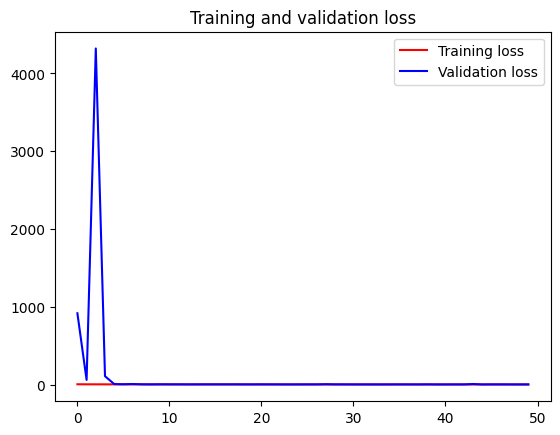

In [7]:
# train_ds, val_ds, class_names, num_classes
# with tensorflow.device("/CPU:0"):
def exec_train_InceptionV3():
    mod_name = "InceptionV3"
    inception_mod = create_model__inception_v3(num_classes)
    summary_model(inception_mod)
    inception_mod, hist = train_model(
        inception_mod, model_name=mod_name, train_ds=train_ds, val_ds=val_ds
    )
    view_train_chart(hist)
    os.makedirs("./models/img_clsr", exist_ok=True)
    inception_mod.save(f"./models/img_clsr/{mod_name}.keras", overwrite=True)
    inception_mod.export(f"./models/img_clsr/{mod_name}_asset/")

exec_train_InceptionV3()

In [17]:
def show_model_train_log(file_list = None):
    import pandas as pd
    import glob
    import os
    import regex as re
    if not file_list:
        model_name = ["ResNet151V2", "InceptionV3"]
        model_data = pd.DataFrame()
        for mod in model_name:
            list_of_files = glob.glob(f"./logs/training__{mod}*.csv") # * means all if need specific format then *.csv
            latest_file = max(list_of_files, key=os.path.getctime)
            print(latest_file)
            df = pd.read_csv(latest_file)
            df['model_name']=mod

            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data
    else:
        model_data = pd.DataFrame()

        for log_file in file_list:
            print(log_file)
            regex = re.compile(r"training__(\w+).csv")
            df = pd.read_csv(log_file)
            df["model_name"] = regex.search(log_file).group(1)
            # df['timestamp'] = time.strptime(os.path.getctime(log_file)).strftime("%Y-%m-%d %H:%M:%S")
            # df["timestamp"] = regex.search(log_file).group(2)
            model_data = pd.concat([model_data, df], ignore_index=True, sort=False)

        return model_data

def plot_loss_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["loss"],label="loss")
    plt.plot(df["epoch"],df["val_loss"],label="val_loss")
    plt.legend()
    plt.show()


def plot_acc_graph(df):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    plt.plot(df["epoch"],df["acc"],label="acc")
    plt.plot(df["epoch"],df["val_acc"],label="val_acc")
    plt.legend()
    plt.show()

In [22]:
# local
df =  show_model_train_log()
# df = show_model_train_log()



./logs/training__ResNet151V2__2024-05-10_16-36-41.csv
./logs/training__InceptionV3__2024-05-11_01-18-29.csv


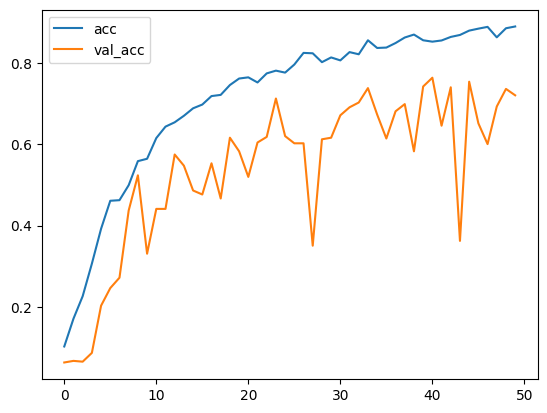

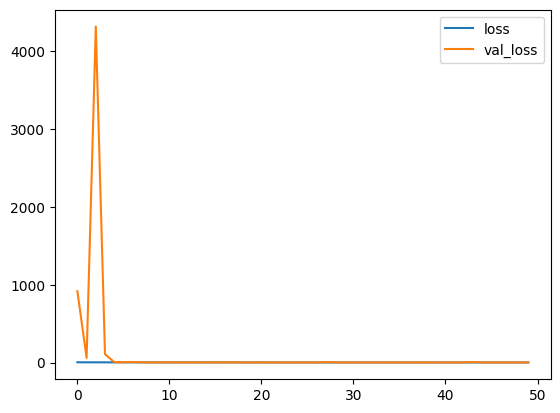

In [23]:
inception_data = df.query("model_name ==  'InceptionV3' | model_name == 'inception_v3' ")
plot_acc_graph(inception_data)
plot_loss_graph(inception_data)

In [11]:
df.iloc[inception_data['epoch'].idxmax()]

epoch                  49
acc              0.889859
loss             0.324273
val_acc          0.720472
val_loss         1.078742
model_name    InceptionV3
Name: 99, dtype: object

In [29]:
inception_data.iloc[-11:-1]

,epoch,acc,loss,val_acc,val_loss,model_name
89,39,0.855895,0.438121,0.742126,0.825151,InceptionV3
90,40,0.852499,0.509033,0.763780,0.790220,InceptionV3
91,41,0.855410,0.461115,0.645669,1.324555,InceptionV3
92,42,0.864144,0.417580,0.740157,1.000214,InceptionV3
93,43,0.868996,0.394194,0.362205,6.346032,InceptionV3
94,44,0.879670,0.384946,0.753937,0.817322,InceptionV3
95,45,0.884522,0.360265,0.651575,1.622432,InceptionV3
96,46,0.888889,0.355472,0.600394,1.656405,InceptionV3
97,47,0.863173,0.437304,0.692913,1.071869,InceptionV3
98,48,0.885493,0.337785,0.736220,0.930025,InceptionV3


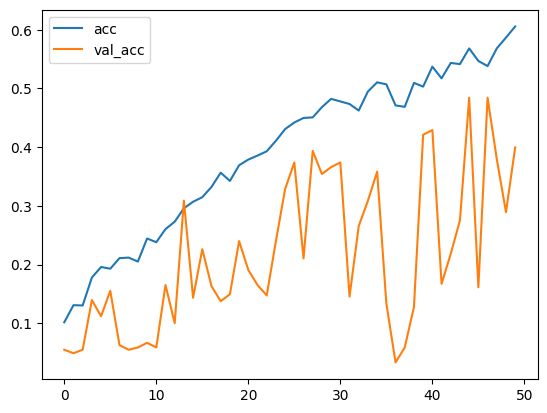

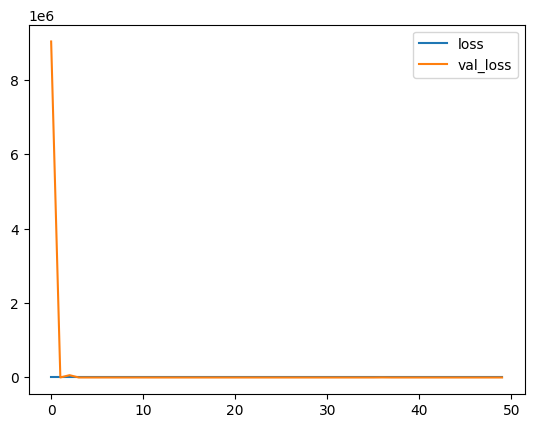

In [24]:
# resnet_data = df[df["model_name"] == "resnet151_v2"]
resnet_data = df.query("model_name ==  'ResNet151V2' | model_name =='resnet151_v2' ")
plot_acc_graph(resnet_data)
plot_loss_graph(resnet_data)

In [28]:
resnet_data.iloc[-11:-1]

,epoch,acc,loss,val_acc,val_loss,model_name
39,39,0.503154,1.435106,0.421260,2.812391,ResNet151V2
40,40,0.537118,1.358642,0.429134,1.859967,ResNet151V2
41,41,0.517225,1.424365,0.167323,6.149977,ResNet151V2
42,42,0.543426,1.380548,0.218504,4.209120,ResNet151V2
43,43,0.541485,1.366143,0.275591,5.821958,ResNet151V2
44,44,0.568171,1.301499,0.484252,1.539592,ResNet151V2
45,45,0.546822,1.360162,0.161417,4.624462,ResNet151V2
46,46,0.538088,1.373941,0.484252,2.244196,ResNet151V2
47,47,0.568171,1.274947,0.379921,2.211830,ResNet151V2
48,48,0.586608,1.236754,0.289370,3.032795,ResNet151V2


In [14]:
# test run, evaluate the model

In [31]:
def test_resnet151v2_model():
    # test_ds = prepare_data(DATA_PATH, BATCH_SIZE)[2]
    test_model("ResNet151V2", test_ds)


test_resnet151v2_model()

test for ResNet151V2


Model: "resnet_v2_impl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 20)             │        20,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,236,630 (809.62 MB)

 Trainable params: 70,697,628 (269.69 MB)

 Non-trainable params: 143,744 (561.50 KB)

 Optimizer params: 141,395,258 (539.38 MB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - acc: 0.4343 - loss: 2.3995
Test loss: 2.3890559673309326, acc: 0.3988006114959717
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step
[[1.81277078e-02 6.97010430e-04 7.73784763e-04 ... 5.25830640e-03
  2.11628751e-04 3.10150068e-03]
 [8.86937050e-06 2.11379597e-06 4.93032741e-04 ... 2.59917695e-02
  9.06175613e-01 1.67416013e-03]
 [1.28076377e-03 5.92441984e-06 5.77262277e-03 ... 8.18710849e-02
  6.40906155e-01 3.24621536e-02]
 ...
 [1.41752672e-08 3.32174409e-07 7.23675385e-07 ... 3.31004657e-07
  1.81131590e-08 5.94899374e-09]
 [2.95767059e-05 1.49823854e-05 1.45270431e-04 ... 9.08695569e-04
  1.73046938e-04 1.88033193e-01]
 [1.96277633e-01 1.13775795e-02 7.75075145e-03 ... 1.42302781e-01
  7.24030957e-02 2.05725104e-01]]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2 

ValueError: multiclass format is not supported

In [ ]:
def test_inception_v3_model():

    # test_ds = prepare_data(DATA_PATH, BATCH_SIZE)[2]
    test_model("InceptionV3", test_ds)


test_inception_v3_model()